## Rover Project Test Notebook
This notebook contains the functions from the lesson and provides the scaffolding you need to test out your mapping methods.  The steps you need to complete in this notebook for the project are the following:

* First just run each of the cells in the notebook, examine the code and the results of each.
* Run the simulator in "Training Mode" and record some data. Note: the simulator may crash if you try to record a large (longer than a few minutes) dataset, but you don't need a ton of data, just some example images to work with.   
* Change the data directory path (2 cells below) to be the directory where you saved data
* Test out the functions provided on your data
* Write new functions (or modify existing ones) to report and map out detections of obstacles and rock samples (yellow rocks)
* Populate the `process_image()` function with the appropriate steps/functions to go from a raw image to a worldmap.
* Run the cell that calls `process_image()` using `moviepy` functions to create video output
* Once you have mapping working, move on to modifying `perception.py` and `decision.py` to allow your rover to navigate and map in autonomous mode!

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

**Run the next cell to get code highlighting in the markdown cells.**

In [31]:
%%HTML
<style> code {background-color : orange !important;} </style>

In [32]:
%matplotlib inline
#%matplotlib qt # Choose %matplotlib qt to plot to an interactive window (note it may show up behind your browser)
# Make some of the relevant imports
import cv2 # OpenCV for perspective transform
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import scipy.misc # For saving images as needed
import glob  # For reading in a list of images from a folder

## Quick Look at the Data
There's some example data provided in the `test_dataset` folder.  This basic dataset is enough to get you up and running but if you want to hone your methods more carefully you should record some data of your own to sample various scenarios in the simulator.  

Next, read in and display a random image from the `test_dataset` folder

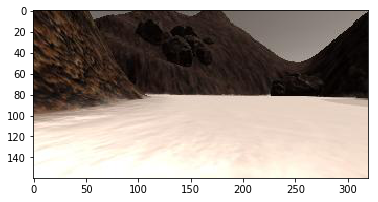

In [33]:
path = '../generated_dataset/IMG/*'
img_list = glob.glob(path)
# Grab a random image and display it
idx = np.random.randint(0, len(img_list)-1)
image = mpimg.imread(img_list[idx])
plt.imshow(image)

## Calibration Data
Read in and display example grid and rock sample calibration images.  You'll use the grid for perspective transform and the rock image for creating a new color selection that identifies these samples of interest. 

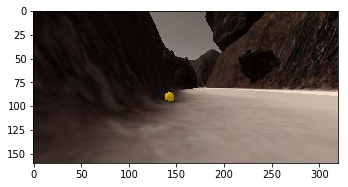

In [158]:
# In the simulator you can toggle on a grid on the ground for calibration
# You can also toggle on the rock samples with the 0 (zero) key.  
# Here's an example of the grid and one of the rocks
example_grid = '../calibration_images/example_grid1.jpg'
example_rock = '../calibration_images/example_rock3.jpg'
example_rock_pick_upable = '../calibration_images/example_rock_pick_upable.jpg'
example_obstacle = '../calibration_images/example_obsticle1.jpg'
example_overhang = '../calibration_images/example_overhang1.jpg'
example_pickingup = '../calibration_images/example_pickingup1.jpg'
grid_img = mpimg.imread(example_grid)
rock_img = mpimg.imread(example_rock)
obstacle_img = mpimg.imread(example_obstacle)
overhang_img = mpimg.imread(example_overhang)
pick_upable_rock_img = mpimg.imread(example_rock_pick_upable)
pickingup_img = mpimg.imread(example_pickingup)

fig = plt.figure(figsize=(12,3))
plt.subplot(121)
plt.imshow(rock_img)
# plt.subplot(122)
# plt.imshow(pickingup_img)

## Perspective Transform

Define the perspective transform function from the lesson and test it on an image.

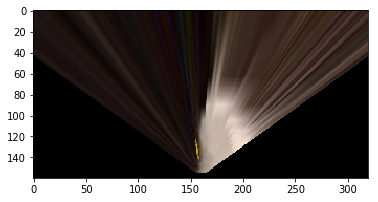

In [154]:
# Define a function to perform a perspective transform
# I've used the example grid image above to choose source points for the
# grid cell in front of the rover (each grid cell is 1 square meter in the sim)
# Define a function to perform a perspective transform
def perspect_transform(img, src, dst):
           
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]))# keep same size as input image
    
    return warped


# Define calibration box in source (actual) and destination (desired) coordinates
# These source and destination points are defined to warp the image
# to a grid where each 10x10 pixel square represents 1 square meter
# The destination box will be 2*dst_size on each side
dst_size = 5 
# Set a bottom offset to account for the fact that the bottom of the image 
# is not the position of the rover but a bit in front of it
# this is just a rough guess, feel free to change it!
bottom_offset = 6
source = np.float32([[14, 140], [301 ,140],[200, 96], [118, 96]])
destination = np.float32([[image.shape[1]/2 - dst_size, image.shape[0] - bottom_offset],
                  [image.shape[1]/2 + dst_size, image.shape[0] - bottom_offset],
                  [image.shape[1]/2 + dst_size, image.shape[0] - 2*dst_size - bottom_offset], 
                  [image.shape[1]/2 - dst_size, image.shape[0] - 2*dst_size - bottom_offset],
                  ])
warped = perspect_transform(rock_img, source, destination)
plt.imshow(warped)
#scipy.misc.imsave('../output/warped_example.jpg', warped)

## Color Thresholding
Define the color thresholding function from the lesson and apply it to the warped image

**TODO:** Ultimately, you want your map to not just include navigable terrain but also obstacles and the positions of the rock samples you're searching for.  Modify this function or write a new function that returns the pixel locations of obstacles (areas below the threshold) and rock samples (yellow rocks in calibration images), such that you can map these areas into world coordinates as well.  
**Hints and Suggestion:** 
* For obstacles you can just invert your color selection that you used to detect ground pixels, i.e., if you've decided that everything above the threshold is navigable terrain, then everthing below the threshold must be an obstacle!


* For rocks, think about imposing a lower and upper boundary in your color selection to be more specific about choosing colors.  You can investigate the colors of the rocks (the RGB pixel values) in an interactive matplotlib window to get a feel for the appropriate threshold range (keep in mind you may want different ranges for each of R, G and B!).  Feel free to get creative and even bring in functions from other libraries.  Here's an example of [color selection](http://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_colorspaces/py_colorspaces.html) using OpenCV.  

* **Beware However:** if you start manipulating images with OpenCV, keep in mind that it defaults to `BGR` instead of `RGB` color space when reading/writing images, so things can get confusing.

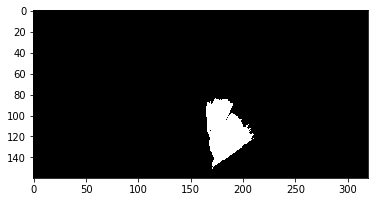

In [155]:
# Identify pixels above the threshold
# Threshold of RGB > 160 does a nice job of identifying ground pixels only
def color_thresh(img, rgb_thresh=(160, 160, 160)):
    # Create an array of zeros same xy size as img, but single channel
    color_select = np.zeros_like(img[:,:,0])
    # Require that each pixel be above all three threshold values in RGB
    # above_thresh will now contain a boolean array with "True"
    # where threshold was met
    above_thresh = (img[:,:,0] > rgb_thresh[0]) \
                & (img[:,:,1] > rgb_thresh[1]) \
                & (img[:,:,2] > rgb_thresh[2])
    # Index the array of zeros with the boolean array and set to 1
    color_select[above_thresh] = 1
    # Return the binary image
    return color_select

threshed = color_thresh(warped)
plt.imshow(threshed, cmap='gray')
#scipy.misc.imsave('../output/warped_threshed.jpg', threshed*255)

160 45


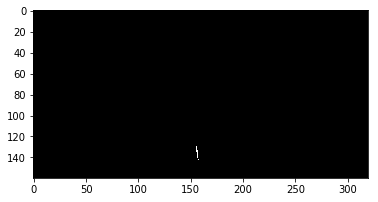

In [156]:
# Identify pixels in range.
# Threshold of 120 < R < 220, 100 < G < 180 and -1 < B < 90 does a nice job of identifying rock samples
def color_range(img, rgb_thresh_bottom=(135, 100, -1), rgb_thresh_top=(200, 180, 40)):
    # Create an array of zeros same xy size as img, but single channel
    color_select = np.zeros_like(img[:,:,0])
    # Requires that each pixel be in between the range for all three threshold values of RGB.
    # in_range will now contain a boolean array with 'True' where the values are in range given.
    in_range = (img[:,:,0] > rgb_thresh_bottom[0]) & (img[:,:,0] < rgb_thresh_top[0]) \
            & (img[:,:,1] > rgb_thresh_bottom[1]) & (img[:,:,1] < rgb_thresh_top[1]) \
            & (img[:,:,2] > rgb_thresh_bottom[2]) & (img[:,:,2] < rgb_thresh_top[2])
    
    # Index the arry of zeros with the boolean array and set to 1
    color_select[in_range] = 1
    print(len(in_range), np.count_nonzero(in_range))
    
    
    # Return the binary image
    return color_select


rock_threshed = color_range(rock_img)
warped = perspect_transform(rock_threshed, source, destination)
plt.imshow(warped, cmap='gray')

160 1442


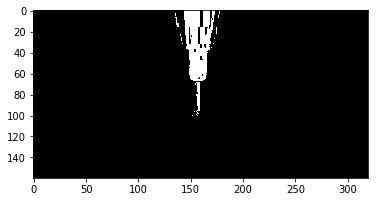

In [127]:
# Identify pixels in range.
# Threshold of 120 < R < 220, 100 < G < 180 and -1 < B < 90 does a nice job of identifying rock samples
def color_range_pickup(img, rgb_thresh_bottom=(85, 10, -1), rgb_thresh_top=(125, 30, 5)):
    # Create an array of zeros same xy size as img, but single channel
    color_select = np.zeros_like(img[:,:,0])
    # Requires that each pixel be in between the range for all three threshold values of RGB.
    # in_range will now contain a boolean array with 'True' where the values are in range given.
    in_range = (img[:,:,0] > rgb_thresh_bottom[0]) & (img[:,:,0] < rgb_thresh_top[0]) \
            & (img[:,:,1] > rgb_thresh_bottom[1]) & (img[:,:,1] < rgb_thresh_top[1]) \
            & (img[:,:,2] > rgb_thresh_bottom[2]) & (img[:,:,2] < rgb_thresh_top[2])
    
    # Index the arry of zeros with the boolean array and set to 1
    color_select[in_range] = 1
    print(len(in_range), np.count_nonzero(in_range))
    
    
    # Return the binary image
    return color_select

threshed = color_range_pickup(pickingup_img)
plt.imshow(threshed, cmap='gray')
#scipy.misc.imsave('../output/warped_threshed.jpg', threshed*255)

## Coordinate Transformations
Define the functions used to do coordinate transforms and apply them to an image.

-0.24485728891
-0.0723373305386
160 45
(160, 320) (160, 320, 3)
False
14
24.9339892055


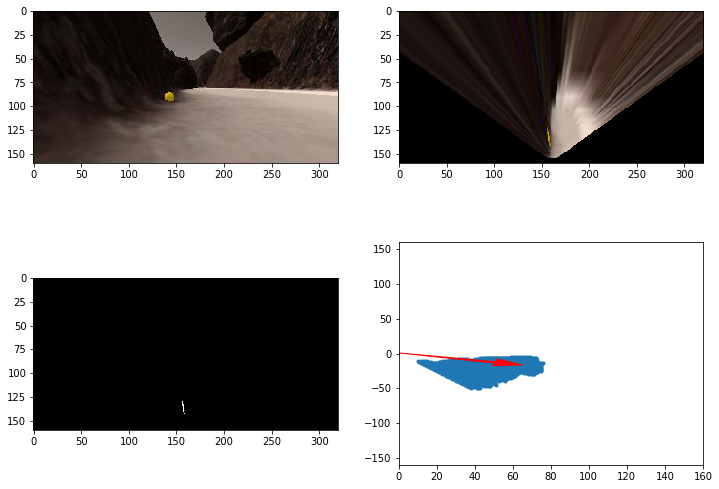

In [161]:
def rover_coords(binary_img):
    # Identify nonzero pixels
    ypos, xpos = binary_img.nonzero()
    # Calculate pixel positions with reference to the rover position being at the 
    # center bottom of the image.  
    x_pixel = np.absolute(ypos - binary_img.shape[0]).astype(np.float)
    y_pixel = -(xpos - binary_img.shape[1]/2 ).astype(np.float)
    return x_pixel, y_pixel

# Define a function to convert to radial coords in rover space
def to_polar_coords(x_pixel, y_pixel):
    # Convert (x_pixel, y_pixel) to (distance, angle) 
    # in polar coordinates in rover space
    # Calculate distance to each pixel
    dist = np.sqrt(x_pixel**2 + y_pixel**2)
    # Calculate angle away from vertical for each pixel
    angles = np.arctan2(y_pixel, x_pixel)
    return dist, angles

# Define a function to apply a rotation to pixel positions
def rotate_pix(xpix, ypix, yaw):
    # Convert yaw to radians
    # Apply a rotation
    yaw_rad = yaw * np.pi / 180
    xpix_rotated = xpix * np.cos(yaw_rad) - ypix * np.sin(yaw_rad)
    ypix_rotated = xpix * np.sin(yaw_rad) + ypix * np.cos(yaw_rad)
    # Return the result  
    return xpix_rotated, ypix_rotated

# Define a function to perform a translation
def translate_pix(xpix_rot, ypix_rot, xpos, ypos, scale):
    # Apply a scaling and a translation
    xpix_translated = np.int_(xpos + (xpix_rot / scale))
    ypix_translated = np.int_(ypos + (ypix_rot / scale))
    # Return the result  
    return xpix_translated, ypix_translated

# Define a function to apply rotation and translation (and clipping)
# Once you define the two functions above this function should work
def pix_to_world(xpix, ypix, xpos, ypos, yaw, world_size, scale):
    # Apply rotation
    xpix_rot, ypix_rot = rotate_pix(xpix, ypix, yaw)
    # Apply translation
    xpix_tran, ypix_tran = translate_pix(xpix_rot, ypix_rot, xpos, ypos, scale)
    # Perform rotation, translation and clipping all at once
    x_pix_world = np.clip(np.int_(xpix_tran), 0, world_size - 1)
    y_pix_world = np.clip(np.int_(ypix_tran), 0, world_size - 1)
    # Return the result
    return x_pix_world, y_pix_world

# Grab another random image
# idx = np.random.randint(0, len(img_list)-1)
# image = mpimg.imread(img_list[idx])
image = rock_img
warped = perspect_transform(image, source, destination)
threshed = color_thresh(warped)

# Calculate pixel values in rover-centric coords and distance/angle to all pixels
xpix, ypix = rover_coords(threshed)

dist, angles = to_polar_coords(xpix, ypix)
mean_dir = np.mean(angles)
# np.clip(np.max(angles * 180/np.pi) - 10, -15, 15)
clip_angle = 15 * (np.pi / 180)
max_dir = np.clip(np.mean(angles) + (14 * np.pi / 180), -clip_angle, clip_angle)
print(max_dir) 
print(np.max(angles))

rock_threshed = color_range(image)
rock_threshed = perspect_transform(rock_threshed, source, destination)
rock_threshed[:, (int)(rock_threshed.shape[1] / 2)] = 0
rock_xpix, rock_ypix = rover_coords(rock_threshed)
print(rock_threshed.shape, image.shape)
rock_distances, rock_angles  = to_polar_coords(rock_xpix, rock_ypix)
is_near_rock = len(rock_distances) and np.mean(rock_distances) < 13
print(is_near_rock)
print(len(rock_distances))
print(np.mean(rock_distances))

# Do some plotting
fig = plt.figure(figsize=(12,9))
plt.subplot(221)
plt.imshow(image)
plt.subplot(222)
plt.imshow(warped)
plt.subplot(223)
plt.imshow(rock_threshed, cmap='gray')
plt.subplot(224)
plt.plot(xpix, ypix, '.')
plt.ylim(-160, 160)
plt.xlim(0, 160)
arrow_length = np.mean(dist)
x_arrow = arrow_length * np.cos(max_dir)
y_arrow = arrow_length * np.sin(max_dir)
plt.arrow(0, 0, x_arrow, y_arrow, color='red', zorder=2, head_width=10, width=2)



## Read in saved data and ground truth map of the world
The next cell is all setup to read your saved data into a `pandas` dataframe.  Here you'll also read in a "ground truth" map of the world, where white pixels (pixel value = 1) represent navigable terrain.  

After that, we'll define a class to store telemetry data and pathnames to images.  When you instantiate this class (`data = Databucket()`) you'll have a global variable called `data` that you can refer to for telemetry and map data within the `process_image()` function in the following cell.  


In [162]:
# Import pandas and read in csv file as a dataframe
import pandas as pd
# Change the path below to your data directory
# If you are in a locale (e.g., Europe) that uses ',' as the decimal separator
# change the '.' to ','
df = pd.read_csv('../generated_dataset/robot_log.csv', delimiter=';', decimal='.')
csv_img_list = df["Path"].tolist() # Create list of image pathnames
# Read in ground truth map and create a 3-channel image with it
ground_truth = mpimg.imread('../calibration_images/map_bw.png')
ground_truth_3d = np.dstack((ground_truth*0, ground_truth*255, ground_truth*0)).astype(np.float)

# Creating a class to be the data container
# Will read in saved data from csv file and populate this object
# Worldmap is instantiated as 200 x 200 grids corresponding 
# to a 200m x 200m space (same size as the ground truth map: 200 x 200 pixels)
# This encompasses the full range of output position values in x and y from the sim
class Databucket():
    def __init__(self):
        self.images = csv_img_list  
        self.xpos = df["X_Position"].values
        self.ypos = df["Y_Position"].values
        self.yaw = df["Yaw"].values
        self.count = -1 # This will be a running index, setting to -1 is a hack
                        # because moviepy (below) seems to run one extra iteration
        self.worldmap = np.zeros((200, 200, 3)).astype(np.float)
        self.ground_truth = ground_truth_3d # Ground truth worldmap

# Instantiate a Databucket().. this will be a global variable/object
# that you can refer to in the process_image() function below
data = Databucket()


## Write a function to process stored images

Modify the `process_image()` function below by adding in the perception step processes (functions defined above) to perform image analysis and mapping.  The following cell is all set up to use this `process_image()` function in conjunction with the `moviepy` video processing package to create a video from the images you saved taking data in the simulator.  

In short, you will be passing individual images into `process_image()` and building up an image called `output_image` that will be stored as one frame of video.  You can make a mosaic of the various steps of your analysis process and add text as you like (example provided below).  



To start with, you can simply run the next three cells to see what happens, but then go ahead and modify them such that the output video demonstrates your mapping process.  Feel free to get creative!

In [163]:

# Define a function to pass stored images to
# reading rover position and yaw angle from csv file
# This function will be used by moviepy to create an output video
def process_image(img):
    # Example of how to use the Databucket() object defined above
    # to print the current x, y and yaw values 
    print(data.xpos[data.count], data.ypos[data.count], data.yaw[data.count])

    # 1) Define source and destination points for perspective transform
    bottom_offset = 10
    source = np.float32([[14, 140], [301 ,140],[200, 96], [118, 96]])
    destination = np.float32([[img.shape[1]/2 - dst_size, img.shape[0] - bottom_offset],
                  [img.shape[1]/2 + dst_size, img.shape[0] - bottom_offset],
                  [img.shape[1]/2 + dst_size, img.shape[0] - 2*dst_size - bottom_offset], 
                  [img.shape[1]/2 - dst_size, img.shape[0] - 2*dst_size - bottom_offset],
                  ])
    # 2) Apply perspective transform
    warped = perspect_transform(img, source, destination)
    # 3) Apply color threshold to identify navigable terrain/obstacles/rock samples
    threshed = color_thresh(warped)
    rock_threshed = color_range(warped)
    obsticle_threshed = ~threshed
    # 4) Convert thresholded image pixel values to rover-centric coords
    navigable_xpix, navigable_ypix = rover_coords(threshed)
    rock_xpix, rock_ypix = rover_coords(rock_threshed)
    obsticle_xpix, obsticle_ypix = rover_coords(obsticle_threshed)
    
    max_distance = 50
    max_rock_distance = 40

    good_navigable = np.sqrt(navigable_xpix**2 + navigable_ypix**2) < max_distance
    good_navigable_x = navigable_xpix[good_navigable]
    good_navigable_y = navigable_ypix[good_navigable]

    good_rock = np.sqrt(rock_xpix**2 + rock_ypix**2) < max_rock_distance
    good_rock_x = rock_xpix[good_rock]
    good_rock_y = rock_ypix[good_rock]

    good_obsticle = np.sqrt(obsticle_xpix**2 + obsticle_ypix**2) < max_distance
    good_obsticle_x = obsticle_xpix[good_obsticle]
    good_obsticle_y = obsticle_ypix[good_obsticle]
    
    # 5) Convert rover-centric pixel values to world coords
    scale = 2 * dst_size
    navigable_xpix_world, navigable_ypix_world = pix_to_world(good_navigable_x, \
                                                              good_navigable_y, \
                                                              data.xpos[data.count], \
                                                              data.ypos[data.count], \
                                                              data.yaw[data.count], \
                                                              data.worldmap.shape[0], \
                                                              scale)
    rock_xpix_world, rock_ypix_world = pix_to_world(good_rock_x, \
                                                    good_rock_y, \
                                                    data.xpos[data.count], \
                                                    data.ypos[data.count], \
                                                    data.yaw[data.count], \
                                                    data.worldmap.shape[0], \
                                                    scale)
    obsticle_xpix_world, obsticle_ypix_world = pix_to_world(good_obsticle_x, \
                                                            good_obsticle_y, \
                                                            data.xpos[data.count], \
                                                            data.ypos[data.count], \
                                                            data.yaw[data.count], \
                                                            data.worldmap.shape[0], \
                                                            scale)
    # 6) Update worldmap (to be displayed on right side of screen)
        # Example: data.worldmap[obstacle_y_world, obstacle_x_world, 0] += 1
        #          data.worldmap[rock_y_world, rock_x_world, 1] += 1
        #          data.worldmap[navigable_y_world, navigable_x_world, 2] += 1
    data.worldmap[navigable_ypix_world, navigable_xpix_world, 2] = 255
    data.worldmap[rock_ypix_world, rock_xpix_world, 1] = 255
    data.worldmap[navigable_ypix_world, navigable_xpix_world, 0] = 0
    data.worldmap[obsticle_ypix_world, obsticle_xpix_world, 0] = 255
    # 7) Make a mosaic image, below is some example code
        # First create a blank image (can be whatever shape you like)
    output_image = np.zeros((img.shape[0] + data.worldmap.shape[0], img.shape[1]*2, 3))
        # Next you can populate regions of the image with various output
        # Here I'm putting the original image in the upper left hand corner
    output_image[0:img.shape[0], 0:img.shape[1]] = img

        # Let's create more images to add to the mosaic, first a warped image
#     warped = perspect_transform(img, source, destination)
        # Add the warped image in the upper right hand corner
    output_image[0:img.shape[0], img.shape[1]:] = warped

        # Overlay worldmap with ground truth map
    map_add = cv2.addWeighted(data.worldmap, 1, data.ground_truth, 0.5, 0)
        # Flip map overlay so y-axis points upward and add to output_image 
    output_image[img.shape[0]:, 0:data.worldmap.shape[1]] = np.flipud(map_add)
    
    # Add rover vision image.
    output_image[-img.shape[0]:, img.shape[1]:, 0] = threshed * 255
    output_image[-img.shape[0]:, img.shape[1]:, 1] = rock_threshed * 255
    output_image[-img.shape[0]:, img.shape[1]:, 2] = obsticle_threshed * 255


        # Then putting some text over the image
    cv2.putText(output_image,"Original Image", (20, 20), 
                cv2.FONT_HERSHEY_COMPLEX, 0.4, (255, 255, 255), 1)
    cv2.putText(output_image,"Warped Image", (20 + img.shape[1], 20), 
                cv2.FONT_HERSHEY_COMPLEX, 0.4, (255, 255, 255), 1)
    cv2.putText(output_image,"World Map", (20, 20 + img.shape[0]), 
                cv2.FONT_HERSHEY_COMPLEX, 0.4, (255, 255, 255), 1)
    cv2.putText(output_image,"Rover Vision", (20 + img.shape[1], 20 + img.shape[0]), 
                cv2.FONT_HERSHEY_COMPLEX, 0.4, (255, 255, 255), 1)
    data.count += 1 # Keep track of the index in the Databucket()
    
    return output_image

## Make a video from processed image data
Use the [moviepy](https://zulko.github.io/moviepy/) library to process images and create a video.
  

In [164]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from moviepy.editor import ImageSequenceClip


# Define pathname to save the output video
output = '../output/test_mapping.mp4'
data = Databucket() # Re-initialize data in case you're running this cell multiple times
clip = ImageSequenceClip(data.images, fps=60) # Note: output video will be sped up because 
                                          # recording rate in simulator is fps=25
new_clip = clip.fl_image(process_image) #NOTE: this function expects color images!!
%time new_clip.write_videofile(output, audio=False)

92.0584 79.03773 165.7513
160 0
[MoviePy] >>>> Building video ../output/test_mapping.mp4
[MoviePy] Writing video ../output/test_mapping.mp4


  0%|                                                                                                                   | 0/6119 [00:00<?, ?it/s]

99.66999 85.58897 58.41705
160 0
99.66999 85.58897 58.41705
160 0
99.66999 85.58897 58.41705
160 0
99.66999 85.58897 58.41705
160 0
99.66999 85.58897 58.41705
160 0


  0%|                                                                                                           | 5/6119 [00:00<02:06, 48.18it/s]

99.66999 85.58897 58.41705
160 0
99.66999 85.58897 58.41705
160 0
99.66999 85.58897 58.41705
160 0
99.66999 85.58897 58.41705
160 0
99.66999 85.58897 58.41705
160 0
99.66999 85.58897 58.41705
160 0
99.66999 85.58897 58.41705
160 0


  0%|▏                                                                                                         | 12/6119 [00:00<01:58, 51.53it/s]

99.66999 85.58897 58.41705
160 0
99.66999 85.58897 58.41705
160 0
99.66999 85.58897 58.41705
160 0
99.66999 85.58897 58.41705
160 0
99.66999 85.58897 58.41705
160 0
99.66999 85.58897 58.41705
160 0


  0%|▎                                                                                                         | 18/6119 [00:00<01:55, 52.99it/s]

99.66999 85.58897 58.41705
160 0
99.66999 85.58897 58.41705
160 0
99.66999 85.58897 58.41705
160 0
99.67036 85.58956 58.4171
160 0
99.67018 85.58928 58.40911
160 0
99.67084 85.59035 58.40899
160 0
99.67083 85.59035 58.40899
160 0


  0%|▍                                                                                                         | 25/6119 [00:00<01:49, 55.68it/s]

99.67083 85.59034 58.40899
160 0
99.67084 85.59035 58.40898
160 0
99.67085 85.59035 58.40899
160 0
99.67085 85.59036 58.40899
160 0
99.67086 85.59037 58.409
160 0
99.67087 85.59037 58.40899
160 0
99.67088 85.59038 58.409
160 0


  1%|▌                                                                                                         | 32/6119 [00:00<01:43, 58.91it/s]

99.67088 85.59039 58.409
160 0
99.67088 85.59039 58.409
160 0
99.67088 85.59039 58.409
160 0
99.67087 85.59038 58.409
160 0
99.67087 85.59038 58.409
160 0
99.67087 85.59039 58.409
160 0
99.67087 85.59039 58.409
160 0
99.67088 85.59039 58.409
160 0


  1%|▋                                                                                                         | 40/6119 [00:00<01:37, 62.21it/s]

99.67088 85.59039 58.40901
160 0
99.67088 85.59039 58.40901
160 0
99.67088 85.59039 58.40901
160 0
99.67087 85.59039 58.409
160 0
99.67087 85.59039 58.409
160 0
99.67087 85.59039 58.409
160 0
99.67087 85.59039 58.409
160 0
99.67088 85.5904 58.409
160 0


  1%|▊                                                                                                         | 48/6119 [00:00<01:34, 64.27it/s]

99.67094 85.59051 58.409
160 0
99.67175 85.59184 58.4095
160 0
99.67175 85.59184 58.40951
160 0
99.67176 85.59186 58.4095
160 0
99.67176 85.59186 58.4095
160 0
99.67176 85.59187 58.4095
160 0
99.67176 85.59187 58.4095
160 0


  1%|▉                                                                                                         | 55/6119 [00:00<01:35, 63.77it/s]

99.67175 85.59188 58.4095
160 0
99.67175 85.59189 58.4095
160 0
99.67175 85.5919 58.4095
160 0
99.67175 85.5919 58.4095
160 0
99.67175 85.59191 58.4095
160 0
99.67176 85.5919 58.4095
160 0
99.67176 85.5919 58.40949
160 0


  1%|█                                                                                                         | 62/6119 [00:00<01:35, 63.33it/s]

99.67177 85.59189 58.4095
160 0
99.67178 85.59189 58.4095
160 0
99.67178 85.59189 58.4095
160 0
99.67178 85.5919 58.40951
160 0
99.67179 85.59191 58.4093
160 0
99.67188 85.59206 58.47318
160 0
99.67294 85.59377 58.38805
160 0


  1%|█▏                                                                                                        | 69/6119 [00:01<01:33, 64.78it/s]

99.67504 85.5972 58.40923
160 0
99.6774 85.60104 58.43444
160 0
99.68192 85.60839 58.36514
160 0
99.68548 85.61416 58.37779
160 0
99.69305 85.62636 58.24519
160 0
99.69885 85.6357 58.24596
160 0
99.70933 85.65259 58.23232
160 0
99.71686 85.66459 58.18508
160 0


  1%|█▎                                                                                                        | 77/6119 [00:01<01:30, 66.43it/s]

99.72736 85.68207 58.13575
160 0
99.73462 85.69405 58.12608
160 0
99.74744 85.71468 58.16283
160 0
99.75758 85.7309 58.14684
160 0
99.77414 85.75745 58.26976
160 0
99.78624 85.77682 58.1628
160 0
99.80595 85.80819 58.05741
160 0


  1%|█▍                                                                                                        | 84/6119 [00:01<01:29, 67.41it/s]

99.81959 85.82999 57.98568
160 0
99.8407 85.86356 57.88398
160 0
99.85565 85.88729 57.79084
160 0
99.88034 85.92631 57.8409
160 0
99.89769 85.95364 57.80669
160 0
99.92525 85.9971 57.82534
160 0
99.94438 86.02726 57.81845
160 0


  1%|█▌                                                                                                        | 91/6119 [00:01<01:29, 67.62it/s]

99.97428 86.07435 57.78936
160 0
99.99503 86.10702 57.78555
160 0
100.0272 86.15778 57.80836
160 0
100.05 86.19352 57.8177
160 0
100.0851 86.24883 57.86178
160 0
100.1093 86.2869 57.88281
160 0
100.1466 86.34588 57.86655
160 0


  2%|█▋                                                                                                        | 98/6119 [00:01<01:35, 63.34it/s]

100.1725 86.38671 57.84238
160 0
100.2126 86.44994 57.8106
160 0
100.2401 86.49338 57.79631
160 0
100.2828 86.56053 57.77317
160 0
100.3121 86.60664 57.75782
160 0
100.3573 86.67781 57.73972
160 0
100.3884 86.72657 57.72876
160 0


  2%|█▊                                                                                                       | 105/6119 [00:01<01:37, 61.45it/s]

100.4362 86.80166 57.71593
160 0
100.4689 86.85304 57.70736
160 0
100.5193 86.93207 57.6971
160 0
100.5537 86.98602 57.68912
160 0
100.6066 87.06892 57.67971
160 0
100.6427 87.12553 57.67014
160 0
100.6982 87.21231 57.66079
160 0


  2%|█▉                                                                                                       | 112/6119 [00:01<01:37, 61.55it/s]

100.7359 87.27144 57.65359
160 0
100.7938 87.36205 57.64155
160 0
100.8333 87.42376 57.63505
160 0
100.8937 87.51823 57.62403
160 0
100.9347 87.58244 57.61685
160 0
100.9977 87.68074 57.60393
160 0
101.0404 87.74749 57.5971
160 0


  2%|██                                                                                                       | 119/6119 [00:01<01:37, 61.38it/s]

101.1057 87.84949 57.58602
160 0
101.1501 87.91873 57.57952
160 0
101.2178 88.0245 57.56691
160 0
101.2638 88.09624 57.56096
160 0
101.3341 88.20573 57.54849
160 0
101.3816 88.27988 57.54155
160 0
101.4543 88.39307 57.5296
160 0


  2%|██▏                                                                                                      | 126/6119 [00:01<01:37, 61.17it/s]

101.5035 88.46973 57.52354
160 0
101.5785 88.58656 57.5107
160 0
101.6294 88.66569 57.50305
160 0
101.7068 88.78613 57.49225
160 0
101.7592 88.86765 57.48389
160 0
101.8391 88.99178 57.47221
160 0
101.8931 89.07574 57.46462
160 0


  2%|██▎                                                                                                      | 133/6119 [00:02<01:38, 61.03it/s]

101.9753 89.20344 57.45467
160 0
102.0309 89.28973 57.44553
160 0
102.1154 89.42096 57.43321
160 0
102.1726 89.50965 57.42514
160 0
102.2596 89.64449 57.41298
160 0
102.3183 89.73557 57.40484
160 0
102.4076 89.87395 57.39268
160 0


  2%|██▍                                                                                                      | 140/6119 [00:02<01:36, 61.91it/s]

102.4679 89.96738 57.38461
160 0
102.5596 90.10925 57.37255
160 0
102.6214 90.20498 57.36452
160 0
102.7153 90.3503 57.35233
160 0
102.7788 90.4484 57.34518
160 0
102.8751 90.59725 57.33002
160 0
102.94 90.69762 57.32143
160 0


  2%|██▌                                                                                                      | 147/6119 [00:02<01:34, 63.04it/s]

103.038 90.85016 57.42325
160 0
103.1032 90.95348 57.64206
160 0
103.1996 91.11152 58.31271
160 0
103.2624 91.21899 58.97411
160 0
103.354 91.38297 60.23161
160 0
103.4143 91.49395 61.01935
160 0
103.5045 91.66296 61.90094
160 0


  3%|██▋                                                                                                      | 154/6119 [00:02<01:32, 64.30it/s]

103.5648 91.77715 62.28311
160 0
103.6566 91.95074 62.51662
160 0
103.7185 92.06802 62.55328
160 0
103.8125 92.24604 62.55281
160 0
103.8758 92.366 62.53606
160 0
103.9718 92.54817 62.51231
160 0
104.0366 92.67094 62.4911
160 0


  3%|██▊                                                                                                      | 161/6119 [00:02<01:34, 63.27it/s]

104.1348 92.85711 62.46147
160 0
104.2011 92.98239 62.43776
160 0
104.3014 93.17233 62.40647
160 0
104.3687 93.30009 62.38104
160 0
104.4706 93.49227 62.12211
160 0
104.5403 93.62019 61.74454
160 0
104.6485 93.81187 60.8374
160 0


  3%|██▉                                                                                                      | 168/6119 [00:02<01:33, 63.67it/s]

104.7238 93.93904 60.01003
160 0
104.8415 94.12763 58.37902
160 0
104.9235 94.25133 57.05539
160 0
105.0515 94.43433 55.06977
160 0
105.14 94.55511 53.8893
160 0
105.2766 94.73524 52.44733
160 0
105.3701 94.85496 51.70248
160 0


  3%|███                                                                                                      | 175/6119 [00:02<01:35, 62.50it/s]

105.5133 95.03492 50.95056
160 0
105.6105 95.15707 50.70321
160 0
105.7606 95.34381 50.38986
160 0
105.8639 95.4677 50.02422
160 0
106.0227 95.65157 49.13588
160 0
106.1312 95.77238 48.29797
160 0
106.2989 95.94968 46.64517
160 0


  3%|███                                                                                                      | 182/6119 [00:02<01:35, 62.45it/s]

106.4138 96.06537 45.42904
160 0
106.5903 96.23742 43.85164
160 0
106.7109 96.35136 42.99156
160 0
106.8939 96.52068 42.015
160 0
107.0173 96.63215 41.5828
160 0
107.2052 96.79601 40.94381
160 0
107.3956 96.95593 40.09456
160 0


  3%|███▏                                                                                                     | 189/6119 [00:02<01:33, 63.35it/s]

107.524 97.05997 39.33511
160 0
107.6529 97.16182 38.42639
160 0
107.8495 97.3097 36.74358
160 0
107.982 97.40414 35.44844
160 0
108.1826 97.54292 33.5902
160 0
108.3192 97.63003 32.49582
160 0
108.5259 97.75648 31.1336
160 0


  3%|███▎                                                                                                     | 196/6119 [00:03<01:35, 61.87it/s]

108.6646 97.83924 30.41752
160 0
108.8743 97.96155 29.70277
160 0
109.015 98.04227 29.42556
160 0
109.2278 98.16309 29.25486
160 0
109.371 98.24385 29.21476
160 0
109.5881 98.36589 29.19512
160 0
109.7343 98.44796 29.1941
160 0


  3%|███▍                                                                                                     | 203/6119 [00:03<01:34, 62.68it/s]

109.9552 98.57194 29.20066
160 0
110.1032 98.65501 29.20824
160 0
110.3257 98.77995 29.22288
160 0
110.474 98.86329 29.23405
160 0
110.696 98.98806 29.2512
160 0
110.9167 99.11218 29.26699
160 0
111.063 99.19445 29.27612
160 0


  3%|███▌                                                                                                     | 210/6119 [00:03<01:32, 63.69it/s]

111.2087 99.27635 29.28414
160 0
111.4271 99.39793 29.2712
160 0
111.6454 99.51937 29.25467
160 0
111.7914 99.60046 29.24198
160 0
111.9379 99.68181 29.22866
160 0
112.1592 99.80464 29.20825
160 0
112.308 99.88721 29.19459
160 0


  4%|███▋                                                                                                     | 217/6119 [00:03<01:32, 64.06it/s]

112.5333 100.0122 29.17391
160 0
112.6846 100.0961 29.16003
160 0
112.9127 100.2225 29.13907
160 0
113.0651 100.3069 29.12506
160 0
113.2938 100.4337 29.1092
160 0
113.4459 100.5183 29.10603
160 0
113.6739 100.6451 29.10155
160 0


  4%|███▊                                                                                                     | 224/6119 [00:03<01:33, 63.36it/s]

113.9025 100.7721 29.09597
160 0
114.0557 100.8571 29.09119
160 0
114.2096 100.9425 29.08531
160 0
114.4429 101.0708 28.92559
160 0
114.6793 101.1986 28.4885
160 0
114.8389 101.2825 27.98743
160 0
115.0819 101.4052 26.92133
160 0


  4%|███▉                                                                                                     | 231/6119 [00:03<01:32, 63.39it/s]

115.2459 101.4851 26.13717
160 0
115.4931 101.6032 25.08953
160 0
115.6569 101.6815 24.51683
160 0
115.8215 101.7581 24.09781
160 0
116.0692 101.8709 23.8308
160 0
116.317 101.9823 23.75162
160 0
116.482 102.056 23.73771
160 0


  4%|████                                                                                                     | 238/6119 [00:03<01:31, 63.93it/s]

116.6471 102.1295 23.73595
160 0
116.8955 102.2398 23.74105
160 0
117.146 102.3514 23.76238
160 0
117.3143 102.4261 23.77332
160 0
117.5692 102.539 23.78255
160 0
117.7408 102.6149 23.78554
160 0
117.9137 102.6913 23.78759
160 0


  4%|████▏                                                                                                    | 245/6119 [00:03<01:30, 64.68it/s]

118.175 102.807 23.80632
160 0
118.3502 102.8853 23.89651
160 0
118.614 103.0058 24.30544
160 0
118.8784 103.1308 25.06471
160 0
119.0544 103.2171 25.78833
160 0
119.3168 103.3507 27.13972
160 0
119.4898 103.4424 28.28425
160 0


  4%|████▎                                                                                                    | 252/6119 [00:03<01:31, 63.87it/s]

119.7444 103.5844 30.3586
160 0
119.9104 103.6829 31.86688
160 0
120.1535 103.8362 34.10305
160 0
120.3122 103.9411 35.37539
160 0
120.5503 104.1026 36.89795
160 0
120.71 104.2152 37.65777
160 0
120.9488 104.3899 38.35307
160 0


  4%|████▍                                                                                                    | 259/6119 [00:04<01:34, 62.13it/s]

121.1063 104.5099 38.58298
160 0
121.3426 104.6927 38.66111
160 0
121.4985 104.816 38.67543
160 0
121.7311 105.0018 38.68869
160 0
121.886 105.1262 38.7312
160 0
122.1178 105.3143 38.96341
160 0
122.2718 105.4414 39.29517
160 0


  4%|████▌                                                                                                    | 266/6119 [00:04<01:32, 62.95it/s]

122.5019 105.6357 40.07543
160 0
122.654 105.7681 40.80394
160 0
122.879 105.9714 42.19235
160 0
123.0257 106.1096 43.34132
160 0
123.2397 106.319 45.37541
160 0
123.3777 106.4605 46.85772
160 0
123.5765 106.6765 49.15828
160 0


  4%|████▋                                                                                                    | 273/6119 [00:04<01:31, 64.06it/s]

123.7037 106.823 50.63398
160 0
123.8907 107.048 52.574
160 0
124.0147 107.203 53.55741
160 0
124.1995 107.4399 54.67502
160 0
124.3204 107.6014 55.17402
160 0
124.4964 107.8472 55.64553
160 0
124.6108 108.0113 55.80483
160 0


  5%|████▊                                                                                                    | 280/6119 [00:04<01:30, 64.77it/s]

124.7798 108.2573 55.91219
160 0
124.8909 108.4211 56.00522
160 0
125.0549 108.6667 56.32338
160 0
125.1619 108.8308 56.71359
160 0
125.3183 109.0776 57.57596
160 0
125.4197 109.2433 58.34317
160 0
125.5683 109.4945 59.70175
160 0


  5%|████▉                                                                                                    | 287/6119 [00:04<01:32, 62.72it/s]

125.665 109.6637 60.74154
160 0
125.8039 109.9192 62.49922
160 0
125.8934 110.089 63.76282
160 0
126.0175 110.3482 65.65125
160 0
126.0937 110.5227 66.93677
160 0
126.2037 110.7858 68.73911
160 0
126.2723 110.9623 69.77869
160 0


  5%|█████                                                                                                    | 294/6119 [00:04<01:33, 62.19it/s]

126.3704 111.2266 71.05498
160 0
126.4317 111.4044 71.73135
160 0
126.5176 111.6728 72.83009
160 0
126.5707 111.8521 73.72818
160 0
126.6464 112.1202 75.28393
160 0
126.6909 112.2998 76.49014
160 0
126.7499 112.57 78.41783
160 0


  5%|█████▏                                                                                                   | 301/6119 [00:04<01:32, 62.91it/s]

126.784 112.7506 79.76479
160 0
126.8306 113.0202 81.74841
160 0
126.8566 113.2008 82.88391
160 0
126.8887 113.4695 84.32217
160 0
126.9068 113.6466 85.06015
160 0
126.9296 113.907 85.84312
160 0
126.9435 114.0767 86.18819
160 0


  5%|█████▎                                                                                                   | 308/6119 [00:04<01:32, 63.16it/s]

126.963 114.3247 86.58397
160 0
126.9745 114.4836 86.75488
160 0
126.9898 114.7113 87.02404
160 0
126.9967 114.857 87.20151
160 0
127.0028 115.0699 87.4974
160 0
127.0059 115.2093 87.79503
160 0
127.0137 115.4161 88.11864
160 0


  5%|█████▍                                                                                                   | 315/6119 [00:04<01:32, 63.08it/s]

127.0154 115.5529 88.33324
160 0
127.0214 115.7626 88.61021
160 0
127.0258 115.9019 88.65463
160 0
127.0311 116.1057 88.673
160 0
127.0342 116.2405 88.67908
160 0
127.0387 116.4415 88.68279
160 0
127.0414 116.5748 88.69077
160 0


  5%|█████▌                                                                                                   | 322/6119 [00:05<01:32, 62.52it/s]

127.0451 116.7741 88.71046
160 0
127.0475 116.9071 88.72482
160 2
127.0509 117.1074 88.75336
160 0
127.0529 117.2416 88.779
160 12
127.0562 117.4432 88.78831
160 19
127.0596 117.5772 88.77198
160 14
127.0648 117.778 88.74094
160 22


  5%|█████▋                                                                                                   | 329/6119 [00:05<01:33, 61.88it/s]

127.069 117.9118 88.59796
160 33
127.077 118.1117 88.11307
160 20
127.0843 118.2442 87.57359
160 29
127.0974 118.4414 86.68849
160 19
127.1068 118.5719 86.21691
160 15
127.1207 118.7647 85.81358
160 3
127.1297 118.8898 85.71658
160 11


  5%|█████▊                                                                                                   | 336/6119 [00:05<01:39, 58.00it/s]

127.1423 119.0707 85.68241
160 2
127.1497 119.186 85.70329
160 1
127.16 119.3499 85.70424
160 4
127.1659 119.4554 85.70452
160 3
127.1757 119.6112 85.92627
160 3
127.1833 119.7123 86.00046
160 3


  6%|█████▊                                                                                                   | 342/6119 [00:05<01:39, 58.03it/s]

127.1973 119.8614 85.85332
160 1
127.208 119.9589 85.59809
160 3
127.2196 120.102 85.28421
160 4
127.2256 120.1958 85.24046
160 2
127.2361 120.33 85.26024
160 2
127.2434 120.4088 85.25246
160 1


  6%|█████▉                                                                                                   | 348/6119 [00:05<01:39, 58.13it/s]

127.2522 120.5065 85.23169
160 0
127.2572 120.5632 85.21368
160 0
127.2641 120.6456 85.21453
160 0
127.2686 120.6986 85.22588
160 0
127.2751 120.7752 85.24134
160 0
127.2788 120.8198 85.10313
160 0


  6%|██████                                                                                                   | 354/6119 [00:05<01:40, 57.37it/s]

127.2844 120.8677 84.40277
160 0
127.2875 120.8879 83.95781
160 0
127.291 120.9002 83.48
160 0
127.2915 120.8997 83.38183
160 0
127.2918 120.8996 83.33533
160 0
127.2919 120.8996 83.33041
160 0


  6%|██████▏                                                                                                  | 360/6119 [00:05<01:41, 57.01it/s]

127.2918 120.8998 83.34503
160 0
127.2918 120.8999 83.34462
160 0
127.2918 120.9 83.35491
160 0
127.2915 120.9004 83.41315
160 0
127.2912 120.9009 83.48663
160 0
127.291 120.9008 83.51491
160 0
127.291 120.9006 83.52659
160 0


  6%|██████▎                                                                                                  | 367/6119 [00:05<01:36, 59.71it/s]

127.2905 120.8981 83.48676
160 0
127.2887 120.8886 83.4913
160 0
127.288 120.8786 83.4496
160 0
127.2878 120.8614 83.22572
160 0
127.2875 120.8468 83.10999
160 0
127.2857 120.8203 83.02451
160 0
127.2837 120.8009 82.93465
160 0


  6%|██████▍                                                                                                  | 374/6119 [00:05<01:35, 60.16it/s]

127.2795 120.7679 82.94805
160 0
127.2764 120.7433 82.99771
160 0
127.2715 120.7042 82.99887
160 0
127.2672 120.6765 83.0615
160 0
127.2606 120.634 83.19846
160 0
127.2561 120.6059 83.26785
160 0
127.2497 120.565 83.27332
160 1


  6%|██████▌                                                                                                  | 381/6119 [00:06<01:44, 54.91it/s]

127.2463 120.5357 83.34922
160 1
127.2431 120.5056 83.29773
160 1
127.2397 120.4747 83.31667
160 2
127.2346 120.4279 83.41148
160 2
127.2312 120.397 83.44258
160 3
127.2263 120.3534 83.38997
160 2


  6%|██████▋                                                                                                  | 387/6119 [00:06<01:46, 53.80it/s]

127.2241 120.3346 83.23398
160 3
127.2243 120.3305 83.20838
160 5
127.2253 120.3302 83.20591
160 5
127.2274 120.3297 83.21581
160 6
127.2275 120.3295 83.22782
160 6
127.2252 120.3296 83.22785
160 5


  6%|██████▋                                                                                                  | 393/6119 [00:06<01:44, 54.64it/s]

127.2229 120.3298 83.22126
160 5
127.2208 120.3299 83.20833
160 4
127.2216 120.3298 83.20631
160 4
127.2215 120.3299 83.20673
160 3
127.2215 120.3301 83.20715
160 4
127.2216 120.3304 83.20902
160 3


  7%|██████▊                                                                                                  | 399/6119 [00:06<01:45, 54.05it/s]

127.2228 120.3304 83.2094
160 3
127.223 120.3305 83.20947
160 3
127.223 120.3305 83.20947
160 3
127.223 120.3305 83.20947
160 3
127.223 120.3305 83.20947
160 3
127.223 120.3305 83.20947
160 3


  7%|██████▉                                                                                                  | 405/6119 [00:06<01:45, 53.94it/s]

127.223 120.3305 83.20947
160 3
127.223 120.3305 83.20947
160 3
127.223 120.3305 83.20947
160 3
127.223 120.3305 83.20947
160 3
127.223 120.3305 83.20947
160 3
127.223 120.3305 83.20947
160 3
127.223 120.3305 83.20947
160 3


  7%|███████                                                                                                  | 412/6119 [00:06<01:39, 57.18it/s]

127.223 120.3305 83.20947
160 3
127.223 120.3305 83.20947
160 3
127.223 120.3305 83.20947
160 3
127.223 120.3305 83.20947
160 3
127.223 120.3305 83.20947
160 3
127.223 120.3305 83.20947
160 3


  7%|███████▏                                                                                                 | 418/6119 [00:06<01:40, 56.47it/s]

127.223 120.3305 83.20947
160 3
127.223 120.3305 83.20947
160 3
127.223 120.3305 83.20947
160 3
127.223 120.3305 83.20947
160 3
127.223 120.3305 83.20947
160 3
127.223 120.3305 83.20947
160 3


  7%|███████▎                                                                                                 | 424/6119 [00:06<01:41, 55.83it/s]

127.223 120.3305 83.20947
160 3
127.223 120.3305 83.20947
160 3
127.223 120.3305 83.20947
160 3
127.223 120.3305 83.20947
160 3
127.223 120.3305 83.20947
160 3
127.223 120.3305 83.20947
160 3


  7%|███████▍                                                                                                 | 430/6119 [00:07<01:43, 54.86it/s]

127.223 120.3305 83.20947
160 3
127.223 120.3305 83.20947
160 3
127.223 120.3305 83.20947
160 3
127.223 120.3305 83.20947
160 3
127.223 120.3305 83.20947
160 3
127.223 120.3305 83.20947
160 3


  7%|███████▍                                                                                                 | 436/6119 [00:07<01:45, 53.69it/s]

127.223 120.3305 83.20947
160 3
127.223 120.3305 83.20947
160 3
127.223 120.3305 83.20947
160 3
127.223 120.3305 83.20947
160 3
127.223 120.3305 83.20947
160 3
127.223 120.3305 83.20947
160 3


  7%|███████▌                                                                                                 | 442/6119 [00:07<01:45, 53.69it/s]

127.223 120.3305 83.20947
160 3
127.223 120.3305 83.20947
160 3
127.223 120.3305 83.20947
160 3
127.223 120.3305 83.20947
160 3
127.223 120.3305 83.20947
160 3
127.223 120.3305 83.20947
160 3


  7%|███████▋                                                                                                 | 448/6119 [00:07<01:46, 53.39it/s]

127.223 120.3305 83.20947
160 3
127.223 120.3305 83.20947
160 3
127.223 120.3305 83.20947
160 3
127.223 120.3305 83.20947
160 3
127.223 120.3305 83.20947
160 3
127.223 120.3305 83.20947
160 3


  7%|███████▊                                                                                                 | 454/6119 [00:07<01:51, 50.75it/s]

127.223 120.3305 83.20947
160 3
127.223 120.3305 83.20947
160 3
127.223 120.3305 83.20947
160 3
127.223 120.3305 83.20947
160 3
127.223 120.3305 83.20947
160 3
127.223 120.3305 83.20947
160 3


  8%|███████▉                                                                                                 | 460/6119 [00:07<01:49, 51.73it/s]

127.223 120.3305 83.20947
160 3
127.223 120.3305 83.20947
160 3
127.223 120.3305 83.20947
160 3
127.223 120.3305 83.20947
160 3
127.223 120.3305 83.20947
160 3
127.223 120.3305 83.20947
160 3


  8%|███████▉                                                                                                 | 466/6119 [00:07<01:45, 53.49it/s]

127.223 120.3305 83.20947
160 3
127.223 120.3305 83.20947
160 3
127.223 120.3305 83.20947
160 3
127.223 120.3305 83.20947
160 3
127.223 120.3305 83.20947
160 3
127.223 120.3305 83.20947
160 3


  8%|████████                                                                                                 | 472/6119 [00:07<01:43, 54.34it/s]

127.223 120.3305 83.20947
160 3
127.223 120.3305 83.20947
160 3
127.223 120.3305 83.20947
160 3
127.223 120.3305 83.20947
160 3
127.223 120.3305 83.20947
160 3
127.223 120.3305 83.20947
160 3


  8%|████████▏                                                                                                | 478/6119 [00:07<01:41, 55.65it/s]

127.223 120.3305 83.20947
160 3
127.223 120.3305 83.20947
160 3
127.223 120.3305 83.20947
160 3
127.223 120.3305 83.20947
160 3
127.223 120.3305 83.20947
160 3
127.223 120.3305 83.20947
160 3
127.223 120.3305 83.20947
160 3


  8%|████████▎                                                                                                | 485/6119 [00:08<01:36, 58.59it/s]

127.223 120.3305 83.20947
160 3
127.223 120.3305 83.20947
160 3
127.223 120.3305 83.20947
160 3
127.223 120.3305 83.20947
160 3
127.223 120.3305 83.20947
160 3
127.223 120.3305 83.20947
160 3
127.223 120.3305 83.20947
160 3


  8%|████████▍                                                                                                | 492/6119 [00:08<01:32, 60.75it/s]

127.223 120.3305 83.20947
160 3
127.223 120.3305 83.20947
160 3
127.223 120.3305 83.20947
160 3
127.223 120.3305 83.20947
160 3
127.223 120.3305 83.20947
160 3
127.223 120.3305 83.20947
160 3
127.223 120.3305 83.20947
160 3


  8%|████████▌                                                                                                | 499/6119 [00:08<01:30, 61.87it/s]

127.223 120.3305 83.20947
160 3
127.223 120.3305 83.20947
160 3
127.223 120.3305 83.20947
160 3
127.223 120.3305 83.20947
160 3
127.223 120.3305 83.20947
160 3
127.223 120.3305 83.20947
160 3
127.223 120.3305 83.20947
160 3


  8%|████████▋                                                                                                | 506/6119 [00:08<01:30, 62.17it/s]

127.223 120.3305 83.20947
160 3
127.223 120.3305 83.20947
160 3
127.223 120.3305 83.20947
160 3
127.223 120.3305 83.20947
160 3
127.223 120.3305 83.20947
160 3
127.223 120.3305 83.20947
160 3
127.223 120.3305 83.20947
160 3


  8%|████████▊                                                                                                | 513/6119 [00:08<01:29, 62.81it/s]

127.223 120.3305 83.20947
160 3
127.223 120.3305 83.20947
160 3
127.223 120.3305 83.20947
160 3
127.223 120.3305 83.20947
160 3
127.223 120.3305 83.20947
160 3
127.223 120.3305 83.20947
160 3
127.223 120.3305 83.20947
160 3


  8%|████████▉                                                                                                | 520/6119 [00:08<01:26, 64.49it/s]

127.223 120.3305 83.20947
160 3
127.223 120.3305 83.20947
160 3
127.223 120.3305 83.20947
160 3
127.223 120.3305 83.20947
160 3
127.223 120.3305 83.20947
160 3
127.223 120.3305 83.20947
160 3
127.223 120.3305 83.20947
160 3


  9%|█████████                                                                                                | 527/6119 [00:08<01:25, 65.44it/s]

127.223 120.3305 83.20947
160 3
127.223 120.3305 83.20947
160 3
127.223 120.3305 83.20947
160 3
127.223 120.3305 83.20947
160 3
127.223 120.3305 83.20947
160 3
127.223 120.3305 83.20947
160 2
127.223 120.3305 83.20947
160 3


  9%|█████████▏                                                                                               | 534/6119 [00:08<01:25, 65.57it/s]

127.223 120.3305 83.20947
160 3
127.223 120.3305 83.20947
160 3
127.223 120.3305 83.20947
160 3
127.223 120.3305 83.20947
160 2
127.223 120.3305 83.20947
160 3
127.223 120.3305 83.20947
160 2
127.223 120.3305 83.20947
160 3


  9%|█████████▎                                                                                               | 541/6119 [00:08<01:28, 62.73it/s]

127.223 120.3305 83.20947
160 3
127.223 120.3305 83.20947
160 2
127.223 120.3305 83.20947
160 3
127.223 120.3305 83.20947
160 3
127.223 120.3305 83.20947
160 3
127.223 120.3305 83.20947
160 3
127.223 120.3305 83.20947
160 3


  9%|█████████▍                                                                                               | 548/6119 [00:09<01:28, 62.70it/s]

127.223 120.3305 83.20947
160 3
127.223 120.3305 83.20947
160 3
127.223 120.3305 83.20947
160 3
127.223 120.3305 83.20947
160 3
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0


  9%|█████████▌                                                                                               | 555/6119 [00:09<01:31, 60.95it/s]

127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0


  9%|█████████▋                                                                                               | 562/6119 [00:09<01:31, 60.64it/s]

127.223 120.3305 83.20947
160 1
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 1
127.223 120.3305 83.20947
160 1
127.223 120.3305 83.20947
160 1
127.223 120.3305 83.20947
160 1
127.223 120.3305 83.20947
160 1


  9%|█████████▊                                                                                               | 569/6119 [00:09<01:32, 59.72it/s]

127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 1
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 1


  9%|█████████▉                                                                                               | 576/6119 [00:09<01:30, 61.28it/s]

127.223 120.3305 83.20947
160 1
127.223 120.3305 83.20947
160 1
127.223 120.3305 83.20947
160 3
127.223 120.3305 83.20947
160 4
127.223 120.3305 83.20947
160 7
127.223 120.3305 83.20947
160 11
127.223 120.3305 83.20947
160 18


 10%|██████████                                                                                               | 583/6119 [00:09<01:32, 60.16it/s]

127.223 120.3305 83.20947
160 38
127.223 120.3305 83.20947
160 96
127.223 120.3305 83.20947
160 273
127.223 120.3305 83.20947
160 801
127.223 120.3305 83.20947
160 1419
127.223 120.3305 83.20947
160 1442
127.223 120.3305 83.20947
160 1519


 10%|██████████                                                                                               | 590/6119 [00:09<01:32, 59.93it/s]

127.223 120.3305 83.20947
160 2672
127.223 120.3305 83.20947
160 3003
127.223 120.3305 83.20947
160 3175
127.223 120.3305 83.20947
160 3014
127.223 120.3305 83.20947
160 2581
127.223 120.3305 83.20947
160 1727
127.223 120.3305 83.20947
160 0


 10%|██████████▏                                                                                              | 597/6119 [00:09<01:34, 58.72it/s]

127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 1


 10%|██████████▎                                                                                              | 603/6119 [00:09<01:34, 58.28it/s]

127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 2
127.223 120.3305 83.20947
160 2
127.223 120.3305 83.20947
160 2
127.223 120.3305 83.20947
160 3


 10%|██████████▍                                                                                              | 610/6119 [00:10<01:33, 59.21it/s]

127.223 120.3305 83.20947
160 3
127.223 120.3305 83.20947
160 3
127.223 120.3305 83.20947
160 2
127.223 120.3305 83.20947
160 1
127.223 120.3305 83.20947
160 1
127.223 120.3305 83.20947
160 1
127.223 120.3305 83.20947
160 1


 10%|██████████▌                                                                                              | 617/6119 [00:10<01:30, 60.82it/s]

127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0


 10%|██████████▋                                                                                              | 624/6119 [00:10<01:30, 60.87it/s]

127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0


 10%|██████████▊                                                                                              | 631/6119 [00:10<01:34, 58.23it/s]

127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0


 10%|██████████▉                                                                                              | 637/6119 [00:10<01:34, 58.28it/s]

127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0


 11%|███████████                                                                                              | 643/6119 [00:10<01:33, 58.56it/s]

127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0


 11%|███████████▏                                                                                             | 649/6119 [00:10<01:33, 58.34it/s]

127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0


 11%|███████████▏                                                                                             | 655/6119 [00:10<01:33, 58.35it/s]

127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0


 11%|███████████▎                                                                                             | 662/6119 [00:10<01:32, 58.89it/s]

127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0


 11%|███████████▍                                                                                             | 668/6119 [00:11<01:32, 58.82it/s]

127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0


 11%|███████████▌                                                                                             | 674/6119 [00:11<01:33, 58.09it/s]

127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0


 11%|███████████▋                                                                                             | 681/6119 [00:11<01:31, 59.45it/s]

127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0


 11%|███████████▊                                                                                             | 688/6119 [00:11<01:29, 60.45it/s]

127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0


 11%|███████████▉                                                                                             | 696/6119 [00:11<01:25, 63.25it/s]

127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0


 11%|████████████                                                                                             | 703/6119 [00:11<01:25, 63.23it/s]

127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0


 12%|████████████▏                                                                                            | 710/6119 [00:11<01:26, 62.53it/s]

127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0


 12%|████████████▎                                                                                            | 717/6119 [00:11<01:28, 60.92it/s]

127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0


 12%|████████████▍                                                                                            | 725/6119 [00:11<01:24, 64.15it/s]

127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0


 12%|████████████▌                                                                                            | 733/6119 [00:12<01:21, 66.29it/s]

127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0


 12%|████████████▋                                                                                            | 741/6119 [00:12<01:19, 67.96it/s]

127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0


 12%|████████████▊                                                                                            | 749/6119 [00:12<01:17, 69.00it/s]

127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0


 12%|████████████▉                                                                                            | 756/6119 [00:12<01:18, 68.63it/s]

127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0


 12%|█████████████                                                                                            | 764/6119 [00:12<01:17, 69.12it/s]

127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0


 13%|█████████████▏                                                                                           | 771/6119 [00:12<01:17, 69.33it/s]

127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0


 13%|█████████████▎                                                                                           | 779/6119 [00:12<01:16, 69.89it/s]

127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0


 13%|█████████████▌                                                                                           | 787/6119 [00:12<01:18, 67.95it/s]

127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0


 13%|█████████████▌                                                                                           | 794/6119 [00:12<01:17, 68.40it/s]

127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0


 13%|█████████████▊                                                                                           | 802/6119 [00:13<01:16, 69.59it/s]

127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0


 13%|█████████████▉                                                                                           | 810/6119 [00:13<01:15, 70.07it/s]

127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0


 13%|██████████████                                                                                           | 818/6119 [00:13<01:14, 70.70it/s]

127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0


 13%|██████████████▏                                                                                          | 826/6119 [00:13<01:15, 70.49it/s]

127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0


 14%|██████████████▎                                                                                          | 834/6119 [00:13<01:15, 70.43it/s]

127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0


 14%|██████████████▍                                                                                          | 842/6119 [00:13<01:18, 67.62it/s]

127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0


 14%|██████████████▌                                                                                          | 849/6119 [00:13<01:22, 64.21it/s]

127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0


 14%|██████████████▋                                                                                          | 856/6119 [00:13<01:22, 64.16it/s]

127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0


 14%|██████████████▊                                                                                          | 864/6119 [00:13<01:19, 66.13it/s]

127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0


 14%|██████████████▉                                                                                          | 871/6119 [00:14<01:20, 64.86it/s]

127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0


 14%|███████████████                                                                                          | 879/6119 [00:14<01:18, 66.56it/s]

127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0


 14%|███████████████▏                                                                                         | 886/6119 [00:14<01:17, 67.21it/s]

127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0


 15%|███████████████▎                                                                                         | 893/6119 [00:14<01:16, 67.87it/s]

127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0


 15%|███████████████▍                                                                                         | 901/6119 [00:14<01:16, 68.41it/s]

127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0


 15%|███████████████▌                                                                                         | 909/6119 [00:14<01:14, 69.87it/s]

127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0


 15%|███████████████▋                                                                                         | 917/6119 [00:14<01:14, 69.54it/s]

127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0


 15%|███████████████▊                                                                                         | 925/6119 [00:14<01:14, 70.13it/s]

127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0


 15%|████████████████                                                                                         | 933/6119 [00:14<01:13, 70.84it/s]

127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0


 15%|████████████████▏                                                                                        | 941/6119 [00:15<01:13, 70.77it/s]

127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0


 16%|████████████████▎                                                                                        | 949/6119 [00:15<01:12, 70.91it/s]

127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0


 16%|████████████████▍                                                                                        | 957/6119 [00:15<01:14, 69.61it/s]

127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0


 16%|████████████████▌                                                                                        | 964/6119 [00:15<01:14, 69.05it/s]

127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0


 16%|████████████████▋                                                                                        | 972/6119 [00:15<01:13, 70.15it/s]

127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0


 16%|████████████████▊                                                                                        | 980/6119 [00:15<01:13, 69.83it/s]

127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0


 16%|████████████████▉                                                                                        | 987/6119 [00:15<01:13, 69.82it/s]

127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0


 16%|█████████████████                                                                                        | 994/6119 [00:15<01:13, 69.72it/s]

127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20947
160 0
127.223 120.3305 83.20927
160 0


 16%|█████████████████                                                                                       | 1002/6119 [00:15<01:12, 70.17it/s]

127.223 120.3305 83.2088
160 0
127.223 120.3304 83.20873
160 0
127.223 120.3304 83.20864
160 0
127.223 120.3304 83.2086
160 0
127.223 120.3304 83.20856
160 0
127.223 120.3303 83.20856
160 0
127.223 120.3303 83.20857
160 0
127.223 120.3303 83.20859
160 0


 17%|█████████████████▏                                                                                      | 1010/6119 [00:16<01:12, 70.86it/s]

127.223 120.3302 83.20864
160 0
127.223 120.3302 83.20869
160 0
127.223 120.3302 83.20876
160 0
127.2229 120.3301 83.20881
160 0
127.2229 120.3301 83.47842
160 0
127.2229 120.3301 83.92915
160 0
127.2229 120.33 85.01499
160 0
127.2229 120.33 86.00858
160 0


 17%|█████████████████▎                                                                                      | 1018/6119 [00:16<01:11, 71.16it/s]

127.2229 120.33 87.89841
160 0
127.2229 120.33 89.42928
160 0
127.2229 120.3299 92.08426
160 0
127.2229 120.3299 93.88428
160 0
127.2229 120.3299 96.58435
160 0
127.2229 120.3299 98.3844
160 0
127.2229 120.3299 101.0844
160 0
127.2229 120.3299 102.8844
160 0


 17%|█████████████████▍                                                                                      | 1026/6119 [00:16<01:11, 70.90it/s]

127.2229 120.3299 105.5843
160 0
127.2229 120.3299 107.3842
160 0
127.2229 120.3299 110.0841
160 0
127.2229 120.3299 111.8841
160 0
127.2229 120.3299 113.684
160 0
127.223 120.3299 115.4839
160 0
127.223 120.3299 117.7793
160 0
127.2229 120.3299 117.736
160 0


 17%|█████████████████▌                                                                                      | 1034/6119 [00:16<01:12, 70.53it/s]

127.223 120.3298 117.9233
160 0
127.2225 120.3307 117.8835
160 0
127.2207 120.3338 117.7716
160 0
127.2191 120.3368 117.9068
160 0
127.215 120.3449 118.0314
160 0
127.2117 120.3515 117.9226
160 0
127.2047 120.365 117.96
160 0
127.1962 120.3808 117.8932
160 0


 17%|█████████████████▋                                                                                      | 1042/6119 [00:16<01:14, 68.47it/s]

127.1898 120.393 118.0191
160 0
127.183 120.4059 118.0267
160 0
127.1742 120.4227 118.1803
160 0
127.1625 120.443 118.2794
160 0
127.1533 120.458 118.4438
160 0
127.1428 120.4747 118.8401
160 0
127.125 120.5014 119.2862
160 0


 17%|█████████████████▊                                                                                      | 1049/6119 [00:16<01:15, 66.79it/s]

127.105 120.5297 119.8064
160 0
127.0903 120.5502 120.2466
160 0
127.0671 120.5816 121.1068
160 0
127.05 120.6034 121.5969
160 0
127.0229 120.6378 122.5097
160 0
127.0035 120.6618 123.1131
160 0
126.9724 120.6997 124.1129
160 0


 17%|█████████████████▉                                                                                      | 1056/6119 [00:16<01:16, 66.60it/s]

126.9501 120.7262 124.7617
160 0
126.915 120.7666 125.8118
160 0
126.8901 120.7943 126.4845
160 0
126.8506 120.8372 127.4881
160 0
126.8228 120.8667 128.166
160 0
126.7787 120.912 129.1989
160 0
126.7479 120.9429 129.9326
160 0


 17%|██████████████████                                                                                      | 1063/6119 [00:16<01:16, 66.10it/s]

126.6992 120.9901 131.0869
160 0
126.665 121.0219 131.8548
160 0
126.612 121.0668 133.1404
160 0
126.5756 121.099 134.0327
160 0
126.5373 121.1314 134.8899
160 0
126.4556 121.1975 136.6344
160 0
126.3902 121.248 137.9825
160 0


 17%|██████████████████▏                                                                                     | 1070/6119 [00:16<01:17, 65.01it/s]

126.322 121.2985 139.3837
160 0
126.2751 121.3322 140.3226
160 0
126.2022 121.3831 141.6108
160 0
126.152 121.4178 142.3544
160 0
126.0739 121.4714 143.2661
160 0
126.0204 121.5083 143.7369
160 0
125.9383 121.5658 144.2099
160 0


 18%|██████████████████▎                                                                                     | 1077/6119 [00:17<01:17, 64.72it/s]

125.8824 121.6055 144.3739
160 0
125.7966 121.6662 144.4385
160 0
125.7386 121.7069 144.4572
160 0
125.6509 121.7693 144.4546
160 0
125.5915 121.812 144.4465
160 0
125.5001 121.8778 144.4376
160 0
125.4378 121.9227 144.4283
160 0


 18%|██████████████████▍                                                                                     | 1084/6119 [00:17<01:18, 63.98it/s]

125.3428 121.9912 144.4179
160 0
125.2782 122.0378 144.408
160 0
125.1796 122.109 144.3965
160 0
125.1126 122.1574 144.3889
160 0
125.0104 122.2312 144.3781
160 0
124.9411 122.2813 144.371
160 0
124.8353 122.3578 144.3591
160 0


 18%|██████████████████▌                                                                                     | 1091/6119 [00:17<01:17, 65.17it/s]

124.7636 122.4096 144.3531
160 0
124.6542 122.4888 144.3405
160 0
124.5801 122.5424 144.3343
160 0
124.4673 122.6241 144.3215
160 0
124.3908 122.6795 144.2993
160 0
124.2752 122.7647 144.091
160 0
124.1976 122.8232 143.7861
160 0


 18%|██████████████████▋                                                                                     | 1098/6119 [00:17<01:16, 65.65it/s]

124.081 122.9138 143.0204
160 0
124.0036 122.9768 142.3054
160 0
123.8883 123.0747 141.0142
160 0
123.8111 123.1414 140.2343
160 0
123.6941 123.2435 139.3512
160 0
123.6151 123.3128 138.9576
160 0
123.4947 123.4178 138.6955
160 0


 18%|██████████████████▊                                                                                     | 1105/6119 [00:17<01:15, 66.56it/s]

123.4135 123.4885 138.6587
160 0
123.2903 123.5957 138.6588
160 0
123.2076 123.6676 138.6699
160 0
123.0833 123.7758 138.6899
160 0
123.0003 123.848 138.7033
160 0
122.8764 123.9559 138.7224
160 0
122.7944 124.0276 138.7291
160 0


 18%|██████████████████▉                                                                                     | 1112/6119 [00:17<01:14, 66.92it/s]

122.6721 124.1345 138.7353
160 0
122.5504 124.2416 138.6685
160 0
122.4698 124.3139 138.4604
160 0
122.3899 124.3875 138.0887
160 0
122.2714 124.5012 137.1971
160 0
122.1934 124.5794 136.3959
160 0
122.0786 124.7015 134.8561
160 0


 18%|███████████████████                                                                                     | 1119/6119 [00:17<01:15, 66.13it/s]

122.0038 124.7862 133.6212
160 0
121.8944 124.9168 131.549
160 0
121.8236 125.0049 130.1267
160 0
121.7181 125.1379 128.257
160 0
121.6475 125.2309 127.1194
160 0
121.5441 125.3773 125.6662
160 0
121.4767 125.4767 124.8838
160 0


 18%|███████████████████▏                                                                                    | 1126/6119 [00:17<01:16, 64.94it/s]

121.377 125.6265 124.0212
160 0
121.3109 125.7268 123.6579
160 0
121.2118 125.8767 123.4431
160 0
121.1458 125.9764 123.4034
160 0
121.0468 126.1264 123.371
160 0
120.9488 126.2784 123.1061
160 0
120.8524 126.4333 122.4991
160 0


 19%|███████████████████▎                                                                                    | 1133/6119 [00:17<01:16, 65.31it/s]

120.7896 126.5388 121.8627
160 0
120.6964 126.7001 120.829
160 0
120.6339 126.8092 120.287
160 0
120.5394 126.9738 119.7597
160 0
120.4758 127.0836 119.6154
160 0
120.3807 127.249 119.5476
160 0
120.3176 127.3596 119.5386
160 0


 19%|███████████████████▍                                                                                    | 1140/6119 [00:18<01:15, 65.84it/s]

120.2231 127.5254 119.5405
160 0
120.1604 127.6355 119.5448
160 0
120.0665 127.8006 119.5518
160 0
120.0038 127.9109 119.5565
160 0
119.9092 128.0772 119.5634
160 0
119.8457 128.1889 119.5684
160 0
119.7494 128.3582 119.5775
160 0


 19%|███████████████████▍                                                                                    | 1147/6119 [00:18<01:14, 66.32it/s]

119.6843 128.4725 119.5853
160 0
119.5864 128.6465 119.557
160 0
119.5211 128.7643 119.4055
160 0
119.4235 128.9437 118.9045
160 0
119.3597 129.0654 118.3381
160 0
119.2663 129.251 117.2671
160 0
119.204 129.3756 116.6447
160 0


 19%|███████████████████▌                                                                                    | 1154/6119 [00:18<01:14, 66.46it/s]

119.1107 129.562 115.9276
160 0
119.0491 129.6872 115.6956
160 0
118.9571 129.8757 115.5905
160 0
118.896 130.0015 115.5788
160 0
118.8045 130.1902 115.5885
160 0
118.7435 130.3163 115.5877
160 0
118.6527 130.5069 115.4133
160 0


 19%|███████████████████▋                                                                                    | 1161/6119 [00:18<01:14, 66.34it/s]

118.5933 130.6356 115.0946
160 0
118.5063 130.8317 114.2981
160 0
118.4505 130.9649 113.5265
160 0
118.3709 131.168 112.0332
160 0
118.3208 131.3045 110.7908
160 0
118.2505 131.5096 108.7612
160 0
118.2065 131.6474 107.4878
160 0


 19%|███████████████████▊                                                                                    | 1168/6119 [00:18<01:15, 65.82it/s]

118.1453 131.8584 105.9613
160 0
118.1049 132.0019 105.2361
160 0
118.0442 132.2202 104.5068
160 0
118.005 132.3675 104.2029
160 0
117.9483 132.5876 104.027
160 0
117.9113 132.734 103.9864
160 0
117.8564 132.9535 103.9642
160 0


 19%|███████████████████▉                                                                                    | 1175/6119 [00:18<01:14, 66.59it/s]

117.8198 133.1 103.9597
160 0
117.7647 133.3206 103.9587
160 0
117.7278 133.4686 103.9602
160 0
117.672 133.6925 103.9649
160 0
117.6344 133.8432 103.9698
160 0
117.5765 134.0715 104.0892
160 0
117.536 134.2248 104.3607
160 0


 19%|████████████████████                                                                                    | 1182/6119 [00:18<01:13, 66.84it/s]

117.4725 134.456 105.0689
160 0
117.4284 134.6105 105.6612
160 0
117.3608 134.8426 106.4591
160 0
117.3166 134.9967 106.8627
160 0
117.2501 135.2268 107.2177
160 0
117.2041 135.3798 107.3021
160 0
117.1342 135.6088 107.3387
160 0


 19%|████████████████████▏                                                                                   | 1189/6119 [00:18<01:14, 66.45it/s]

117.0879 135.7612 107.2813
160 0
117.0204 135.9893 106.9237
160 0
116.9773 136.1413 106.4852
160 0
116.9165 136.3699 105.5108
160 0
116.8777 136.5224 104.8473
160 0
116.8202 136.7511 104.1005
160 0
116.7821 136.9037 103.7904
160 0


 20%|████████████████████▎                                                                                   | 1196/6119 [00:18<01:14, 66.46it/s]

116.7249 137.1322 103.6097
160 0
116.6875 137.2843 103.5675
160 0
116.6314 137.5123 103.5554
160 0
116.5942 137.664 103.5596
160 0
116.5385 137.8911 103.5671
160 0
116.5012 138.0425 103.5826
160 0
116.446 138.2688 103.5915
160 0


 20%|████████████████████▍                                                                                   | 1203/6119 [00:18<01:15, 64.90it/s]

116.4091 138.4194 103.6018
160 0
116.3726 138.5696 103.606
160 0
116.3363 138.7193 103.6076
160 0
116.2824 138.9433 103.5625
160 0
116.2476 139.0922 103.4091
160 0
116.1978 139.3158 102.8711
160 0
116.1665 139.4646 102.3965
160 0


 20%|████████████████████▌                                                                                   | 1210/6119 [00:19<01:17, 63.58it/s]

116.1198 139.6877 101.8785
160 0
116.089 139.8358 101.7018
160 0
116.0426 140.0576 101.6107
160 0
116.0121 140.205 101.5901
160 0
115.9666 140.4254 101.5784
160 0
115.9364 140.572 101.5671
160 0
115.8931 140.7916 101.3196
160 0


 20%|████████████████████▋                                                                                   | 1217/6119 [00:19<01:16, 63.98it/s]

115.8661 140.9378 100.9634
160 0
115.8282 141.1572 100.1887
160 0
115.804 141.3033 99.71133
160 0
115.7682 141.5219 99.25705
160 0
115.7442 141.6672 99.14215
160 0
115.7086 141.8847 99.07874
160 0
115.6851 142.0293 99.06949
160 0


 20%|████████████████████▊                                                                                   | 1224/6119 [00:19<01:15, 65.17it/s]

115.6502 142.2455 99.05219
160 0
115.6279 142.3892 98.94913
160 0
115.5968 142.6045 98.49496
160 0
115.5776 142.7476 98.09488
160 0
115.5487 142.9618 97.69366
160 0
115.5293 143.1041 97.58774
160 0
115.5006 143.317 97.53101
160 0


 20%|████████████████████▉                                                                                   | 1231/6119 [00:19<01:14, 65.65it/s]

115.4817 143.4583 97.5181
160 0
115.4533 143.6698 97.51831
160 0
115.435 143.8104 97.46786
160 0
115.4096 144.0209 97.1142
160 0
115.3948 144.1609 96.67545
160 0
115.3764 144.3705 95.66879
160 0
115.367 144.509 94.80292
160 0


 20%|█████████████████████                                                                                   | 1238/6119 [00:19<01:14, 65.90it/s]

115.3557 144.7146 93.43658
160 0
115.3479 144.8518 92.94772
160 0
115.3368 145.0566 92.73212
160 0
115.33 145.1927 92.68845
160 0
115.3203 145.3957 92.66577
160 0
115.3139 145.5305 92.66089
160 0
115.3045 145.7316 92.65823
160 0


 20%|█████████████████████▏                                                                                  | 1245/6119 [00:19<01:14, 65.43it/s]

115.2982 145.8651 92.65759
160 0
115.2891 146.0623 92.65707
160 0
115.283 146.1905 92.66071
160 0
115.274 146.3759 92.67313
160 0
115.2681 146.4938 92.68961
160 4
115.2595 146.6606 92.73901
160 3
115.2558 146.7684 92.79242
160 3


 20%|█████████████████████▎                                                                                  | 1252/6119 [00:19<01:13, 65.93it/s]

115.2512 146.9267 92.61707
160 3
115.2459 147.0308 92.51871
160 3
115.2405 147.1835 92.45032
160 1
115.2365 147.2833 92.3833
160 0
115.2309 147.4299 92.34564
160 0
115.2274 147.525 92.31287
160 2
115.2218 147.6615 92.30621
160 5


 21%|█████████████████████▍                                                                                  | 1259/6119 [00:19<01:13, 66.28it/s]

115.2181 147.7516 92.30557
160 5
115.2129 147.886 92.28937
160 9
115.2102 147.9748 92.18008
160 7
115.2084 148.1066 91.71851
160 16
115.2089 148.1924 91.24213
160 14
115.209 148.3191 90.7341
160 14
115.2078 148.4028 90.68048
160 24


 21%|█████████████████████▌                                                                                  | 1266/6119 [00:19<01:12, 66.92it/s]

115.206 148.5274 90.66714
160 21
115.2049 148.61 90.6687
160 15
115.2032 148.7331 90.67349
160 11
115.202 148.8147 90.67667
160 11
115.2017 148.9355 90.50266
160 15
115.2026 149.0139 90.23999
160 14
115.2063 149.1255 89.58355
160 17


 21%|█████████████████████▋                                                                                  | 1273/6119 [00:20<01:12, 66.98it/s]

115.2096 149.1953 89.04362
160 14
115.2158 149.2908 88.08047
160 11
115.2204 149.3485 87.33332
160 8
115.2282 149.4298 86.38194
160 4
115.2328 149.4819 85.96001
160 2
115.2384 149.5576 85.55666
160 3
115.2441 149.6062 85.40545
160 3


 21%|█████████████████████▊                                                                                  | 1280/6119 [00:20<01:12, 67.12it/s]

115.2549 149.6761 85.00003
160 3
115.2627 149.7202 84.53261
160 2
115.2752 149.7832 83.64661
160 4
115.2808 149.8145 83.03788
160 5
115.2852 149.839 82.37292
160 5
115.2863 149.8401 82.18176
160 4
115.2863 149.8402 82.18453
160 2


 21%|█████████████████████▊                                                                                  | 1287/6119 [00:20<01:12, 66.45it/s]

115.2864 149.8403 82.17976
160 3
115.2865 149.8404 81.54599
160 3
115.2865 149.8405 81.53781
160 4
115.2865 149.8405 81.53871
160 5
115.2865 149.8404 81.53525
160 4
115.2864 149.8401 81.53572
160 4
115.2864 149.8399 81.53651
160 8


 21%|█████████████████████▉                                                                                  | 1294/6119 [00:20<01:14, 65.07it/s]

115.2864 149.8398 81.53748
160 10
115.2863 149.8397 81.53789
160 16
115.2861 149.8396 81.53694
160 14
115.2867 149.8394 81.53647
160 17
115.2877 149.8392 81.53751
160 20
115.288 149.8391 81.53641
160 16
115.2885 149.8391 81.53596
160 14


 21%|██████████████████████                                                                                  | 1301/6119 [00:20<01:13, 65.77it/s]

115.2889 149.8391 81.53584
160 13
115.2889 149.8392 81.53566
160 18
115.2889 149.8389 81.6162
160 19
115.289 149.8398 81.53819
160 11
115.2892 149.841 81.53371
160 13
115.2898 149.8448 81.67082
160 11
115.2903 149.8486 81.56749
160 10


 21%|██████████████████████▏                                                                                 | 1308/6119 [00:20<01:12, 66.36it/s]

115.2918 149.858 81.39734
160 10
115.293 149.866 81.41219
160 9
115.2956 149.8832 81.3225
160 10
115.2975 149.8961 81.42909
160 11
115.3014 149.9195 81.3027
160 9
115.3042 149.9367 81.19596
160 11
115.3085 149.963 81.11684
160 13


 21%|██████████████████████▎                                                                                 | 1315/6119 [00:20<01:12, 66.30it/s]

115.311 149.9807 81.06503
160 14
115.3147 150.0078 81.12755
160 15
115.3175 150.0246 81.15073
160 14
115.3212 150.0478 81.14191
160 9
115.3236 150.0629 81.14164
160 14
115.3271 150.0854 81.14161
160 14
115.3294 150.1003 81.14159
160 10


 22%|██████████████████████▍                                                                                 | 1322/6119 [00:20<01:12, 66.44it/s]

115.3329 150.1225 81.14159
160 10
115.3362 150.1437 81.08164
160 10
115.3383 150.1564 81.01842
160 9
115.34 150.1681 80.95847
160 8
115.3424 150.184 80.87309
160 7
115.3439 150.1937 80.81807
160 5
115.3459 150.207 80.73713
160 5


 22%|██████████████████████▌                                                                                 | 1329/6119 [00:20<01:11, 66.64it/s]

115.3476 150.2151 80.67886
160 4
115.3487 150.2148 80.62292
160 3
115.3493 150.2147 80.60242
160 3
115.3495 150.2146 80.58439
160 3
115.3494 150.2147 80.58697
160 3
115.3503 150.2145 80.58185
160 3
115.3507 150.2146 80.60904
160 4


 22%|██████████████████████▋                                                                                 | 1336/6119 [00:20<01:11, 67.27it/s]

115.3512 150.2147 80.62652
160 3
115.3518 150.2147 80.64394
160 4
115.352 150.2145 80.64863
160 4
115.3521 150.2144 80.64858
160 5
115.3521 150.2142 80.64806
160 4
115.3521 150.2141 80.64751
160 4
115.3521 150.2141 80.64751
160 5


 22%|██████████████████████▊                                                                                 | 1343/6119 [00:21<01:11, 67.04it/s]

115.3521 150.2141 80.64751
160 5
115.3521 150.2141 80.64751
160 5
115.3521 150.2141 80.64751
160 5
115.3521 150.2141 80.64751
160 5
115.3521 150.2141 80.64751
160 5
115.3521 150.2141 80.64751
160 5
115.3521 150.2141 80.64751
160 5


 22%|██████████████████████▉                                                                                 | 1350/6119 [00:21<01:11, 66.87it/s]

115.3521 150.2141 80.64751
160 5
115.3521 150.2141 80.64751
160 5
115.3521 150.2141 80.64751
160 5
115.3521 150.2141 80.64751
160 5
115.3521 150.2141 80.64751
160 5
115.3521 150.2141 80.64751
160 5
115.3521 150.2141 80.64751
160 5


 22%|███████████████████████                                                                                 | 1357/6119 [00:21<01:11, 66.57it/s]

115.3521 150.2141 80.64751
160 5
115.3521 150.2141 80.64751
160 5
115.3521 150.2141 80.64751
160 5
115.3521 150.2141 80.64751
160 5
115.3521 150.2141 80.64751
160 5
115.3521 150.2141 80.64751
160 5
115.3521 150.2141 80.64751
160 5


 22%|███████████████████████▏                                                                                | 1364/6119 [00:21<01:11, 66.35it/s]

115.3521 150.2141 80.64751
160 5
115.3521 150.2141 80.64751
160 5
115.3521 150.2141 80.64751
160 5
115.3521 150.2141 80.64751
160 5
115.3521 150.2141 80.64751
160 5
115.3521 150.2141 80.64751
160 5
115.3521 150.2141 80.64751
160 5


 22%|███████████████████████▎                                                                                | 1371/6119 [00:21<01:13, 64.46it/s]

115.3521 150.2141 80.64751
160 5
115.3521 150.2141 80.64751
160 5
115.3521 150.2141 80.64751
160 5
115.3521 150.2141 80.64751
160 5
115.3521 150.2141 80.64751
160 5
115.3521 150.2141 80.64751
160 5
115.3521 150.2141 80.64751
160 5


 23%|███████████████████████▍                                                                                | 1378/6119 [00:21<01:14, 63.90it/s]

115.3521 150.2141 80.64751
160 5
115.3521 150.2141 80.64751
160 5
115.3521 150.2141 80.64751
160 5
115.3521 150.2141 80.64751
160 5
115.3521 150.2141 80.64751
160 5
115.3521 150.2141 80.64751
160 5
115.3521 150.2141 80.64751
160 5


 23%|███████████████████████▌                                                                                | 1385/6119 [00:21<01:13, 64.65it/s]

115.3521 150.2141 80.64751
160 5
115.3521 150.2141 80.64751
160 5
115.3521 150.2141 80.64751
160 5
115.3521 150.2141 80.64751
160 5
115.3521 150.2141 80.64751
160 5
115.3521 150.2141 80.64751
160 5
115.3521 150.2141 80.64751
160 5
115.3521 150.2141 80.64751
160 5


 23%|███████████████████████▋                                                                                | 1393/6119 [00:21<01:11, 66.33it/s]

115.3521 150.2141 80.64751
160 5
115.3521 150.2141 80.64751
160 5
115.3521 150.2141 80.64751
160 5
115.3521 150.2141 80.64751
160 5
115.3521 150.2141 80.64751
160 5
115.3521 150.2141 80.64751
160 5
115.3521 150.2141 80.64751
160 5
115.3521 150.2141 80.64751
160 5


 23%|███████████████████████▊                                                                                | 1401/6119 [00:21<01:09, 68.08it/s]

115.3521 150.2141 80.64751
160 5
115.3521 150.2141 80.64751
160 5
115.3521 150.2141 80.64751
160 5
115.3521 150.2141 80.64751
160 5
115.3521 150.2141 80.64751
160 5
115.3521 150.2141 80.64751
160 5
115.3521 150.2141 80.64751
160 5
115.3521 150.2141 80.64751
160 5


 23%|███████████████████████▉                                                                                | 1409/6119 [00:22<01:08, 69.09it/s]

115.3521 150.2141 80.64751
160 5
115.3521 150.2141 80.64751
160 5
115.3521 150.2141 80.64751
160 5
115.3521 150.2141 80.64751
160 5
115.3521 150.2141 80.64751
160 5
115.3521 150.2141 80.64751
160 5
115.3521 150.2141 80.64751
160 5


 23%|████████████████████████                                                                                | 1416/6119 [00:22<01:07, 69.20it/s]

115.3521 150.2141 80.64751
160 5
115.3521 150.2141 80.64751
160 5
115.3521 150.2141 80.64751
160 5
115.3521 150.2141 80.64751
160 5
115.3521 150.2141 80.64751
160 5
115.3521 150.2141 80.64751
160 5
115.3521 150.2141 80.64751
160 5
115.3521 150.2141 80.64751
160 5


 23%|████████████████████████▏                                                                               | 1424/6119 [00:22<01:07, 69.80it/s]

115.3521 150.2141 80.64751
160 5
115.3521 150.2141 80.64751
160 5
115.3521 150.2141 80.64751
160 5
115.3521 150.2141 80.64751
160 5
115.3521 150.2141 80.64751
160 5
115.3521 150.2141 80.64751
160 5
115.3521 150.2141 80.64751
160 5


 23%|████████████████████████▎                                                                               | 1431/6119 [00:22<01:07, 69.80it/s]

115.3521 150.2141 80.64751
160 5
115.3521 150.2141 80.64751
160 5
115.3521 150.2141 80.64751
160 5
115.3521 150.2141 80.64751
160 5
115.3521 150.2141 80.64751
160 5
115.3521 150.2141 80.64751
160 5
115.3521 150.2141 80.64751
160 5


 24%|████████████████████████▍                                                                               | 1438/6119 [00:22<01:07, 69.70it/s]

115.3521 150.2141 80.64751
160 5
115.3521 150.2141 80.64751
160 5
115.3521 150.2141 80.64751
160 5
115.3521 150.2141 80.64751
160 5
115.3521 150.2141 80.64751
160 5
115.3521 150.2141 80.64751
160 5
115.3521 150.2141 80.64751
160 5


 24%|████████████████████████▌                                                                               | 1445/6119 [00:22<01:07, 69.53it/s]

115.3521 150.2141 80.64751
160 5
115.3521 150.2141 80.64751
160 5
115.3521 150.2141 80.64751
160 5
115.3521 150.2141 80.64751
160 5
115.3521 150.2141 80.64751
160 5
115.3521 150.2141 80.64751
160 5
115.3521 150.2141 80.64751
160 5


 24%|████████████████████████▋                                                                               | 1452/6119 [00:22<01:07, 68.99it/s]

115.3521 150.2141 80.64751
160 5
115.3521 150.2141 80.64751
160 5
115.3521 150.2141 80.64751
160 5
115.3521 150.2141 80.64751
160 5
115.3521 150.2141 80.64751
160 7
115.3521 150.2141 80.64751
160 5
115.3521 150.2141 80.64751
160 5


 24%|████████████████████████▊                                                                               | 1459/6119 [00:22<01:09, 67.53it/s]

115.3521 150.2141 80.64751
160 6
115.3521 150.2141 80.64751
160 5
115.3521 150.2141 80.64751
160 5
115.3521 150.2141 80.64751
160 4
115.3521 150.2141 80.64751
160 5
115.3521 150.2141 80.64751
160 5
115.3521 150.2141 80.64751
160 5


 24%|████████████████████████▉                                                                               | 1466/6119 [00:22<01:08, 67.60it/s]

115.3521 150.2141 80.64751
160 6
115.3521 150.2141 80.64751
160 5
115.3521 150.2141 80.64751
160 6
115.3521 150.2141 80.64751
160 7
115.3521 150.2141 80.64751
160 4
115.3521 150.2141 80.64751
160 6
115.3521 150.2141 80.64751
160 5
115.3521 150.2141 80.64751
160 5


 24%|█████████████████████████                                                                               | 1474/6119 [00:23<01:07, 68.83it/s]

115.3521 150.2141 80.64751
160 5
115.3521 150.2141 80.64751
160 6
115.3521 150.2141 80.64751
160 5
115.3521 150.2141 80.64751
160 6
115.3521 150.2141 80.64751
160 4
115.3521 150.2141 80.64751
160 4
115.3521 150.2141 80.64751
160 5


 24%|█████████████████████████▏                                                                              | 1481/6119 [00:23<01:07, 68.51it/s]

115.3521 150.2141 80.64751
160 4
115.3521 150.2141 80.64751
160 5
115.3521 150.2141 80.64751
160 5
115.3521 150.2141 80.64751
160 4
115.3521 150.2141 80.64751
160 4
115.3521 150.2141 80.64751
160 4
115.3521 150.2141 80.64751
160 4
115.3521 150.2141 80.64751
160 4


 24%|█████████████████████████▎                                                                              | 1489/6119 [00:23<01:06, 69.31it/s]

115.3521 150.2141 80.64751
160 4
115.3521 150.2141 80.64751
160 4
115.3521 150.2141 80.64751
160 4
115.3521 150.2141 80.64751
160 4
115.3521 150.2141 80.64751
160 3
115.3521 150.2141 80.64751
160 4
115.3521 150.2141 80.64751
160 4


 24%|█████████████████████████▍                                                                              | 1496/6119 [00:23<01:06, 69.36it/s]

115.3521 150.2141 80.64751
160 4
115.3521 150.2141 80.64751
160 4
115.3521 150.2141 80.64751
160 4
115.3521 150.2141 80.64751
160 4
115.3521 150.2141 80.64751
160 5
115.3521 150.2141 80.64751
160 6
115.3521 150.2141 80.64751
160 5
115.3521 150.2141 80.64751
160 5


 25%|█████████████████████████▌                                                                              | 1504/6119 [00:23<01:06, 69.64it/s]

115.3521 150.2141 80.64751
160 6
115.3521 150.2141 80.64751
160 8
115.3521 150.2141 80.64751
160 8
115.3521 150.2141 80.64751
160 8
115.3521 150.2141 80.64751
160 9
115.3521 150.2141 80.64751
160 8
115.3521 150.2141 80.64751
160 9


 25%|█████████████████████████▋                                                                              | 1511/6119 [00:23<01:06, 69.48it/s]

115.3521 150.2141 80.64751
160 8
115.3521 150.2141 80.64751
160 7
115.3521 150.2141 80.64751
160 8
115.3521 150.2141 80.64751
160 8
115.3521 150.2141 80.64751
160 8
115.3521 150.2141 80.64751
160 9
115.3521 150.2141 80.64751
160 9


 25%|█████████████████████████▊                                                                              | 1518/6119 [00:23<01:07, 67.86it/s]

115.3521 150.2141 80.64751
160 8
115.3521 150.2141 80.64751
160 9
115.3521 150.2141 80.64751
160 9
115.3521 150.2141 80.64751
160 10
115.3521 150.2141 80.64751
160 9
115.3521 150.2141 80.64751
160 13
115.3521 150.2141 80.64751
160 20


 25%|█████████████████████████▉                                                                              | 1525/6119 [00:23<01:08, 67.54it/s]

115.3521 150.2141 80.64751
160 25
115.3521 150.2141 80.64751
160 58
115.3521 150.2141 80.64751
160 225
115.3521 150.2141 80.64751
160 219
115.3521 150.2141 80.64751
160 1002
115.3521 150.2141 80.64751
160 1497
115.3521 150.2141 80.64751
160 1634


 25%|██████████████████████████                                                                              | 1532/6119 [00:23<01:08, 67.22it/s]

115.3521 150.2141 80.64751
160 2093
115.3521 150.2141 80.64751
160 2685
115.3521 150.2141 80.64751
160 4099
115.3521 150.2141 80.64751
160 4327
115.3521 150.2141 80.64751
160 4495
115.3521 150.2141 80.64751
160 4630
115.3521 150.2141 80.64751
160 4631


 25%|██████████████████████████▏                                                                             | 1539/6119 [00:23<01:09, 66.05it/s]

115.3521 150.2141 80.64751
160 4179
115.3521 150.2141 80.64751
160 3427
115.3521 150.2141 80.64751
160 1962
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0


 25%|██████████████████████████▎                                                                             | 1546/6119 [00:24<01:09, 65.90it/s]

115.3521 150.2141 80.64751
160 1
115.3521 150.2141 80.64751
160 2
115.3521 150.2141 80.64751
160 3
115.3521 150.2141 80.64751
160 4
115.3521 150.2141 80.64751
160 5
115.3521 150.2141 80.64751
160 5
115.3521 150.2141 80.64751
160 5
115.3521 150.2141 80.64751
160 5


 25%|██████████████████████████▍                                                                             | 1554/6119 [00:24<01:07, 67.24it/s]

115.3521 150.2141 80.64751
160 4
115.3521 150.2141 80.64751
160 4
115.3521 150.2141 80.64751
160 4
115.3521 150.2141 80.64751
160 4
115.3521 150.2141 80.64751
160 3
115.3521 150.2141 80.64751
160 2
115.3521 150.2141 80.64751
160 1
115.3521 150.2141 80.64751
160 1


 26%|██████████████████████████▌                                                                             | 1562/6119 [00:24<01:06, 68.39it/s]

115.3521 150.2141 80.64751
160 1
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0


 26%|██████████████████████████▋                                                                             | 1569/6119 [00:24<01:06, 68.51it/s]

115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0


 26%|██████████████████████████▊                                                                             | 1576/6119 [00:24<01:06, 68.69it/s]

115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0


 26%|██████████████████████████▉                                                                             | 1584/6119 [00:24<01:05, 69.17it/s]

115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0


 26%|███████████████████████████                                                                             | 1592/6119 [00:24<01:05, 69.59it/s]

115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0


 26%|███████████████████████████▏                                                                            | 1600/6119 [00:24<01:04, 69.80it/s]

115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0


 26%|███████████████████████████▎                                                                            | 1607/6119 [00:24<01:04, 69.81it/s]

115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0


 26%|███████████████████████████▍                                                                            | 1615/6119 [00:25<01:04, 70.04it/s]

115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0


 27%|███████████████████████████▌                                                                            | 1623/6119 [00:25<01:05, 68.94it/s]

115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0


 27%|███████████████████████████▋                                                                            | 1630/6119 [00:25<01:06, 67.40it/s]

115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0


 27%|███████████████████████████▊                                                                            | 1637/6119 [00:25<01:06, 67.90it/s]

115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0


 27%|███████████████████████████▉                                                                            | 1645/6119 [00:25<01:04, 68.87it/s]

115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0


 27%|████████████████████████████                                                                            | 1652/6119 [00:25<01:04, 68.84it/s]

115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0


 27%|████████████████████████████▏                                                                           | 1659/6119 [00:25<01:05, 68.42it/s]

115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0


 27%|████████████████████████████▎                                                                           | 1666/6119 [00:25<01:04, 68.53it/s]

115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0


 27%|████████████████████████████▍                                                                           | 1674/6119 [00:25<01:03, 69.87it/s]

115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0


 27%|████████████████████████████▌                                                                           | 1681/6119 [00:26<01:03, 69.85it/s]

115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0


 28%|████████████████████████████▋                                                                           | 1689/6119 [00:26<01:03, 70.08it/s]

115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0


 28%|████████████████████████████▊                                                                           | 1697/6119 [00:26<01:04, 68.96it/s]

115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0


 28%|████████████████████████████▉                                                                           | 1704/6119 [00:26<01:03, 69.11it/s]

115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0


 28%|█████████████████████████████                                                                           | 1711/6119 [00:26<01:05, 66.93it/s]

115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0


 28%|█████████████████████████████▏                                                                          | 1718/6119 [00:26<01:08, 64.57it/s]

115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0


 28%|█████████████████████████████▎                                                                          | 1725/6119 [00:26<01:07, 65.04it/s]

115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0


 28%|█████████████████████████████▍                                                                          | 1732/6119 [00:26<01:06, 66.12it/s]

115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0


 28%|█████████████████████████████▌                                                                          | 1739/6119 [00:26<01:06, 65.58it/s]

115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0


 29%|█████████████████████████████▋                                                                          | 1746/6119 [00:27<01:06, 65.48it/s]

115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0


 29%|█████████████████████████████▊                                                                          | 1753/6119 [00:27<01:06, 65.50it/s]

115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0


 29%|█████████████████████████████▉                                                                          | 1760/6119 [00:27<01:06, 65.98it/s]

115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0


 29%|██████████████████████████████                                                                          | 1767/6119 [00:27<01:05, 66.04it/s]

115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0


 29%|██████████████████████████████▏                                                                         | 1774/6119 [00:27<01:06, 65.06it/s]

115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0


 29%|██████████████████████████████▎                                                                         | 1781/6119 [00:27<01:06, 65.30it/s]

115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0


 29%|██████████████████████████████▍                                                                         | 1788/6119 [00:27<01:07, 63.76it/s]

115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0


 29%|██████████████████████████████▌                                                                         | 1795/6119 [00:27<01:09, 62.56it/s]

115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0


 29%|██████████████████████████████▋                                                                         | 1802/6119 [00:27<01:08, 62.66it/s]

115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0


 30%|██████████████████████████████▋                                                                         | 1809/6119 [00:28<01:08, 63.16it/s]

115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0


 30%|██████████████████████████████▊                                                                         | 1816/6119 [00:28<01:07, 63.95it/s]

115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0


 30%|███████████████████████████████                                                                         | 1824/6119 [00:28<01:05, 65.73it/s]

115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0


 30%|███████████████████████████████▏                                                                        | 1832/6119 [00:28<01:03, 67.03it/s]

115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0


 30%|███████████████████████████████▎                                                                        | 1840/6119 [00:28<01:02, 68.16it/s]

115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0


 30%|███████████████████████████████▍                                                                        | 1847/6119 [00:28<01:02, 68.54it/s]

115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0


 30%|███████████████████████████████▌                                                                        | 1854/6119 [00:28<01:02, 68.51it/s]

115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0


 30%|███████████████████████████████▋                                                                        | 1862/6119 [00:28<01:01, 69.49it/s]

115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0


 31%|███████████████████████████████▊                                                                        | 1869/6119 [00:28<01:01, 68.87it/s]

115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0


 31%|███████████████████████████████▉                                                                        | 1876/6119 [00:28<01:03, 67.06it/s]

115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0


 31%|████████████████████████████████                                                                        | 1883/6119 [00:29<01:03, 67.08it/s]

115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0


 31%|████████████████████████████████                                                                        | 1890/6119 [00:29<01:02, 67.78it/s]

115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0


 31%|████████████████████████████████▎                                                                       | 1898/6119 [00:29<01:01, 68.69it/s]

115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0


 31%|████████████████████████████████▍                                                                       | 1906/6119 [00:29<00:59, 70.45it/s]

115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0


 31%|████████████████████████████████▌                                                                       | 1915/6119 [00:29<00:57, 73.73it/s]

115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0


 31%|████████████████████████████████▋                                                                       | 1923/6119 [00:29<00:55, 75.45it/s]

115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0


 32%|████████████████████████████████▊                                                                       | 1931/6119 [00:29<00:57, 72.42it/s]

115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0


 32%|████████████████████████████████▉                                                                       | 1939/6119 [00:29<00:58, 70.91it/s]

115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64751
160 0
115.3521 150.2141 80.64957
160 0
115.3521 150.2142 80.64993
160 0
115.3521 150.2141 80.64777
160 0
115.3521 150.2141 80.64798
160 0


 32%|█████████████████████████████████                                                                       | 1947/6119 [00:29<01:00, 68.98it/s]

115.3521 150.2142 80.64883
160 0
115.3521 150.2142 80.6495
160 0
115.3521 150.2142 80.64984
160 0
115.3521 150.2142 80.65009
160 0
115.3521 150.2142 80.65044
160 0
115.3521 150.2142 80.65128
160 0
115.3521 150.2142 80.6516
160 0


 32%|█████████████████████████████████▏                                                                      | 1954/6119 [00:30<01:00, 68.52it/s]

115.3521 150.2142 80.65169
160 0
115.3521 150.2142 80.65224
160 0
115.3521 150.2142 80.65236
160 0
115.3522 150.2142 80.69635
160 0
115.3521 150.2141 81.23528
160 0
115.3521 150.2141 81.81686
160 0
115.3521 150.214 82.66726
160 0


 32%|█████████████████████████████████▎                                                                      | 1961/6119 [00:30<01:02, 66.63it/s]

115.352 150.214 84.2899
160 0
115.3521 150.214 85.682
160 0
115.3522 150.2141 88.11246
160 0
115.3522 150.2141 89.90916
160 0
115.3523 150.2142 92.60327
160 0
115.3524 150.2143 94.39859
160 0
115.3524 150.2144 97.09033
160 0


 32%|█████████████████████████████████▍                                                                      | 1968/6119 [00:30<01:03, 65.01it/s]

115.3525 150.2145 98.884
160 0
115.3524 150.2145 101.5834
160 0
115.3524 150.2144 103.2499
160 0
115.3524 150.2144 104.7366
160 0
115.3523 150.2144 104.7366
160 0
115.3523 150.2144 104.7366
160 0
115.3523 150.2144 104.7367
160 0


 32%|█████████████████████████████████▌                                                                      | 1975/6119 [00:30<01:03, 65.72it/s]

115.3522 150.2143 104.7367
160 0
115.3522 150.2143 104.7367
160 0
115.3522 150.2143 104.7367
160 0
115.3522 150.2143 104.7367
160 0
115.3522 150.2143 104.7367
160 0
115.3522 150.2143 104.7367
160 0
115.3522 150.2143 104.7367
160 0


 32%|█████████████████████████████████▋                                                                      | 1982/6119 [00:30<01:02, 66.33it/s]

115.3522 150.2142 104.7367
160 0
115.3522 150.2142 104.7367
160 0
115.3522 150.2142 104.7367
160 0
115.3522 150.2142 104.7367
160 0
115.3522 150.2142 104.7367
160 0
115.3522 150.2142 104.7367
160 0
115.3522 150.2142 104.7367
160 0
115.352 150.215 104.7843
160 0


 33%|█████████████████████████████████▊                                                                      | 1990/6119 [00:30<01:00, 68.07it/s]

115.3519 150.2154 104.7774
160 0
115.3514 150.2173 104.8696
160 0
115.3507 150.2198 104.9429
160 0
115.349 150.2258 105.0321
160 0
115.3474 150.2317 104.9793
160 0
115.3443 150.2431 104.9763
160 0
115.3415 150.253 105.0586
160 0


 33%|█████████████████████████████████▉                                                                      | 1997/6119 [00:30<01:00, 67.69it/s]

115.337 150.2705 105.0926
160 0
115.3338 150.2836 105.1301
160 0
115.3292 150.3036 105.1319
160 0
115.3248 150.3159 105.199
160 0
115.3174 150.3383 105.4657
160 0
115.3116 150.3548 105.6005
160 0
115.3015 150.3818 106.0252
160 0


 33%|██████████████████████████████████                                                                      | 2004/6119 [00:30<01:00, 67.72it/s]

115.2941 150.4019 106.3974
160 0
115.2825 150.4342 106.6889
160 0
115.2745 150.457 106.9095
160 0
115.2619 150.4942 107.066
160 0
115.2535 150.5204 107.1453
160 0
115.2406 150.5623 107.1741
160 0
115.2316 150.5917 107.1751
160 0


 33%|██████████████████████████████████▏                                                                     | 2011/6119 [00:30<01:00, 67.64it/s]

115.2173 150.6387 107.1705
160 0
115.2073 150.671 107.1108
160 0
115.1916 150.722 107.0012
160 0
115.1805 150.7579 106.9627
160 0
115.1635 150.8143 106.9677
160 0
115.1516 150.8533 106.9852
160 0
115.1323 150.9136 107.1487
160 0


 33%|██████████████████████████████████▎                                                                     | 2018/6119 [00:31<01:01, 66.71it/s]

115.1184 150.9549 107.3971
160 0
115.0956 151.019 107.8585
160 0
115.08 151.0633 108.0743
160 0
115.0566 151.1319 108.232
160 0
115.0408 151.1797 108.2517
160 0
115.0168 151.2531 108.2504
160 0
115.0003 151.3037 108.2283
160 0


 33%|██████████████████████████████████▍                                                                     | 2025/6119 [00:31<01:01, 67.03it/s]

114.975 151.3818 108.2098
160 0
114.9575 151.4353 108.1949
160 0
114.9307 151.518 108.1806
160 0
114.9124 151.5745 108.1705
160 0
114.8842 151.6617 108.157
160 0
114.8649 151.7212 108.1523
160 0
114.8353 151.8127 108.1393
160 0


 33%|██████████████████████████████████▌                                                                     | 2032/6119 [00:31<01:00, 67.15it/s]

114.8049 151.9069 108.1293
160 0
114.7841 151.9711 108.1219
160 0
114.763 152.0366 108.1129
160 0
114.7306 152.1369 108.1029
160 0
114.7082 152.2052 108.1584
160 0
114.6726 152.3091 108.4862
160 0
114.6471 152.3792 108.873
160 0


 33%|██████████████████████████████████▋                                                                     | 2039/6119 [00:31<01:01, 66.29it/s]

114.6064 152.4859 109.6282
160 0
114.5787 152.5585 110.0399
160 0
114.5366 152.6699 110.4088
160 0
114.508 152.7456 110.5099
160 0
114.4649 152.8612 110.5372
160 0
114.4358 152.9397 110.5359
160 0
114.3915 153.0596 110.5253
160 0


 33%|██████████████████████████████████▊                                                                     | 2046/6119 [00:31<01:03, 64.42it/s]

114.3613 153.1408 110.5477
160 0
114.3139 153.2643 110.8088
160 0
114.2806 153.3473 111.165
160 0
114.2272 153.4726 112.0089
160 0
114.1903 153.5568 112.6219
160 0
114.1337 153.6852 113.3255
160 0
114.0951 153.7723 113.6171
160 0


 34%|██████████████████████████████████▉                                                                     | 2053/6119 [00:31<01:03, 64.49it/s]

114.037 153.9058 113.7565
160 0
113.9972 153.9962 113.8047
160 0
113.9356 154.133 114.0806
160 0
113.8929 154.2245 114.4473
160 0
113.8262 154.3622 115.2182
160 0
113.7807 154.4551 115.6462
160 0
113.7116 154.597 116.0041
160 0


 34%|███████████████████████████████████                                                                     | 2060/6119 [00:31<01:03, 64.35it/s]

113.6648 154.6932 116.0787
160 0
113.5938 154.8396 116.1019
160 0
113.546 154.9381 116.0983
160 0
113.4735 155.0877 116.0839
160 0
113.4246 155.1887 116.075
160 0
113.3503 155.3422 116.0614
160 0
113.3001 155.4458 116.0523
160 0


 34%|███████████████████████████████████▏                                                                    | 2067/6119 [00:31<01:02, 65.07it/s]

113.224 155.6032 116.0391
160 0
113.1727 155.7094 116.0295
160 0
113.0949 155.8705 116.017
160 0
113.0424 155.9791 116.0089
160 0
112.9629 156.1438 115.9968
160 0
112.9093 156.255 115.9879
160 0
112.828 156.4236 115.9744
160 0


 34%|███████████████████████████████████▎                                                                    | 2074/6119 [00:31<01:01, 65.68it/s]

112.7732 156.5372 115.963
160 0
112.718 156.6518 115.9536
160 0
112.6624 156.7674 115.9447
160 0
112.578 156.9426 115.9301
160 0
112.5213 157.0606 115.9205
160 0
112.4353 157.2396 115.9052
160 0
112.3774 157.36 115.8962
160 0


 34%|███████████████████████████████████▎                                                                    | 2081/6119 [00:32<01:00, 66.48it/s]

112.2897 157.5426 115.8792
160 0
112.2307 157.6656 115.8689
160 0
112.1414 157.8517 115.854
160 0
112.0814 157.9771 115.8419
160 0
111.9905 158.1669 115.826
160 0
111.9293 158.2946 115.8141
160 0
111.8368 158.4881 115.7982
160 0


 34%|███████████████████████████████████▍                                                                    | 2088/6119 [00:32<01:00, 66.20it/s]

111.7746 158.6182 115.7857
160 0
111.6805 158.8151 115.7683
160 0
111.6172 158.9477 115.7567
160 0
111.5215 159.1483 115.7378
160 0
111.4572 159.2831 115.7273
160 0
111.3599 159.4872 115.7068
160 0
111.2946 159.6245 115.696
160 0


 34%|███████████████████████████████████▌                                                                    | 2095/6119 [00:32<01:00, 66.10it/s]

111.1958 159.8321 115.675
160 0
111.1294 159.9717 115.6623
160 0
111.0291 160.1829 115.644
160 0
110.9617 160.3248 115.6288
160 0
110.8591 160.539 115.7686
160 0
110.7891 160.6824 116.0251
160 0
110.6826 160.8987 116.415
160 0


 34%|███████████████████████████████████▋                                                                    | 2102/6119 [00:32<01:00, 66.22it/s]

110.6108 161.0441 116.5526
160 0
110.5023 161.264 116.6193
160 0
110.4293 161.4116 116.6281
160 0
110.319 161.6345 116.6214
160 0
110.2448 161.7843 116.6108
160 0
110.1328 162.0105 116.5898
160 0
109.982 162.3154 116.5581
160 0


 34%|███████████████████████████████████▊                                                                    | 2109/6119 [00:32<01:00, 66.58it/s]

109.8297 162.6239 116.496
160 0
109.7537 162.7798 116.3275
160 0
109.6782 162.937 116.0281
160 0
109.5644 163.1746 115.6642
160 0
109.4881 163.3341 115.5458
160 0
109.373 163.5751 115.4637
160 0
109.296 163.737 115.4376
160 0


 35%|███████████████████████████████████▉                                                                    | 2116/6119 [00:32<00:59, 66.74it/s]

109.18 163.9816 115.4128
160 0
109.0634 164.2283 115.3921
160 0
108.9853 164.394 115.3759
160 0
108.907 164.5603 115.3566
160 0
108.7892 164.8115 115.3268
160 0
108.7104 164.9796 115.3064
160 0
108.5922 165.2324 115.2754
160 0


 35%|████████████████████████████████████                                                                    | 2123/6119 [00:32<01:00, 66.38it/s]

108.5135 165.4009 115.2546
160 0
108.3957 165.6533 115.224
160 0
108.3175 165.821 115.2041
160 0
108.2009 166.0714 115.1758
160 0
108.1236 166.2375 115.1581
160 0
108.0082 166.4856 115.1339
160 0
107.9315 166.6503 115.1198
160 0


 35%|████████████████████████████████████▏                                                                   | 2130/6119 [00:32<01:02, 63.95it/s]

107.8168 166.8965 115.0937
160 0
107.741 167.0603 115.0066
160 0
107.6289 167.3066 114.6302
160 0
107.5556 167.4714 114.2115
160 0
107.4496 167.72 113.26
160 0
107.3824 167.8866 112.439
160 0
107.2844 168.1375 111.2799
160 0


 35%|████████████████████████████████████▎                                                                   | 2137/6119 [00:32<01:02, 63.63it/s]

107.1893 168.3895 110.3642
160 0
107.126 168.5583 109.9637
160 0
107.063 168.7277 109.7306
160 0
106.97 168.9816 109.5964
160 0
106.8789 169.2347 109.5541
160 0
106.8189 169.4026 109.5423
160 0
106.7294 169.6532 109.5369
160 0


 35%|████████████████████████████████████▍                                                                   | 2144/6119 [00:32<01:01, 65.00it/s]

106.6701 169.8193 109.5384
160 0
106.611 169.9848 109.54
160 0
106.523 170.2319 109.5414
160 0
106.4645 170.396 109.5428
160 0
106.4062 170.5596 109.5453
160 0
106.3191 170.8042 109.5509
160 0
106.2612 170.9668 109.5532
160 0


 35%|████████████████████████████████████▌                                                                   | 2151/6119 [00:33<01:00, 65.63it/s]

106.2035 171.1289 109.5573
160 0
106.1459 171.2906 109.5603
160 0
106.0599 171.5325 109.5658
160 0
106.0026 171.6933 109.5701
160 0
105.9172 171.9337 109.5723
160 0
105.8605 172.0936 109.5724
160 0
105.7761 172.3336 109.5531
160 0


 35%|████████████████████████████████████▋                                                                   | 2158/6119 [00:33<01:00, 65.88it/s]

105.7197 172.4929 109.5483
160 0
105.6357 172.7319 109.5289
160 0
105.5795 172.8906 109.5239
160 0
105.4955 173.128 109.5207
160 0
105.4399 173.286 109.511
160 0
105.3564 173.5226 109.4996
160 0
105.3008 173.6797 109.4968
160 0


 35%|████████████████████████████████████▊                                                                   | 2165/6119 [00:33<00:59, 66.25it/s]

105.2176 173.9146 109.4952
160 0
105.1623 174.0707 109.4949
160 0
105.0793 174.3045 109.466
160 0
105.0251 174.4603 109.3249
160 0
104.9471 174.6941 108.7912
160 0
104.8969 174.8504 108.2377
160 0
104.8253 175.085 107.2726
160 0


 35%|████████████████████████████████████▉                                                                   | 2172/6119 [00:33<00:59, 66.13it/s]

104.7787 175.2415 106.7057
160 0
104.7095 175.4765 106.125
160 0
104.6636 175.6331 105.9309
160 0
104.5957 175.8676 105.8278
160 0
104.551 176.0234 105.8028
160 0
104.4845 176.2567 105.7881
160 0
104.4402 176.4123 105.7847
160 0


 36%|█████████████████████████████████████                                                                   | 2179/6119 [00:33<00:59, 66.15it/s]

104.3736 176.6463 105.7859
160 0
104.3289 176.8028 105.7914
160 0
104.2628 177.0393 105.629
160 0
104.2198 177.1986 105.3506
160 0
104.1578 177.44 104.6165
160 0
104.1173 177.6018 104.0838
160 0
104.0568 177.8443 103.4798
160 0


 36%|█████████████████████████████████████▏                                                                  | 2186/6119 [00:33<00:59, 65.78it/s]

104.0172 178.0064 103.2668
160 0
103.9588 178.25 103.1465
160 0
103.9202 178.4124 103.1215
160 0
103.8629 178.6552 103.1132
160 0
103.8249 178.8163 103.1152
160 0
103.7684 179.0571 103.1208
160 0
103.7312 179.2169 103.0784
160 0


 36%|█████████████████████████████████████▎                                                                  | 2193/6119 [00:33<01:00, 65.25it/s]

103.6778 179.4563 102.7536
160 0
103.6441 179.6155 102.3482
160 0
103.5969 179.8549 101.4439
160 0
103.5674 180.0146 100.8043
160 0
103.5247 180.254 100.0543
160 0
103.4968 180.4134 99.73297
160 0
103.4551 180.6523 99.5231
160 0


 36%|█████████████████████████████████████▍                                                                  | 2200/6119 [00:33<00:59, 65.71it/s]

103.4275 180.8115 99.4758
160 0
103.3861 181.0504 99.47086
160 0
103.359 181.2092 99.47678
160 0
103.319 181.4466 99.47937
160 0
103.2927 181.6042 99.46698
160 0
103.2549 181.84 99.2204
160 0
103.2205 182.0754 98.64218
160 0


 36%|█████████████████████████████████████▌                                                                  | 2207/6119 [00:33<01:00, 64.57it/s]

103.2 182.2322 98.03622
160 0
103.1821 182.3885 97.2507
160 0
103.1607 182.6204 95.75
160 0
103.1496 182.7729 94.61057
160 0
103.1384 182.9985 92.69128
160 0
103.1317 183.1489 91.85516
160 0
103.1223 183.3743 91.47629
160 0


 36%|█████████████████████████████████████▋                                                                  | 2214/6119 [00:34<01:02, 62.43it/s]

103.1175 183.523 91.49091
160 0
103.1111 183.7443 91.50339
160 0
103.1071 183.8912 91.50629
160 0
103.1013 184.1103 91.50766
160 0
103.0975 184.2558 91.5079
160 0
103.0932 184.4729 91.3287
160 0
103.0919 184.617 91.03534
160 0


 36%|█████████████████████████████████████▋                                                                  | 2221/6119 [00:34<01:01, 63.59it/s]

103.0934 184.8321 90.24588
160 0
103.0968 184.9743 89.51902
160 0
103.1066 185.1835 88.10779
160 0
103.1166 185.3186 86.99072
160 0
103.1354 185.515 85.08178
160 0
103.1504 185.6419 83.73955
160 0
103.1766 185.8241 81.66919
160 0


 36%|█████████████████████████████████████▊                                                                  | 2228/6119 [00:34<00:59, 64.88it/s]

103.1963 185.9392 80.26233
160 0
103.228 186.1063 78.73668
160 0
103.2505 186.2196 78.2425
160 0
103.2859 186.3915 77.69262
160 0
103.31 186.5071 77.53693
160 0
103.3469 186.6766 77.73413
160 0
103.3717 186.7886 77.76861
160 0


 37%|█████████████████████████████████████▉                                                                  | 2235/6119 [00:34<00:59, 64.99it/s]

103.409 186.9535 77.72351
160 0
103.4343 187.0595 77.55068
160 0
103.4722 187.2099 77.00877
160 0
103.4978 187.3036 76.47724
160 0
103.5374 187.4333 75.51427
160 0
103.5642 187.5132 74.89671
160 0
103.6035 187.6246 73.89208
160 0


 37%|██████████████████████████████████████                                                                  | 2242/6119 [00:34<00:58, 65.80it/s]

103.6292 187.6976 73.14199
160 0
103.6645 187.8039 72.30618
160 0
103.6866 187.8732 72.00323
160 0
103.7178 187.9746 71.86647
160 0
103.7375 188.0402 71.94804
160 0
103.7676 188.1303 71.36932
160 0
103.788 188.18 70.45299
160 0


 37%|██████████████████████████████████████▏                                                                 | 2249/6119 [00:34<00:58, 66.57it/s]

103.8137 188.2361 69.45018
160 0
103.8294 188.2655 68.92615
160 0
103.852 188.3027 67.7738
160 0
103.8654 188.3231 66.84299
160 0
103.8817 188.3442 65.70533
160 0
103.8901 188.3509 64.93518
160 0
103.8983 188.3547 63.95741
160 0


 37%|██████████████████████████████████████▎                                                                 | 2256/6119 [00:34<00:58, 66.26it/s]

103.9008 188.3558 63.6552
160 0
103.9009 188.3558 63.65042
160 0
103.901 188.3559 63.64259
160 0
103.901 188.3559 62.73847
160 0
103.901 188.3557 62.74312
160 0
103.9008 188.3554 62.74332
160 0
103.9007 188.3553 62.74336
160 0


 37%|██████████████████████████████████████▍                                                                 | 2263/6119 [00:34<00:58, 66.33it/s]

103.9006 188.3551 62.74788
160 0
103.9006 188.355 62.74697
160 0
103.9001 188.355 62.74802
160 0
103.9004 188.3548 62.74644
160 0
103.9008 188.3544 62.48353
160 0
103.901 188.3544 62.05138
160 0
103.9011 188.3544 61.01997
160 0


 37%|██████████████████████████████████████▌                                                                 | 2270/6119 [00:34<00:57, 66.47it/s]

103.9011 188.3545 60.06217
160 0
103.9012 188.3546 58.17212
160 0
103.9012 188.3547 56.67918
160 0
103.9013 188.3548 54.02662
160 0
103.9013 188.3548 52.22639
160 0
103.9014 188.3549 49.52628
160 0
103.9014 188.355 47.72606
160 0


 37%|██████████████████████████████████████▋                                                                 | 2277/6119 [00:34<00:58, 66.20it/s]

103.9015 188.3551 45.02575
160 0
103.9015 188.3551 43.22572
160 0
103.9015 188.3551 40.52633
160 0
103.9016 188.3551 38.72697
160 0
103.9016 188.3551 36.02781
160 0
103.9016 188.3551 34.22822
160 0
103.9016 188.355 31.52866
160 0


 37%|██████████████████████████████████████▊                                                                 | 2284/6119 [00:35<00:57, 66.57it/s]

103.9016 188.355 29.72889
160 0
103.9016 188.3549 27.02917
160 0
103.9016 188.3549 25.22931
160 0
103.9016 188.3549 22.5294
160 0
103.9016 188.3548 20.72939
160 0
103.9016 188.3548 18.0293
160 0
103.9015 188.3548 15.32913
160 0


 37%|██████████████████████████████████████▉                                                                 | 2291/6119 [00:35<00:59, 64.51it/s]

103.9015 188.3548 13.529
160 0
103.9015 188.3547 11.72881
160 0
103.9015 188.3547 9.02858
160 0
103.9014 188.3547 7.228416
160 0
103.9014 188.3547 4.528107
160 0
103.9014 188.3546 1.82782
160 0
103.9013 188.3546 0.0276413
160 0


 38%|███████████████████████████████████████                                                                 | 2298/6119 [00:35<01:01, 61.97it/s]

103.9013 188.3546 358.2274
160 0
103.9013 188.3546 355.5271
160 0
103.9012 188.3546 352.8268
160 0
103.9012 188.3546 351.0265
160 0
103.9012 188.3547 349.2263
160 0
103.9012 188.3547 346.526
160 0
103.9012 188.3547 343.8258
160 0


 38%|███████████████████████████████████████▏                                                                | 2305/6119 [00:35<00:59, 64.05it/s]

103.9012 188.3547 342.0258
160 0
103.9012 188.3548 339.3257
160 0
103.9011 188.3548 337.5257
160 0
103.9011 188.3548 334.8257
160 0
103.9011 188.3548 333.0258
160 0
103.9011 188.3548 330.3258
160 0
103.9011 188.3548 328.5259
160 0


 38%|███████████████████████████████████████▎                                                                | 2312/6119 [00:35<00:58, 65.31it/s]

103.9011 188.3548 325.826
160 0
103.9011 188.3548 324.026
160 0
103.9012 188.3548 321.3261
160 0
103.9012 188.3549 319.5262
160 0
103.9012 188.3549 316.8264
160 0
103.9012 188.3549 315.0265
160 0
103.9012 188.3549 312.3266
160 0


 38%|███████████████████████████████████████▍                                                                | 2319/6119 [00:35<00:57, 65.84it/s]

103.9012 188.3549 310.5267
160 0
103.9012 188.3549 307.8268
160 0
103.9012 188.3549 306.0269
160 0
103.9012 188.3549 303.3269
160 0
103.9012 188.3549 301.527
160 0
103.9013 188.3549 298.827
160 0
103.9013 188.3549 297.027
160 0


 38%|███████████████████████████████████████▌                                                                | 2326/6119 [00:35<00:57, 66.03it/s]

103.9013 188.3549 294.327
160 0
103.9013 188.3549 292.527
160 0
103.9013 188.3549 289.827
160 0
103.9013 188.3549 287.127
160 0
103.9013 188.3549 285.3269
160 0
103.9013 188.3549 282.6269
160 0
103.9013 188.3549 280.8269
160 0


 38%|███████████████████████████████████████▋                                                                | 2333/6119 [00:35<00:56, 66.55it/s]

103.9013 188.3549 278.1268
160 0
103.9013 188.3548 276.3268
160 0
103.9013 188.3548 273.6267
160 0
103.9013 188.3548 271.8267
160 0
103.9013 188.3548 269.1266
160 0
103.9013 188.3548 267.3266
160 0
103.9013 188.3548 264.6266
160 0


 38%|███████████████████████████████████████▊                                                                | 2340/6119 [00:35<00:56, 67.01it/s]

103.9013 188.3548 262.9666
160 0
103.9013 188.3548 260.9442
160 0
103.9013 188.3548 259.8199
160 0
103.9011 188.354 259.836
160 0
103.9009 188.3533 259.7657
160 0
103.9004 188.3502 259.7925
160 0
103.8998 188.3471 259.8334
160 0


 38%|███████████████████████████████████████▉                                                                | 2347/6119 [00:36<00:56, 67.14it/s]

103.8984 188.3396 259.772
160 0
103.8971 188.3325 259.645
160 0
103.8951 188.3195 259.5509
160 0
103.8933 188.3092 259.5729
160 0
103.8896 188.2902 259.6721
160 0
103.8866 188.2754 259.6759
160 0
103.8822 188.2528 259.5959
160 0


 38%|████████████████████████████████████████                                                                | 2354/6119 [00:36<00:55, 67.43it/s]

103.88 188.2399 259.5618
160 0
103.8758 188.2165 259.4841
160 0
103.8724 188.1989 259.4111
160 0
103.8668 188.1689 259.5714
160 0
103.8626 188.147 259.5491
160 0
103.8554 188.112 259.4012
160 0
103.8498 188.0876 259.2333
160 0


 39%|████████████████████████████████████████▏                                                               | 2361/6119 [00:36<00:55, 67.44it/s]

103.8401 188.0485 259.0306
160 0
103.8327 188.0208 258.7368
160 0
103.8205 187.9778 258.1234
160 0
103.8118 187.9475 257.7372
160 0
103.7986 187.8995 257.2015
160 0
103.7894 187.8655 257.002
160 0
103.7758 187.8117 256.8154
160 0


 39%|████████████████████████████████████████▏                                                               | 2368/6119 [00:36<00:56, 66.57it/s]

103.7667 187.7742 256.7902
160 0
103.7528 187.7157 256.7794
160 0
103.7431 187.6753 256.7744
160 0
103.728 187.6121 256.7872
160 0
103.7176 187.5686 256.7993
160 0
103.7014 187.5008 256.7647
160 0
103.6903 187.4542 256.7357
160 0


 39%|████████████████████████████████████████▎                                                               | 2375/6119 [00:36<00:57, 64.61it/s]

103.673 187.3821 256.7014
160 0
103.6611 187.3324 256.6797
160 0
103.6426 187.2557 256.6603
160 0
103.6299 187.203 256.6495
160 0
103.6103 187.1216 256.6249
160 0
103.59 187.0376 256.6154
160 0
103.576 186.9799 256.6022
160 0


 39%|████████████████████████████████████████▍                                                               | 2382/6119 [00:36<00:57, 64.44it/s]

103.5618 186.9211 256.5973
160 0
103.5398 186.8307 256.5863
160 0
103.5248 186.7688 256.5762
160 0
103.5018 186.6739 256.566
160 0
103.486 186.609 256.5594
160 0
103.4618 186.5096 256.5494
160 0
103.4453 186.4418 256.5399
160 0


 39%|████████████████████████████████████████▌                                                               | 2389/6119 [00:36<00:57, 64.68it/s]

103.42 186.3379 256.531
160 0
103.4028 186.2671 256.5218
160 0
103.3763 186.1587 256.5107
160 0
103.3584 186.0851 256.5038
160 0
103.3308 185.9723 256.4927
160 0
103.3121 185.8958 256.4862
160 0
103.284 185.7785 256.5861
160 0


 39%|████████████████████████████████████████▋                                                               | 2396/6119 [00:36<00:57, 64.40it/s]

103.2659 185.6987 256.793
160 0
103.2404 185.5766 257.4011
160 0
103.2247 185.4936 257.9507
160 0
103.2006 185.3668 258.6092
160 0
103.1841 185.2807 258.8958
160 0
103.1588 185.149 259.058
160 0
103.1415 185.0599 259.0817
160 0


 39%|████████████████████████████████████████▊                                                               | 2403/6119 [00:36<00:58, 63.07it/s]

103.115 184.9245 259.0806
160 0
103.097 184.8327 259.0737
160 0
103.0694 184.6929 259.063
160 0
103.0507 184.5983 259.0558
160 0
103.0223 184.4544 259.0446
160 0
103.003 184.357 259.0365
160 0
102.9739 184.2087 259.0761
160 0


 39%|████████████████████████████████████████▉                                                               | 2410/6119 [00:37<00:59, 62.01it/s]

102.9458 184.0576 259.356
160 0
102.9284 183.9553 259.7553
160 0
102.9125 183.8518 260.3176
160 0
102.8921 183.6948 261.5152
160 0
102.8763 183.5357 263.0472
160 0
102.8673 183.4284 264.02
160 0
102.8594 183.3199 264.8643
160 0


 39%|█████████████████████████████████████████                                                               | 2417/6119 [00:37<00:59, 62.19it/s]

102.8484 183.1546 265.8055
160 0
102.8414 183.0428 266.2368
160 0
102.8305 182.8725 266.5418
160 0
102.8192 182.6988 266.6009
160 0
102.8077 182.522 266.5964
160 0
102.7998 182.4026 266.5809
160 0
102.788 182.221 266.5585
160 0


 40%|█████████████████████████████████████████▏                                                              | 2424/6119 [00:37<00:57, 63.86it/s]

102.78 182.0983 266.5435
160 0
102.7681 181.9121 266.5666
160 0
102.761 181.7866 266.7154
160 0
102.7529 181.5965 267.2842
160 0
102.7496 181.4687 267.8786
160 0
102.7485 181.3403 268.6822
160 0
102.7507 181.1469 270.123
160 0


 40%|█████████████████████████████████████████▎                                                              | 2431/6119 [00:37<00:57, 64.62it/s]

102.7539 181.0171 270.9782
160 0
102.7609 180.8202 271.9706
160 0
102.7663 180.6875 272.4032
160 0
102.7746 180.4861 272.7203
160 0
102.7802 180.3502 272.7791
160 0
102.7887 180.1442 272.7913
160 0
102.7949 180.0054 272.8293
160 0


 40%|█████████████████████████████████████████▍                                                              | 2438/6119 [00:37<00:57, 64.54it/s]

102.8059 179.7953 273.0956
160 0
102.815 179.6541 273.4701
160 0
102.8322 179.4413 274.3894
160 0
102.8454 179.2988 275.0782
160 0
102.8672 179.0833 275.9315
160 0
102.8824 178.9384 276.2927
160 0
102.906 178.7186 276.5256
160 0


 40%|█████████████████████████████████████████▌                                                              | 2445/6119 [00:37<00:56, 65.30it/s]

102.922 178.5705 276.5673
160 0
102.9465 178.3461 276.57
160 0
102.9629 178.195 276.5561
160 0
102.9879 177.9663 276.5303
160 0
103.0046 177.8124 276.5074
160 0
103.0299 177.5793 276.4739
160 0
103.0469 177.4225 276.45
160 0


 40%|█████████████████████████████████████████▋                                                              | 2452/6119 [00:37<00:58, 62.90it/s]

103.0726 177.1853 276.415
160 0
103.0907 177.0264 276.4561
160 0
103.119 176.7872 276.7043
160 0
103.1391 176.6272 277.0676
160 0
103.173 176.3861 277.9482
160 0
103.1978 176.2247 278.6151
160 0
103.2371 175.9813 279.459
160 0


 40%|█████████████████████████████████████████▊                                                              | 2459/6119 [00:37<00:58, 62.48it/s]

103.264 175.8181 279.8339
160 0
103.3052 175.5712 280.0892
160 0
103.3335 175.4053 280.1408
160 0
103.3766 175.1542 280.1497
160 0
103.4055 174.9855 280.1366
160 0
103.4495 174.7303 280.1097
160 0
103.4791 174.5588 280.0879
160 0


 40%|█████████████████████████████████████████▉                                                              | 2466/6119 [00:37<00:57, 63.80it/s]

103.5241 174.2995 280.0916
160 0
103.5551 174.1256 280.2318
160 0
103.6041 173.8636 280.7024
160 0
103.6377 173.6881 281.0306
160 0
103.6888 173.4229 281.3132
160 0
103.7233 173.2449 281.3792
160 0
103.7757 172.9759 281.3995
160 0


 40%|██████████████████████████████████████████                                                              | 2473/6119 [00:38<00:56, 64.14it/s]

103.811 172.7953 281.3887
160 0
103.8642 172.5225 281.3557
160 0
103.8998 172.3394 281.3277
160 0
103.9544 172.0633 281.3071
160 0
103.9912 171.8785 281.3318
160 0
104.0473 171.6006 281.537
160 0
104.086 171.4146 281.829
160 0


 41%|██████████████████████████████████████████▏                                                             | 2480/6119 [00:38<00:56, 64.38it/s]

104.1457 171.134 282.2692
160 0
104.1859 170.9457 282.4387
160 0
104.2468 170.6614 282.5273
160 0
104.2877 170.4706 282.5347
160 0
104.3496 170.1827 282.5123
160 0
104.3912 169.9896 282.4863
160 0
104.4542 169.6982 282.484
160 0


 41%|██████████████████████████████████████████▎                                                             | 2487/6119 [00:38<00:55, 65.55it/s]

104.4973 169.5029 282.6041
160 0
104.5637 169.2101 283.0597
160 0
104.609 169.0162 283.4429
160 0
104.6787 168.7249 283.855
160 0
104.7256 168.5305 283.9918
160 0
104.7963 168.2387 284.0526
160 0
104.8436 168.044 284.0502
160 0


 41%|██████████████████████████████████████████▍                                                             | 2494/6119 [00:38<00:55, 65.00it/s]

104.9149 167.7514 284.0283
160 0
104.9623 167.5569 283.9897
160 0
105.0335 167.2638 283.9492
160 0
105.0808 167.0683 283.923
160 0
105.1279 166.8732 283.8694
160 0
105.1986 166.5795 283.8226
160 0
105.2701 166.2865 283.7843
160 0


 41%|██████████████████████████████████████████▌                                                             | 2501/6119 [00:38<00:55, 65.07it/s]

105.3177 166.0907 283.7718
160 0
105.3888 165.7999 283.833
160 0
105.4369 165.6057 284.0172
160 0
105.5103 165.3145 284.3701
160 0
105.5593 165.1201 284.5013
160 0
105.6328 164.8285 284.5366
160 0
105.6819 164.6339 284.5306
160 0


 41%|██████████████████████████████████████████▋                                                             | 2508/6119 [00:38<01:00, 59.62it/s]

105.756 164.3415 284.5217
160 0
105.8053 164.1471 284.4653
160 0
105.8793 163.8547 284.4343
160 0
105.9286 163.6596 284.4153
160 0
106.0018 163.3697 284.3883
160 0
106.0506 163.1758 284.3646
160 0
106.1238 162.8846 284.328
160 0


 41%|██████████████████████████████████████████▋                                                             | 2515/6119 [00:38<01:02, 57.64it/s]

106.1726 162.6904 284.304
160 0
106.2458 162.3986 284.267
160 0
106.2945 162.2039 284.2445
160 0
106.3675 161.9114 284.2175
160 0
106.4164 161.7167 284.2513
160 0
106.4912 161.4245 284.5314
160 0
106.5422 161.2299 284.8314
160 0


 41%|██████████████████████████████████████████▊                                                             | 2522/6119 [00:38<01:00, 59.27it/s]

106.6193 160.9386 285.2036
160 0
106.6702 160.7446 285.3412
160 0
106.7479 160.4544 285.3959
160 0
106.8 160.2607 285.3986
160 0
106.8783 159.9702 285.3695
160 0
106.9306 159.7765 285.337
160 0


 41%|██████████████████████████████████████████▉                                                             | 2528/6119 [00:38<01:01, 58.57it/s]

107.009 159.4854 285.3004
160 0
107.087 159.1953 285.2635
160 0
107.1385 159.0034 285.2471
160 0
107.2161 158.7136 285.2126
160 0
107.2679 158.5201 285.192
160 0
107.3454 158.23 285.1432
160 0
107.4229 157.9391 285.1096
160 0


 41%|███████████████████████████████████████████                                                             | 2535/6119 [00:39<00:59, 59.96it/s]

107.4747 157.7452 285.1251
160 0
107.5271 157.5513 285.224
160 0
107.6074 157.2607 285.6197
160 0
107.6619 157.0672 285.9147
160 0
107.7437 156.777 286.1645
160 0
107.7983 156.5836 286.2167
160 0
107.8796 156.2945 286.1695
160 0


 42%|███████████████████████████████████████████▏                                                            | 2542/6119 [00:39<00:58, 60.73it/s]

107.9622 156.0051 286.1641
160 0
108.0174 155.8121 286.1451
160 0
108.0724 155.6192 286.1078
160 0
108.1549 155.3292 286.0729
160 0
108.2098 155.1359 286.0472
160 0
108.2916 154.8468 286.0163
160 0
108.3734 154.5592 286.0927
160 0


 42%|███████████████████████████████████████████▎                                                            | 2549/6119 [00:39<00:56, 62.69it/s]

108.4573 154.2712 286.4189
160 0
108.5148 154.0794 286.757
160 0
108.6019 153.7919 287.1826
160 0
108.6603 153.6002 287.341
160 0
108.7482 153.3121 287.4195
160 0
108.8061 153.1204 287.4112
160 0
108.8939 152.8337 287.4441
160 0


 42%|███████████████████████████████████████████▍                                                            | 2556/6119 [00:39<00:55, 63.69it/s]

108.9529 152.642 287.42
160 0
109.0412 152.3545 287.3858
160 0
109.1002 152.1623 287.3568
160 0
109.1886 151.874 287.3084
160 0
109.2478 151.6818 287.3028
160 0
109.3383 151.3938 287.4979
160 0
109.3995 151.202 287.7791
160 0


 42%|███████████████████████████████████████████▌                                                            | 2563/6119 [00:39<00:55, 64.51it/s]

109.4942 150.9158 288.5088
160 0
109.5588 150.7262 289.2292
160 0
109.6593 150.4443 290.0692
160 0
109.7271 150.2568 290.5641
160 0
109.8312 149.9767 291.0021
160 0
109.9011 149.7896 291.1303
160 0
110.0056 149.5102 291.1932
160 0


 42%|███████████████████████████████████████████▋                                                            | 2570/6119 [00:39<00:55, 64.28it/s]

110.0764 149.3236 291.1982
160 0
110.1831 149.0437 291.171
160 0
110.2543 148.8568 291.1406
160 0
110.3614 148.5758 291.104
160 0
110.4329 148.3882 291.0759
160 0
110.5401 148.1063 291.0369
160 0
110.6115 147.9182 291.0078
160 0


 42%|███████████████████████████████████████████▊                                                            | 2577/6119 [00:39<00:55, 63.77it/s]

110.7187 147.6355 290.9656
160 0
110.79 147.4469 290.9338
160 0
110.8969 147.1636 290.8881
160 0
110.9683 146.9749 290.8658
160 0
111.0403 146.7865 290.8687
160 0
111.149 146.504 291.0162
160 0
111.2216 146.3177 291.3295
160 0


 42%|███████████████████████████████████████████▉                                                            | 2584/6119 [00:39<00:54, 65.01it/s]

111.3323 146.0397 291.5974
160 0
111.4066 145.8549 291.8046
160 0
111.5194 145.5767 292.748
160 0
111.5953 145.3918 292.8712
160 0
111.7102 145.1138 292.884
160 0
111.787 144.9284 292.8665
160 0
111.901 144.651 292.8621
160 0


 42%|████████████████████████████████████████████                                                            | 2591/6119 [00:39<00:53, 65.45it/s]

111.9776 144.4658 292.837
160 0
112.0927 144.1882 292.7908
160 0
112.1695 144.0026 292.7629
160 0
112.2847 143.7241 292.713
160 0
112.3613 143.5383 292.6725
160 0
112.4767 143.2592 292.6366
160 0
112.5541 143.0733 292.627
160 0


 42%|████████████████████████████████████████████▏                                                           | 2598/6119 [00:40<00:53, 65.57it/s]

112.67 142.7944 292.6084
160 0
112.7472 142.6084 292.5981
160 0
112.8619 142.3308 292.4934
160 0
112.938 142.1468 292.4451
160 0
113.0144 141.9622 292.5441
160 0
113.0916 141.7778 292.7874
160 0
113.2098 141.5024 293.3251
160 0


 43%|████████████████████████████████████████████▎                                                           | 2605/6119 [00:40<00:53, 65.57it/s]

113.2896 141.3186 293.668
160 0
113.4095 141.0431 293.9454
160 0
113.4896 140.8595 294.0016
160 0
113.6102 140.5837 294.0141
160 0
113.6902 140.3998 294.0081
160 0
113.8104 140.1245 293.9765
160 0
113.8909 139.9407 293.9502
160 0


 43%|████████████████████████████████████████████▍                                                           | 2612/6119 [00:40<00:54, 63.85it/s]

114.0118 139.6644 293.9171
160 0
114.0921 139.4807 293.8673
160 0
114.2131 139.204 293.8325
160 0
114.2943 139.0197 293.8288
160 0
114.4159 138.7436 293.7982
160 0
114.4969 138.5592 293.7894
160 0
114.6177 138.2833 293.771
160 0


 43%|████████████████████████████████████████████▌                                                           | 2619/6119 [00:40<00:54, 63.74it/s]

114.6978 138.1003 293.7562
160 0
114.8177 137.8249 293.726
160 0
114.8976 137.6412 293.7039
160 0
115.0175 137.3651 293.6784
160 0
115.0972 137.1813 293.6411
160 0
115.2169 136.9048 293.6096
160 0
115.2967 136.7203 293.5902
160 0


 43%|████████████████████████████████████████████▋                                                           | 2626/6119 [00:40<00:54, 64.54it/s]

115.4159 136.444 293.5301
160 0
115.4955 136.2593 293.5077
160 0
115.6143 135.983 293.4721
160 0
115.693 135.7999 293.4517
160 0
115.8112 135.5242 293.4149
160 0
115.8899 135.3402 293.3907
160 0
116.0082 135.0636 293.3665
160 0


 43%|████████████████████████████████████████████▊                                                           | 2633/6119 [00:40<00:53, 64.66it/s]

116.0869 134.8795 293.3245
160 0
116.2051 134.6024 293.2944
160 0
116.3231 134.3254 293.2518
160 0
116.4018 134.1403 293.2308
160 0
116.4804 133.9552 293.21
160 0
116.5981 133.6777 293.1682
160 0
116.6764 133.4927 293.1309
160 0


 43%|████████████████████████████████████████████▊                                                           | 2640/6119 [00:40<00:53, 64.65it/s]

116.7936 133.2152 293.0589
160 0
116.8714 133.0306 293.0788
160 0
116.9883 132.753 293.0349
160 0
117.0661 132.5679 293.0072
160 0
117.1821 132.2928 293.0462
160 0
117.2604 132.109 293.2113
160 0
117.3805 131.8345 293.7494
160 0


 43%|████████████████████████████████████████████▉                                                           | 2647/6119 [00:40<00:53, 65.47it/s]

117.463 131.6525 294.3094
160 0
117.5908 131.3819 295.4384
160 0
117.6774 131.2041 296.4292
160 0
117.8143 130.9405 298.5648
160 0
117.9092 130.7689 299.7288
160 0
118.0567 130.5144 301.2321
160 0
118.1575 130.3468 302.0624
160 0


 43%|█████████████████████████████████████████████                                                           | 2654/6119 [00:40<00:52, 65.40it/s]

118.3123 130.0928 302.8623
160 0
118.4174 129.922 303.1331
160 0
118.5786 129.6644 303.3708
160 0
118.6875 129.494 303.4574
160 0
118.8534 129.2395 303.5244
160 0
118.9645 129.0702 303.5436
160 0
119.1319 128.8161 303.555
160 0


 43%|█████████████████████████████████████████████▏                                                          | 2661/6119 [00:40<00:52, 65.91it/s]

119.2436 128.6469 303.549
160 0
119.4111 128.3929 303.5271
160 0
119.5229 128.2233 303.5076
160 0
119.6905 127.9685 303.4813
160 0
119.8022 127.7996 303.4448
160 0
119.9698 127.5487 303.452
160 0
120.0802 127.3825 303.4097
160 0


 44%|█████████████████████████████████████████████▎                                                          | 2668/6119 [00:41<00:51, 66.46it/s]

120.2421 127.1368 303.3676
160 0
120.3514 126.9703 303.3537
160 0
120.5155 126.7199 303.3331
160 0
120.6249 126.5525 303.3177
160 0
120.7895 126.3006 303.3134
160 0
120.8987 126.1332 303.2546
160 0
121.0634 125.8806 303.2361
160 0


 44%|█████████████████████████████████████████████▍                                                          | 2675/6119 [00:41<00:52, 65.72it/s]

121.1732 125.712 303.2269
160 0
121.3376 125.4593 303.1765
160 0
121.4473 125.2903 303.1615
160 0
121.6116 125.0371 303.1214
160 0
121.7213 124.8679 303.1037
160 0
121.8855 124.6141 303.0706
160 0
121.9948 124.4449 303.0452
160 0


 44%|█████████████████████████████████████████████▌                                                          | 2682/6119 [00:41<00:52, 65.48it/s]

122.1582 124.1915 303.0094
160 0
122.2665 124.0235 302.9857
160 0
122.4291 123.7708 302.9492
160 0
122.5374 123.6021 302.9247
160 0
122.7001 123.3486 302.9002
160 0
122.8082 123.1799 302.8553
160 0
122.9706 122.926 302.8232
160 0


 44%|█████████████████████████████████████████████▋                                                          | 2689/6119 [00:41<00:53, 63.71it/s]

123.0789 122.7566 302.8035
160 0
123.2407 122.5032 302.721
160 0
123.3484 122.3341 302.6859
160 0
123.5097 122.0804 302.6374
160 0
123.6172 121.9111 302.6045
160 0
123.7785 121.6571 302.577
160 0
123.8866 121.4878 302.6752
160 0


 44%|█████████████████████████████████████████████▊                                                          | 2696/6119 [00:41<00:55, 62.19it/s]

124.0505 121.2348 303.1226
160 0
124.1602 121.068 303.5915
160 0
124.3292 120.8221 304.6843
160 0
124.4449 120.6602 305.5995
160 0
124.6218 120.4221 307.4693
160 0
124.7432 120.2676 308.8793
160 0
124.9311 120.0423 310.971
160 0


 44%|█████████████████████████████████████████████▉                                                          | 2703/6119 [00:41<00:54, 62.23it/s]

125.06 119.8965 312.3943
160 0
125.2588 119.6808 314.3394
160 0
125.3951 119.5367 315.4908
160 0
125.6064 119.3222 317.175
160 0
125.7521 119.1816 318.3116
160 0
125.9775 118.978 320.4518
160 0
126.2085 118.7869 322.8785
160 0


 44%|██████████████████████████████████████████████                                                          | 2710/6119 [00:41<00:53, 63.28it/s]

126.3661 118.6672 324.5622
160 0
126.5263 118.5523 326.1498
160 0
126.7742 118.3842 327.9644
160 0
126.9435 118.2749 328.902
160 0
127.1991 118.1164 330.0612
160 0
127.3698 118.013 330.6465
160 0
127.6303 117.8636 331.2482
160 0


 44%|██████████████████████████████████████████████▏                                                         | 2717/6119 [00:41<00:53, 64.12it/s]

127.8058 117.7659 331.4414
160 0
128.0701 117.6202 331.5627
160 0
128.2466 117.5234 331.5928
160 0
128.5124 117.3784 331.6158
160 0
128.6897 117.2817 331.6214
160 0
128.9562 117.1368 331.6242
160 0
129.1339 117.0401 331.6193
160 0


 45%|██████████████████████████████████████████████▎                                                         | 2724/6119 [00:41<00:52, 64.37it/s]

129.4007 116.8952 331.6016
160 0
129.5787 116.7985 331.5876
160 0
129.8454 116.6534 331.5615
160 0
130.0229 116.5567 331.5415
160 0
130.2883 116.412 331.5053
160 0
130.4651 116.3172 331.5233
160 0
130.7292 116.1756 331.5551
160 0


 45%|██████████████████████████████████████████████▍                                                         | 2731/6119 [00:42<00:52, 64.18it/s]

130.9042 116.0817 331.5757
160 0
131.1651 115.9417 331.6045
160 0
131.3381 115.8489 331.6222
160 0
131.5964 115.7104 331.6464
160 0
131.7679 115.6186 331.6611
160 0
132.024 115.4813 331.6804
160 0
132.1942 115.39 331.6904
160 0


 45%|██████████████████████████████████████████████▌                                                         | 2738/6119 [00:42<00:52, 64.95it/s]

132.4487 115.2535 331.701
160 0
132.6185 115.1627 331.715
160 0
132.8727 115.0261 331.7248
160 0
133.0417 114.9351 331.7261
160 0
133.2946 114.7981 331.5992
160 0
133.4621 114.7058 331.3695
160 0
133.7122 114.5655 330.7582
160 0


 45%|██████████████████████████████████████████████▋                                                         | 2745/6119 [00:42<00:51, 65.13it/s]

133.8772 114.4699 330.1536
160 0
134.1218 114.3222 328.953
160 0
134.4457 114.1187 327.2412
160 0
134.6868 113.9612 326.2179
160 0
134.8452 113.8543 325.6889
160 0
135.0802 113.6929 325.1289
160 0
135.2354 113.5863 324.9505
160 0


 45%|██████████████████████████████████████████████▊                                                         | 2752/6119 [00:42<00:52, 64.44it/s]

135.4659 113.4284 324.7979
160 0
135.6177 113.3232 324.7542
160 0
135.8442 113.1648 324.735
160 0
135.995 113.059 324.7371
160 0
136.2212 112.8997 324.7042
160 0
136.3719 112.7921 324.5467
160 0
136.5972 112.6278 324.0346
160 0


 45%|██████████████████████████████████████████████▉                                                         | 2759/6119 [00:42<00:51, 64.68it/s]

136.7469 112.5155 323.4769
160 0
136.9702 112.3417 322.3162
160 0
137.1174 112.2219 321.3074
160 0
137.3355 112.0401 319.5876
160 0
137.4788 111.918 318.3893
160 0
137.689 111.7267 316.3295
160 0
137.8263 111.5927 314.9558
160 0


 45%|███████████████████████████████████████████████                                                         | 2766/6119 [00:42<00:51, 65.21it/s]

138.0291 111.3885 313.0361
160 0
138.1607 111.2472 311.8834
160 0
138.3534 111.0309 310.4594
160 0
138.4802 110.8845 309.7166
160 0
138.6664 110.6628 308.9057
160 0
138.789 110.5134 308.5939
160 0
138.971 110.2886 308.3957
160 0


 45%|███████████████████████████████████████████████▏                                                        | 2773/6119 [00:42<00:52, 63.53it/s]

139.0912 110.1386 308.3337
160 0
139.2692 109.9133 308.1487
160 0
139.3863 109.7626 307.8823
160 0
139.5017 109.6112 307.4719
160 0
139.6155 109.459 306.9154
160 0
139.7823 109.2283 305.783
160 0
139.8904 109.0727 304.8278
160 0


 45%|███████████████████████████████████████████████▏                                                        | 2780/6119 [00:42<00:52, 63.43it/s]

140.0468 108.8384 303.1417
160 0
140.1496 108.682 302.0112
160 0
140.2966 108.4433 300.6094
160 0
140.3908 108.2834 299.8189
160 0
140.5285 108.0419 298.9289
160 0
140.6185 107.8802 298.5334
160 0
140.7522 107.6377 298.2524
160 0


 46%|███████████████████████████████████████████████▎                                                        | 2787/6119 [00:42<00:51, 64.67it/s]

140.8402 107.4762 298.1693
160 0
140.9699 107.2337 297.9697
160 0
141.0546 107.0719 297.7007
160 0
141.1785 106.8284 297.0087
160 0
141.2585 106.6652 296.3628
160 0
141.374 106.419 295.0728
160 0
141.4486 106.2545 294.123
160 0


 46%|███████████████████████████████████████████████▍                                                        | 2794/6119 [00:43<00:50, 65.21it/s]

141.5574 106.0081 292.821
160 0
141.6262 105.8428 292.1188
160 0
141.7256 105.5942 291.3415
160 0
141.7906 105.4284 291.0182
160 0
141.8873 105.18 290.8064
160 0
141.9504 105.0145 290.6609
160 0
142.0421 104.766 290.2204
160 0


 46%|███████████████████████████████████████████████▌                                                        | 2801/6119 [00:43<00:50, 65.40it/s]

142.1009 104.6001 289.7455
160 0
142.1852 104.3503 288.723
160 0
142.2386 104.1833 287.8921
160 0
142.3156 103.9335 286.7027
160 0
142.3654 103.7673 286.0456
160 0
142.4369 103.5173 285.3759
160 0
142.483 103.3508 285.1185
160 0


 46%|███████████████████████████████████████████████▋                                                        | 2808/6119 [00:43<00:50, 65.82it/s]

142.5512 103.1017 284.9639
160 0
142.5961 102.9361 284.9279
160 0
142.6628 102.6884 284.9105
160 0
142.707 102.5239 284.9066
160 0
142.7729 102.2779 284.9082
160 0
142.8167 102.1143 284.9111
160 0
142.882 101.8699 284.914
160 0


 46%|███████████████████████████████████████████████▊                                                        | 2815/6119 [00:43<00:50, 65.55it/s]

142.9253 101.7074 284.9142
160 0
142.9904 101.4643 284.9222
160 0
143.0333 101.303 284.924
160 0
143.0967 101.0648 284.9248
160 0
143.1386 100.9093 284.9403
160 0
143.198 100.6833 284.9314
160 0
143.2363 100.5364 284.928
160 0


 46%|███████████████████████████████████████████████▉                                                        | 2822/6119 [00:43<00:50, 65.46it/s]

143.2912 100.3195 284.9919
160 0
143.3303 100.177 285.0061
160 0
143.3854 99.96595 285.0113
160 0
143.4227 99.82716 284.9225
160 0
143.4773 99.62233 284.8996
160 0
143.5128 99.48761 284.9111
160 0
143.5662 99.28667 284.9183
160 0


 46%|████████████████████████████████████████████████                                                        | 2829/6119 [00:43<00:50, 65.58it/s]

143.6017 99.15343 284.9201
160 1
143.6546 98.95469 284.9211
160 0
143.6895 98.82301 284.8917
160 0
143.739 98.6284 284.601
160 1
143.7695 98.50178 284.2152
160 0
143.8098 98.3189 283.3195
160 8
143.8336 98.20235 282.5684
160 0


 46%|████████████████████████████████████████████████▏                                                       | 2836/6119 [00:43<00:50, 65.11it/s]

143.8644 98.03641 281.1829
160 7
143.8832 97.92982 280.3113
160 4
143.9118 97.76612 279.6573
160 7
143.9318 97.65378 279.4503
160 5
143.9622 97.48292 279.4403
160 7
143.9814 97.37041 279.6149
160 12
144.0094 97.20239 279.6789
160 15


 46%|████████████████████████████████████████████████▎                                                       | 2843/6119 [00:43<00:49, 66.46it/s]

144.0278 97.09175 279.6893
160 15
144.0459 96.98364 279.6951
160 16
144.0718 96.82781 279.6949
160 19
144.088 96.72927 279.6898
160 19
144.1102 96.59095 279.6942
160 11
144.1238 96.50443 279.8332
160 10
144.1371 96.42244 280.0926
160 10


 47%|████████████████████████████████████████████████▍                                                       | 2850/6119 [00:43<00:49, 65.53it/s]

144.1578 96.30821 280.6137
160 8
144.1774 96.19782 280.7851
160 9
144.1921 96.12621 280.7977
160 8
144.2079 96.05652 280.9242
160 7
144.2321 95.95546 281.3669
160 8
144.2569 95.86091 282.1786
160 6
144.2721 95.80859 283.0058
160 9


 47%|████████████████████████████████████████████████▌                                                       | 2857/6119 [00:44<00:50, 64.72it/s]

144.2859 95.76334 283.8106
160 9
144.3049 95.70502 284.9188
160 7
144.3197 95.66351 285.3871
160 3
144.3284 95.64378 285.8328
160 4
144.3384 95.62444 286.6174
160 6
144.3432 95.62093 287.2513
160 5
144.3436 95.6208 287.2959
160 4


 47%|████████████████████████████████████████████████▋                                                       | 2864/6119 [00:44<00:49, 65.33it/s]

144.3438 95.62072 287.3248
160 6
144.3437 95.62058 287.3151
160 6
144.3438 95.62052 287.316
160 5
144.3439 95.62048 287.3406
160 5
144.3439 95.62046 287.3349
160 7
144.3438 95.62065 288.1409
160 7
144.3437 95.62093 288.1409
160 13


 47%|████████████████████████████████████████████████▊                                                       | 2871/6119 [00:44<00:49, 65.77it/s]

144.3436 95.62126 288.1438
160 15
144.3436 95.62142 288.145
160 17
144.3445 95.62196 288.142
160 19
144.3434 95.62172 288.1385
160 19
144.3412 95.62114 288.1454
160 23
144.3412 95.62125 288.1463
160 24
144.3406 95.62113 288.1445
160 17


 47%|████████████████████████████████████████████████▉                                                       | 2878/6119 [00:44<00:49, 65.42it/s]

144.3407 95.62112 288.144
160 16
144.3408 95.62093 288.1439
160 13
144.3408 95.6208 288.1443
160 12
144.3408 95.62061 288.1458
160 9
144.3403 95.62032 288.1463
160 8
144.3401 95.62006 288.1467
160 8
144.34 95.61997 288.1465
160 8


 47%|█████████████████████████████████████████████████                                                       | 2885/6119 [00:44<00:48, 66.11it/s]

144.34 95.61997 288.1465
160 8
144.34 95.61997 288.1465
160 8
144.34 95.61997 288.1465
160 8
144.34 95.61997 288.1465
160 8
144.34 95.61997 288.1465
160 8
144.34 95.61997 288.1465
160 8
144.34 95.61997 288.1465
160 8


 47%|█████████████████████████████████████████████████▏                                                      | 2892/6119 [00:44<00:49, 65.85it/s]

144.34 95.61997 288.1465
160 8
144.34 95.61997 288.1465
160 8
144.34 95.61997 288.1465
160 8
144.34 95.61997 288.1465
160 8
144.34 95.61997 288.1465
160 8
144.34 95.61997 288.1465
160 8
144.34 95.61997 288.1465
160 8


 47%|█████████████████████████████████████████████████▎                                                      | 2899/6119 [00:44<00:48, 65.95it/s]

144.34 95.61997 288.1465
160 8
144.34 95.61997 288.1465
160 8
144.34 95.61997 288.1465
160 8
144.34 95.61997 288.1465
160 8
144.34 95.61997 288.1465
160 8
144.34 95.61997 288.1465
160 8
144.34 95.61997 288.1465
160 8


 47%|█████████████████████████████████████████████████▍                                                      | 2906/6119 [00:44<00:48, 65.73it/s]

144.34 95.61997 288.1465
160 8
144.34 95.61997 288.1465
160 8
144.34 95.61997 288.1465
160 8
144.34 95.61997 288.1465
160 8
144.34 95.61997 288.1465
160 8
144.34 95.61997 288.1465
160 8
144.34 95.61997 288.1465
160 8


 48%|█████████████████████████████████████████████████▌                                                      | 2913/6119 [00:44<00:48, 66.15it/s]

144.34 95.61997 288.1465
160 8
144.34 95.61997 288.1465
160 8
144.34 95.61997 288.1465
160 8
144.34 95.61997 288.1465
160 8
144.34 95.61997 288.1465
160 8
144.34 95.61997 288.1465
160 8
144.34 95.61997 288.1465
160 8


 48%|█████████████████████████████████████████████████▋                                                      | 2920/6119 [00:44<00:48, 66.16it/s]

144.34 95.61997 288.1465
160 8
144.34 95.61997 288.1465
160 8
144.34 95.61997 288.1465
160 8
144.34 95.61997 288.1465
160 8
144.34 95.61997 288.1465
160 8
144.34 95.61997 288.1465
160 8
144.34 95.61997 288.1465
160 8


 48%|█████████████████████████████████████████████████▋                                                      | 2927/6119 [00:45<00:47, 66.63it/s]

144.34 95.61997 288.1465
160 8
144.34 95.61997 288.1465
160 8
144.34 95.61997 288.1465
160 8
144.34 95.61997 288.1465
160 8
144.34 95.61997 288.1465
160 8
144.34 95.61997 288.1465
160 8
144.34 95.61997 288.1465
160 8


 48%|█████████████████████████████████████████████████▊                                                      | 2934/6119 [00:45<00:49, 64.56it/s]

144.34 95.61997 288.1465
160 8
144.34 95.61997 288.1465
160 8
144.34 95.61997 288.1465
160 8
144.34 95.61997 288.1465
160 8
144.34 95.61997 288.1465
160 8
144.34 95.61997 288.1465
160 8
144.34 95.61997 288.1465
160 8


 48%|█████████████████████████████████████████████████▉                                                      | 2941/6119 [00:45<00:48, 64.94it/s]

144.34 95.61997 288.1465
160 8
144.34 95.61997 288.1465
160 8
144.34 95.61997 288.1465
160 8
144.34 95.61997 288.1465
160 8
144.34 95.61997 288.1465
160 8
144.34 95.61997 288.1465
160 8
144.34 95.61997 288.1465
160 8
144.34 95.61997 288.1465
160 8


 48%|██████████████████████████████████████████████████                                                      | 2949/6119 [00:45<00:47, 66.88it/s]

144.34 95.61997 288.1465
160 8
144.34 95.61997 288.1465
160 8
144.34 95.61997 288.1465
160 8
144.34 95.61997 288.1465
160 8
144.34 95.61997 288.1465
160 8
144.34 95.61997 288.1465
160 8
144.34 95.61997 288.1465
160 8


 48%|██████████████████████████████████████████████████▏                                                     | 2956/6119 [00:45<00:46, 67.64it/s]

144.34 95.61997 288.1465
160 8
144.34 95.61997 288.1465
160 8
144.34 95.61997 288.1465
160 8
144.34 95.61997 288.1465
160 8
144.34 95.61997 288.1465
160 8
144.34 95.61997 288.1465
160 8
144.34 95.61997 288.1465
160 8


 48%|██████████████████████████████████████████████████▎                                                     | 2963/6119 [00:45<00:46, 67.58it/s]

144.34 95.61997 288.1465
160 8
144.34 95.61997 288.1465
160 8
144.34 95.61997 288.1465
160 8
144.34 95.61997 288.1465
160 8
144.34 95.61997 288.1465
160 8
144.34 95.61997 288.1465
160 8
144.34 95.61997 288.1465
160 8


 49%|██████████████████████████████████████████████████▍                                                     | 2970/6119 [00:45<00:46, 67.74it/s]

144.34 95.61997 288.1465
160 8
144.34 95.61997 288.1465
160 8
144.34 95.61997 288.1465
160 8
144.34 95.61997 288.1465
160 8
144.34 95.61997 288.1465
160 8
144.34 95.61997 288.1465
160 8
144.34 95.61997 288.1465
160 8
144.34 95.61997 288.1465
160 8


 49%|██████████████████████████████████████████████████▌                                                     | 2978/6119 [00:45<00:45, 69.11it/s]

144.34 95.61997 288.1465
160 8
144.34 95.61997 288.1465
160 8
144.34 95.61997 288.1465
160 8
144.34 95.61997 288.1465
160 8
144.34 95.61997 288.1465
160 8
144.34 95.61997 288.1465
160 8
144.34 95.61997 288.1465
160 8
144.34 95.61997 288.1465
160 8


 49%|██████████████████████████████████████████████████▊                                                     | 2986/6119 [00:45<00:45, 69.46it/s]

144.34 95.61997 288.1465
160 8
144.34 95.61997 288.1465
160 8
144.34 95.61997 288.1465
160 8
144.34 95.61997 288.1465
160 8
144.34 95.61997 288.1465
160 8
144.34 95.61997 288.1465
160 8
144.34 95.61997 288.1465
160 8


 49%|██████████████████████████████████████████████████▊                                                     | 2993/6119 [00:46<00:45, 69.26it/s]

144.34 95.61997 288.1465
160 8
144.34 95.61997 288.1465
160 8
144.34 95.61997 288.1465
160 8
144.34 95.61997 288.1465
160 8
144.34 95.61997 288.1465
160 8
144.34 95.61997 288.1465
160 7
144.34 95.61997 288.1465
160 6


 49%|██████████████████████████████████████████████████▉                                                     | 3000/6119 [00:46<00:45, 68.71it/s]

144.34 95.61997 288.1465
160 4
144.34 95.61997 288.1465
160 4
144.34 95.61997 288.1465
160 3
144.34 95.61997 288.1465
160 3
144.34 95.61997 288.1465
160 3
144.34 95.61997 288.1465
160 4
144.34 95.61997 288.1465
160 4
144.34 95.61997 288.1465
160 4


 49%|███████████████████████████████████████████████████                                                     | 3008/6119 [00:46<00:44, 69.27it/s]

144.34 95.61997 288.1465
160 4
144.34 95.61997 288.1465
160 4
144.34 95.61997 288.1465
160 4
144.34 95.61997 288.1465
160 4
144.34 95.61997 288.1465
160 4
144.34 95.61997 288.1465
160 4
144.34 95.61997 288.1465
160 4


 49%|███████████████████████████████████████████████████▏                                                    | 3015/6119 [00:46<00:44, 69.43it/s]

144.34 95.61997 288.1465
160 4
144.34 95.61997 288.1465
160 4
144.34 95.61997 288.1465
160 4
144.34 95.61997 288.1465
160 4
144.34 95.61997 288.1465
160 4
144.34 95.61997 288.1465
160 4
144.34 95.61997 288.1465
160 3


 49%|███████████████████████████████████████████████████▎                                                    | 3022/6119 [00:46<00:45, 67.62it/s]

144.34 95.61997 288.1465
160 3
144.34 95.61997 288.1465
160 3
144.34 95.61997 288.1465
160 3
144.34 95.61997 288.1465
160 3
144.34 95.61997 288.1465
160 3
144.34 95.61997 288.1465
160 3
144.34 95.61997 288.1465
160 3


 50%|███████████████████████████████████████████████████▍                                                    | 3029/6119 [00:46<00:45, 67.87it/s]

144.34 95.61997 288.1465
160 3
144.34 95.61997 288.1465
160 3
144.34 95.61997 288.1465
160 3
144.34 95.61997 288.1465
160 3
144.34 95.61997 288.1465
160 4
144.34 95.61997 288.1465
160 4
144.34 95.61997 288.1465
160 8


 50%|███████████████████████████████████████████████████▌                                                    | 3036/6119 [00:46<00:45, 67.64it/s]

144.34 95.61997 288.1465
160 8
144.34 95.61997 288.1465
160 9
144.34 95.61997 288.1465
160 10
144.34 95.61997 288.1465
160 8
144.34 95.61997 288.1465
160 9
144.34 95.61997 288.1465
160 6
144.34 95.61997 288.1465
160 7


 50%|███████████████████████████████████████████████████▋                                                    | 3043/6119 [00:46<00:45, 67.20it/s]

144.34 95.61997 288.1465
160 8
144.34 95.61997 288.1465
160 8
144.34 95.61997 288.1465
160 8
144.34 95.61997 288.1465
160 8
144.34 95.61997 288.1465
160 9
144.34 95.61997 288.1465
160 10
144.34 95.61997 288.1465
160 10


 50%|███████████████████████████████████████████████████▊                                                    | 3050/6119 [00:46<00:46, 66.70it/s]

144.34 95.61997 288.1465
160 10
144.34 95.61997 288.1465
160 8
144.34 95.61997 288.1465
160 9
144.34 95.61997 288.1465
160 9
144.34 95.61997 288.1465
160 10
144.34 95.61997 288.1465
160 10
144.34 95.61997 288.1465
160 11


 50%|███████████████████████████████████████████████████▉                                                    | 3057/6119 [00:46<00:46, 66.35it/s]

144.34 95.61997 288.1465
160 11
144.34 95.61997 288.1465
160 13
144.34 95.61997 288.1465
160 12
144.34 95.61997 288.1465
160 15
144.34 95.61997 288.1465
160 12
144.34 95.61997 288.1465
160 10
144.34 95.61997 288.1465
160 13


 50%|████████████████████████████████████████████████████                                                    | 3064/6119 [00:47<00:47, 64.91it/s]

144.34 95.61997 288.1465
160 14
144.34 95.61997 288.1465
160 15
144.34 95.61997 288.1465
160 15
144.34 95.61997 288.1465
160 18
144.34 95.61997 288.1465
160 37
144.34 95.61997 288.1465
160 59
144.34 95.61997 288.1465
160 93
144.34 95.61997 288.1465
160 365


 50%|████████████████████████████████████████████████████▏                                                   | 3072/6119 [00:47<00:45, 66.60it/s]

144.34 95.61997 288.1465
160 2115
144.34 95.61997 288.1465
160 2788
144.34 95.61997 288.1465
160 2977
144.34 95.61997 288.1465
160 3039
144.34 95.61997 288.1465
160 3444
144.34 95.61997 288.1465
160 3616
144.34 95.61997 288.1465
160 3828


 50%|████████████████████████████████████████████████████▎                                                   | 3079/6119 [00:47<00:45, 67.15it/s]

144.34 95.61997 288.1465
160 3807
144.34 95.61997 288.1465
160 3702
144.34 95.61997 288.1465
160 3514
144.34 95.61997 288.1465
160 3044
144.34 95.61997 288.1465
160 2713
144.34 95.61997 288.1465
160 1787
144.34 95.61997 288.1465
160 517


 50%|████████████████████████████████████████████████████▍                                                   | 3086/6119 [00:47<00:44, 67.92it/s]

144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 2
144.34 95.61997 288.1465
160 2
144.34 95.61997 288.1465
160 2
144.34 95.61997 288.1465
160 4
144.34 95.61997 288.1465
160 4


 51%|████████████████████████████████████████████████████▌                                                   | 3093/6119 [00:47<00:44, 68.18it/s]

144.34 95.61997 288.1465
160 4
144.34 95.61997 288.1465
160 4
144.34 95.61997 288.1465
160 4
144.34 95.61997 288.1465
160 3
144.34 95.61997 288.1465
160 4
144.34 95.61997 288.1465
160 4
144.34 95.61997 288.1465
160 4


 51%|████████████████████████████████████████████████████▋                                                   | 3100/6119 [00:47<00:45, 66.13it/s]

144.34 95.61997 288.1465
160 4
144.34 95.61997 288.1465
160 4
144.34 95.61997 288.1465
160 2
144.34 95.61997 288.1465
160 2
144.34 95.61997 288.1465
160 2
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0


 51%|████████████████████████████████████████████████████▊                                                   | 3107/6119 [00:47<00:45, 66.61it/s]

144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0


 51%|████████████████████████████████████████████████████▉                                                   | 3114/6119 [00:47<00:44, 67.44it/s]

144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0


 51%|█████████████████████████████████████████████████████                                                   | 3122/6119 [00:47<00:43, 68.28it/s]

144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0


 51%|█████████████████████████████████████████████████████▏                                                  | 3129/6119 [00:48<00:44, 67.73it/s]

144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0


 51%|█████████████████████████████████████████████████████▎                                                  | 3137/6119 [00:48<00:43, 68.75it/s]

144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0


 51%|█████████████████████████████████████████████████████▍                                                  | 3145/6119 [00:48<00:42, 69.75it/s]

144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0


 52%|█████████████████████████████████████████████████████▌                                                  | 3153/6119 [00:48<00:42, 69.91it/s]

144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0


 52%|█████████████████████████████████████████████████████▋                                                  | 3161/6119 [00:48<00:42, 70.21it/s]

144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0


 52%|█████████████████████████████████████████████████████▊                                                  | 3169/6119 [00:48<00:42, 70.14it/s]

144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0


 52%|█████████████████████████████████████████████████████▉                                                  | 3177/6119 [00:48<00:42, 69.73it/s]

144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0


 52%|██████████████████████████████████████████████████████                                                  | 3184/6119 [00:48<00:42, 69.75it/s]

144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0


 52%|██████████████████████████████████████████████████████▏                                                 | 3191/6119 [00:48<00:42, 68.14it/s]

144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0


 52%|██████████████████████████████████████████████████████▎                                                 | 3198/6119 [00:49<00:42, 68.33it/s]

144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0


 52%|██████████████████████████████████████████████████████▍                                                 | 3206/6119 [00:49<00:42, 68.91it/s]

144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0


 53%|██████████████████████████████████████████████████████▋                                                 | 3214/6119 [00:49<00:41, 69.59it/s]

144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0


 53%|██████████████████████████████████████████████████████▊                                                 | 3222/6119 [00:49<00:41, 70.08it/s]

144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0


 53%|██████████████████████████████████████████████████████▉                                                 | 3230/6119 [00:49<00:41, 70.24it/s]

144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0


 53%|███████████████████████████████████████████████████████                                                 | 3238/6119 [00:49<00:41, 70.07it/s]

144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0


 53%|███████████████████████████████████████████████████████▏                                                | 3246/6119 [00:49<00:41, 69.22it/s]

144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0


 53%|███████████████████████████████████████████████████████▎                                                | 3253/6119 [00:49<00:41, 68.78it/s]

144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0


 53%|███████████████████████████████████████████████████████▍                                                | 3260/6119 [00:49<00:41, 68.99it/s]

144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0


 53%|███████████████████████████████████████████████████████▌                                                | 3268/6119 [00:50<00:41, 69.29it/s]

144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0


 54%|███████████████████████████████████████████████████████▋                                                | 3275/6119 [00:50<00:42, 67.04it/s]

144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0


 54%|███████████████████████████████████████████████████████▊                                                | 3282/6119 [00:50<00:41, 67.85it/s]

144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0


 54%|███████████████████████████████████████████████████████▉                                                | 3289/6119 [00:50<00:43, 64.99it/s]

144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0


 54%|████████████████████████████████████████████████████████                                                | 3296/6119 [00:50<00:43, 65.62it/s]

144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0


 54%|████████████████████████████████████████████████████████▏                                               | 3303/6119 [00:50<00:42, 65.50it/s]

144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0


 54%|████████████████████████████████████████████████████████▎                                               | 3310/6119 [00:50<00:42, 65.98it/s]

144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0


 54%|████████████████████████████████████████████████████████▍                                               | 3318/6119 [00:50<00:41, 67.14it/s]

144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0


 54%|████████████████████████████████████████████████████████▌                                               | 3326/6119 [00:50<00:40, 68.32it/s]

144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0


 54%|████████████████████████████████████████████████████████▋                                               | 3334/6119 [00:51<00:40, 69.26it/s]

144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0


 55%|████████████████████████████████████████████████████████▊                                               | 3341/6119 [00:51<00:40, 69.22it/s]

144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0


 55%|████████████████████████████████████████████████████████▉                                               | 3349/6119 [00:51<00:39, 69.72it/s]

144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0


 55%|█████████████████████████████████████████████████████████                                               | 3356/6119 [00:51<00:40, 68.92it/s]

144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0


 55%|█████████████████████████████████████████████████████████▏                                              | 3363/6119 [00:51<00:40, 68.78it/s]

144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0


 55%|█████████████████████████████████████████████████████████▎                                              | 3370/6119 [00:51<00:39, 68.88it/s]

144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0


 55%|█████████████████████████████████████████████████████████▍                                              | 3377/6119 [00:51<00:40, 68.55it/s]

144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0


 55%|█████████████████████████████████████████████████████████▌                                              | 3384/6119 [00:51<00:39, 68.52it/s]

144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0


 55%|█████████████████████████████████████████████████████████▋                                              | 3392/6119 [00:51<00:39, 69.49it/s]

144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0


 56%|█████████████████████████████████████████████████████████▊                                              | 3399/6119 [00:51<00:39, 69.48it/s]

144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0


 56%|█████████████████████████████████████████████████████████▉                                              | 3406/6119 [00:52<00:39, 69.38it/s]

144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0


 56%|██████████████████████████████████████████████████████████                                              | 3414/6119 [00:52<00:38, 69.74it/s]

144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0


 56%|██████████████████████████████████████████████████████████▏                                             | 3421/6119 [00:52<00:38, 69.76it/s]

144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0


 56%|██████████████████████████████████████████████████████████▎                                             | 3428/6119 [00:52<00:38, 69.36it/s]

144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0


 56%|██████████████████████████████████████████████████████████▍                                             | 3435/6119 [00:52<00:38, 68.88it/s]

144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0


 56%|██████████████████████████████████████████████████████████▌                                             | 3442/6119 [00:52<00:39, 67.26it/s]

144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0


 56%|██████████████████████████████████████████████████████████▌                                             | 3449/6119 [00:52<00:40, 66.17it/s]

144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0


 56%|██████████████████████████████████████████████████████████▋                                             | 3456/6119 [00:52<00:39, 67.12it/s]

144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0


 57%|██████████████████████████████████████████████████████████▊                                             | 3464/6119 [00:52<00:39, 68.05it/s]

144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0


 57%|███████████████████████████████████████████████████████████                                             | 3472/6119 [00:53<00:38, 69.24it/s]

144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0


 57%|███████████████████████████████████████████████████████████▏                                            | 3479/6119 [00:53<00:38, 68.90it/s]

144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.1465
160 0
144.34 95.61997 288.146
160 0
144.34 95.62 288.1453
160 0


 57%|███████████████████████████████████████████████████████████▎                                            | 3487/6119 [00:53<00:38, 69.04it/s]

144.3399 95.62002 288.1452
160 0
144.3399 95.62006 288.1452
160 0
144.3399 95.62009 288.0552
160 0
144.3399 95.62014 287.5071
160 0
144.3399 95.6202 286.8738
160 0
144.3399 95.62028 285.5181
160 0
144.3399 95.62033 284.3436
160 0
144.3399 95.62039 282.1863
160 0


 57%|███████████████████████████████████████████████████████████▍                                            | 3495/6119 [00:53<00:37, 69.51it/s]

144.3399 95.62041 280.4908
160 0
144.3399 95.62045 277.7951
160 0
144.3399 95.62048 275.9979
160 0
144.3399 95.62051 273.3016
160 0
144.3399 95.62054 271.5042
160 0
144.3398 95.62057 268.8082
160 0
144.3398 95.62059 267.0096
160 0
144.3398 95.62062 264.3096
160 0


 57%|███████████████████████████████████████████████████████████▌                                            | 3503/6119 [00:53<00:37, 70.11it/s]

144.3398 95.62064 262.5095
160 0
144.3398 95.62066 259.8093
160 0
144.3398 95.62067 258.0092
160 0
144.3398 95.62068 255.3089
160 0
144.3398 95.62069 253.5088
160 0
144.3398 95.6207 250.8086
160 0
144.3398 95.62071 249.0085
160 0
144.3398 95.62073 246.3083
160 0


 57%|███████████████████████████████████████████████████████████▋                                            | 3511/6119 [00:53<00:37, 69.89it/s]

144.3398 95.62073 244.5083
160 0
144.3398 95.62074 241.8082
160 0
144.3398 95.62073 240.0082
160 0
144.3398 95.62073 237.3082
160 0
144.3398 95.62073 235.5083
160 0
144.3398 95.62072 232.8084
160 0
144.3398 95.62073 231.0084
160 0


 57%|███████████████████████████████████████████████████████████▊                                            | 3518/6119 [00:53<00:37, 69.66it/s]

144.3398 95.6207 228.3085
160 0
144.3398 95.6207 226.5086
160 0
144.3398 95.6207 223.8087
160 0
144.3399 95.6207 222.0087
160 0
144.3399 95.62068 219.3088
160 0
144.3399 95.62067 217.5088
160 0
144.3399 95.62067 214.8089
160 0
144.3399 95.62066 213.0089
160 0


 58%|███████████████████████████████████████████████████████████▉                                            | 3526/6119 [00:53<00:37, 69.94it/s]

144.3399 95.62064 210.309
160 0
144.3399 95.62063 208.5089
160 0
144.3399 95.62062 205.809
160 0
144.3399 95.62061 204.0089
160 0
144.3399 95.62061 201.3089
160 0
144.3399 95.6206 199.5089
160 0
144.3399 95.62058 196.809
160 0


 58%|████████████████████████████████████████████████████████████                                            | 3533/6119 [00:53<00:37, 68.16it/s]

144.3399 95.62059 195.0113
160 0
144.34 95.62071 192.3242
160 0
144.3401 95.62083 190.5354
160 0
144.3402 95.621 187.8517
160 0
144.3403 95.62099 186.05
160 0
144.3402 95.62094 183.3477
160 0
144.3402 95.6209 181.5464
160 0


 58%|████████████████████████████████████████████████████████████▏                                           | 3540/6119 [00:54<00:38, 67.85it/s]

144.3401 95.62085 178.8444
160 0
144.3401 95.62082 177.0432
160 0
144.3401 95.62082 174.3433
160 0
144.3401 95.62082 172.5433
160 0
144.3401 95.62083 169.8434
160 0
144.3401 95.62084 168.0435
160 0
144.3401 95.62085 165.3436
160 0


 58%|████████████████████████████████████████████████████████████▎                                           | 3547/6119 [00:54<00:38, 67.05it/s]

144.3401 95.62086 163.5436
160 0
144.3401 95.62088 160.8437
160 0
144.3401 95.6209 159.0437
160 0
144.3401 95.62091 156.3437
160 0
144.3401 95.62093 154.5437
160 0
144.3401 95.62095 151.8438
160 0
144.3401 95.62096 150.0438
160 0


 58%|████████████████████████████████████████████████████████████▍                                           | 3554/6119 [00:54<00:38, 66.59it/s]

144.3401 95.62097 147.3438
160 0
144.3401 95.62099 145.5438
160 0
144.3401 95.621 142.8439
160 0
144.3401 95.62101 141.177
160 0
144.3401 95.62103 139.1501
160 0
144.3401 95.62103 138.0226
160 0
144.3399 95.62127 137.5933
160 0


 58%|████████████████████████████████████████████████████████████▌                                           | 3561/6119 [00:54<00:38, 66.85it/s]

144.3398 95.62148 137.5213
160 0
144.3387 95.62251 137.5646
160 0
144.337 95.62409 137.5604
160 0
144.3326 95.62814 137.6321
160 0
144.3287 95.63178 137.623
160 0
144.3204 95.63964 137.562
160 0
144.3131 95.64665 137.5581
160 0


 58%|████████████████████████████████████████████████████████████▋                                           | 3568/6119 [00:54<00:37, 67.22it/s]

144.3009 95.65803 137.6254
160 0
144.2912 95.66708 137.5332
160 0
144.2739 95.6827 137.5929
160 0
144.2632 95.69186 137.7487
160 0
144.2484 95.70565 137.6613
160 0
144.2362 95.71675 137.6038
160 0
144.2154 95.73576 137.6924
160 0


 58%|████████████████████████████████████████████████████████████▊                                           | 3575/6119 [00:54<00:37, 67.29it/s]

144.2002 95.74977 137.8061
160 0
144.176 95.77287 137.6254
160 0
144.1584 95.7902 137.4783
160 0
144.1315 95.81815 137.0834
160 0
144.1132 95.83791 136.8116
160 0
144.0855 95.86948 136.1227
160 0
144.0663 95.89204 135.6494
160 0


 59%|████████████████████████████████████████████████████████████▉                                           | 3582/6119 [00:54<00:38, 66.57it/s]

144.0351 95.9287 134.8561
160 0
144.0133 95.95425 134.4092
160 0
143.9784 95.99434 133.8899
160 0
143.9539 96.02201 133.605
160 0
143.9152 96.0649 133.334
160 0
143.888 96.09441 133.2868
160 0
143.8454 96.14016 133.27
160 0


 59%|████████████████████████████████████████████████████████████▉                                           | 3589/6119 [00:54<00:38, 66.36it/s]

143.8162 96.17198 133.2089
160 0
143.7715 96.22247 132.9294
160 0
143.7413 96.25776 132.6107
160 0
143.6958 96.31319 131.9016
160 0
143.6653 96.3521 131.3279
160 0
143.6183 96.41252 130.5143
160 0
143.5861 96.45419 130.0343
160 0


 59%|█████████████████████████████████████████████████████████████                                           | 3596/6119 [00:54<00:38, 66.21it/s]

143.536 96.51852 129.5212
160 0
143.5016 96.56245 129.3021
160 0
143.4479 96.62955 129.1951
160 0
143.4108 96.67547 129.1718
160 0
143.3538 96.74605 129.1582
160 0
143.3148 96.79433 129.1499
160 0
143.2549 96.86857 129.1398
160 0


 59%|█████████████████████████████████████████████████████████████▏                                          | 3603/6119 [00:54<00:38, 66.01it/s]

143.2139 96.91929 129.1323
160 0
143.151 96.99718 129.12
160 0
143.1082 97.05029 129.1128
160 0
143.0424 97.13177 129.1013
160 0
142.9977 97.18729 129.0945
160 0
142.9291 97.27238 129.0833
160 0
142.8825 97.33026 129.0764
160 0


 59%|█████████████████████████████████████████████████████████████▎                                          | 3610/6119 [00:55<00:39, 64.32it/s]

142.8104 97.41827 129.2383
160 0
142.7606 97.47741 129.4974
160 0
142.6828 97.56601 130.1785
160 0
142.6288 97.62498 130.8033
160 0
142.5458 97.71449 131.6876
160 0
142.4892 97.77518 132.1485
160 0
142.4029 97.86845 132.5528
160 0


 59%|█████████████████████████████████████████████████████████████▍                                          | 3617/6119 [00:55<00:39, 63.98it/s]

142.3443 97.93219 132.6519
160 0
142.2547 98.02934 132.6907
160 0
142.1943 98.09509 132.6904
160 0
142.1027 98.19512 132.6797
160 0
142.0407 98.26284 132.6711
160 0
141.946 98.36629 132.6691
160 0
141.8816 98.43599 132.7613
160 0


 59%|█████████████████████████████████████████████████████████████▌                                          | 3624/6119 [00:55<00:38, 65.25it/s]

141.782 98.54065 133.2047
160 0
141.7135 98.61017 133.6884
160 0
141.6073 98.7132 134.7528
160 0
141.5342 98.78074 135.662
160 0
141.4204 98.87929 137.3491
160 0
141.3418 98.94292 138.6464
160 0
141.2209 99.03674 140.5313
160 0


 59%|█████████████████████████████████████████████████████████████▋                                          | 3631/6119 [00:55<00:38, 65.16it/s]

141.1382 99.09866 141.6323
160 0
141.011 99.19137 142.96
160 0
140.8802 99.28452 143.9493
160 0
140.7915 99.3474 144.3974
160 0
140.7016 99.41112 144.6851
160 0
140.5644 99.5087 144.8276
160 0
140.4713 99.57482 144.8481
160 0


 59%|█████████████████████████████████████████████████████████████▊                                          | 3638/6119 [00:55<00:37, 65.55it/s]

140.3293 99.67559 144.8467
160 0
140.2334 99.7438 144.8358
160 0
140.0873 99.8475 144.8226
160 0
139.9389 99.9529 144.8032
160 0
139.8386 100.0241 144.7927
160 0
139.6865 100.1323 144.7675
160 0
139.5839 100.2054 144.752
160 0


 60%|█████████████████████████████████████████████████████████████▉                                          | 3645/6119 [00:55<00:37, 65.93it/s]

139.4283 100.3163 144.7214
160 0
139.3234 100.3899 144.7282
160 0
139.2183 100.4631 144.7324
160 0
139.0078 100.6115 144.6922
160 0
138.9012 100.6872 144.6817
160 0
138.7397 100.8024 144.6658
160 0
138.6308 100.8802 144.6536
160 0


 60%|██████████████████████████████████████████████████████████████                                          | 3652/6119 [00:55<00:38, 64.71it/s]

138.4658 100.9981 144.6459
160 0
138.2986 101.1163 144.8229
160 0
138.1283 101.2336 145.3687
160 0
138.0125 101.3104 145.9695
160 0
137.8354 101.4224 147.2521
160 0
137.7152 101.4945 148.3417
160 0
137.5313 101.5971 150.3563
160 0


 60%|██████████████████████████████████████████████████████████████▏                                         | 3659/6119 [00:55<00:37, 65.51it/s]

137.4063 101.6616 151.8483
160 0
137.2153 101.7528 154.1383
160 0
137.0859 101.8104 155.5674
160 0
136.8889 101.8932 157.3882
160 0
136.7542 101.9483 158.2789
160 0
136.5468 102.0323 159.1926
160 0
136.4049 102.0878 159.6785
160 0


 60%|██████████████████████████████████████████████████████████████▎                                         | 3666/6119 [00:55<00:37, 66.08it/s]

136.1884 102.1687 160.1838
160 0
136.0429 102.2223 160.3267
160 0
135.8224 102.3023 160.4095
160 0
135.6738 102.3557 160.4257
160 0
135.4488 102.4363 160.4221
160 0
135.2973 102.49 160.4734
160 0
135.0677 102.5694 160.819
160 0


 60%|██████████████████████████████████████████████████████████████▍                                         | 3673/6119 [00:56<00:37, 66.02it/s]

134.9135 102.621 161.2554
160 0
134.6805 102.6949 162.3047
160 0
134.5241 102.741 163.2393
160 0
134.2876 102.804 165.0071
160 0
134.1288 102.8413 166.4133
160 0
133.8889 102.8902 168.7012
160 0
133.728 102.9179 170.2651
160 0


 60%|██████████████████████████████████████████████████████████████▌                                         | 3680/6119 [00:56<00:36, 66.16it/s]

133.4856 102.9522 172.5726
160 0
133.3229 102.9706 173.9634
160 0
133.0752 102.9944 175.601
160 0
132.9068 103.0103 176.3931
160 0
132.6493 103.0323 177.2285
160 0
132.474 103.0437 177.6963
160 0
132.2088 103.0558 178.1731
160 0


 60%|██████████████████████████████████████████████████████████████▋                                         | 3687/6119 [00:56<00:36, 66.83it/s]

132.0309 103.0616 178.4494
160 0
131.763 103.0669 179.0813
160 0
131.5837 103.0678 179.6934
160 0
131.3144 103.0642 180.9536
160 0
131.1346 103.0576 182.0181
160 0
130.8652 103.0404 183.9715
160 0
130.6862 103.0239 185.4465
160 0


 60%|██████████████████████████████████████████████████████████████▊                                         | 3694/6119 [00:56<00:37, 65.14it/s]

130.4184 102.991 187.7438
160 0
130.2409 102.9638 189.2949
160 0
129.9733 102.9157 191.4205
160 0
129.7921 102.8804 192.5781
160 0
129.5175 102.8234 194.0086
160 0
129.335 102.7809 194.89
160 0
129.0619 102.7098 196.1103
160 0


 60%|██████████████████████████████████████████████████████████████▉                                         | 3701/6119 [00:56<00:36, 65.45it/s]

128.8799 102.6582 196.6761
160 0
128.6058 102.5772 197.1368
160 0
128.4221 102.5219 197.2659
160 0
128.1446 102.4372 197.348
160 0
127.9584 102.3799 197.3671
160 0
127.6771 102.293 197.3732
160 0
127.4883 102.2345 197.3704
160 0


 61%|███████████████████████████████████████████████████████████████                                         | 3708/6119 [00:56<00:36, 66.32it/s]

127.2034 102.1462 197.3592
160 0
127.0127 102.087 197.3485
160 0
126.7262 101.9982 197.329
160 0
126.535 101.9391 197.3138
160 0
126.2474 101.8502 197.2873
160 0
126.0546 101.7907 197.2707
160 0
125.7648 101.7014 197.2379
160 0


 61%|███████████████████████████████████████████████████████████████▏                                        | 3715/6119 [00:56<00:36, 66.27it/s]

125.5715 101.6419 197.2128
160 0
125.2817 101.551 197.266
160 0
125.0894 101.4907 197.2068
160 0
124.801 101.4005 197.2199
160 0
124.61 101.3411 197.2068
160 0
124.3268 101.254 197.1668
160 0
124.1359 101.1954 197.174
160 0


 61%|███████████████████████████████████████████████████████████████▎                                        | 3722/6119 [00:56<00:36, 65.13it/s]

123.8493 101.1065 197.3717
160 0
123.6584 101.0457 197.6727
160 0
123.3733 100.9511 198.4482
160 0
123.1842 100.8852 199.1529
160 0
122.9018 100.7847 200.1664
160 0
122.7148 100.7168 200.8982
160 0
122.4366 100.6113 201.602
160 0


 61%|███████████████████████████████████████████████████████████████▍                                        | 3729/6119 [00:56<00:37, 64.00it/s]

122.2513 100.5395 201.874
160 0
121.9735 100.4309 202.0498
160 0
121.7882 100.3578 202.0914
160 0
121.5101 100.2471 202.1047
160 0
121.3244 100.1729 202.0999
160 0
121.0453 100.061 202.0874
160 0
120.8589 99.98624 202.0822
160 0


 61%|███████████████████████████████████████████████████████████████▍                                        | 3736/6119 [00:57<00:37, 62.81it/s]

120.5789 99.87376 202.0771
160 0
120.392 99.79879 202.0692
160 0
120.1115 99.6861 202.0494
160 0
119.9242 99.61079 202.0365
160 0
119.6426 99.49762 202.0182
160 0
119.4546 99.42226 202.006
160 0
119.1731 99.30975 201.9363
160 0


 61%|███████████████████████████████████████████████████████████████▌                                        | 3743/6119 [00:57<00:37, 62.75it/s]

118.9849 99.23468 201.9122
160 0
118.7033 99.12238 201.8633
160 0
118.5162 99.04656 201.8737
160 0
118.2378 98.93388 201.8788
160 0
118.0536 98.85976 201.8754
160 0
117.7777 98.74932 201.8653
160 0
117.5939 98.67587 201.8578
160 0


 61%|███████████████████████████████████████████████████████████████▋                                        | 3750/6119 [00:57<00:37, 63.91it/s]

117.3177 98.56564 201.8443
160 0
117.1332 98.49203 201.8562
160 0
116.8564 98.38029 202.0632
160 0
116.672 98.30414 202.3722
160 0
116.3964 98.1863 203.1351
160 0
116.2134 98.10507 203.8399
160 0
115.9417 97.97826 205.1853
160 0


 61%|███████████████████████████████████████████████████████████████▊                                        | 3757/6119 [00:57<00:36, 64.58it/s]

115.7622 97.89034 206.1794
160 0
115.4959 97.75703 207.6028
160 0
115.3207 97.66722 208.4613
160 0
115.0608 97.52894 209.5387
160 0
114.8876 97.43372 209.9655
160 0
114.6246 97.28908 210.1808
160 0
114.4488 97.19062 210.1939
160 0


 62%|███████████████████████████████████████████████████████████████▉                                        | 3764/6119 [00:57<00:36, 65.23it/s]

114.187 97.04053 210.2153
160 0
114.0134 96.94019 210.2174
160 0
113.7531 96.78926 210.217
160 0
113.5795 96.68829 210.2245
160 0
113.3191 96.53562 210.3675
160 0
113.1458 96.43269 210.596
160 0
112.8872 96.27544 211.2278
160 0


 62%|████████████████████████████████████████████████████████████████                                        | 3771/6119 [00:57<00:36, 63.63it/s]

112.716 96.1683 211.8498
160 0
112.4623 96.0032 213.1075
160 0
112.2957 95.8908 214.1444
160 0
112.0503 95.72063 215.8286
160 0
111.8899 95.6057 216.9069
160 0
111.6533 95.42681 218.2895
160 0
111.498 95.30466 218.9475
160 0


 62%|████████████████████████████████████████████████████████████████▏                                       | 3778/6119 [00:57<00:37, 62.72it/s]

111.2661 95.11967 219.5729
160 0
111.1102 94.99536 219.7668
160 0
110.8761 94.80663 219.8693
160 0
110.721 94.67883 219.9613
160 0
110.4922 94.48553 220.3406
160 0
110.342 94.35564 220.7572
160 0
110.1204 94.15823 221.6834
160 0


 62%|████████████████████████████████████████████████████████████████▎                                       | 3785/6119 [00:57<00:36, 63.46it/s]

109.9753 94.0247 222.4841
160 0
109.7597 93.82261 223.7286
160 0
109.6175 93.68766 224.4441
160 0
109.4074 93.48347 225.2659
160 0
109.2698 93.34557 225.6337
160 0
109.0653 93.13795 225.9216
160 0
108.9298 92.99944 225.9963
160 0


 62%|████████████████████████████████████████████████████████████████▍                                       | 3792/6119 [00:57<00:36, 63.29it/s]

108.7277 92.79182 226.0382
160 0
108.5938 92.65363 226.0492
160 0
108.3934 92.44668 226.0516
160 0
108.2601 92.3087 226.0529
160 0
108.0597 92.10133 226.0475
160 0
107.9257 91.96256 226.0464
160 0
107.7239 91.7533 226.0458
160 0


 62%|████████████████████████████████████████████████████████████████▌                                       | 3799/6119 [00:58<00:36, 63.95it/s]

107.5885 91.61284 226.0456
160 0
107.3837 91.4004 226.045
160 0
107.2461 91.25752 226.0551
160 0
107.0394 91.04048 226.2672
160 0
106.9017 90.89404 226.5677
160 0
106.6966 90.67098 227.3188
160 0
106.5613 90.51987 228.0085
160 0


 62%|████████████████████████████████████████████████████████████████▋                                       | 3806/6119 [00:58<00:36, 63.89it/s]

106.363 90.28981 229.3678
160 0
106.2342 90.13548 230.5108
160 0
106.0477 89.90251 232.5258
160 0
105.9279 89.74603 233.8892
160 0
105.7549 89.50848 235.7765
160 0
105.6447 89.34672 236.7997
160 0
105.4827 89.10133 237.8491
160 0


 62%|████████████████████████████████████████████████████████████████▊                                       | 3813/6119 [00:58<00:36, 63.94it/s]

105.3739 88.93574 238.2771
160 0
105.2104 88.68476 238.5986
160 0
105.1013 88.51545 238.601
160 0
104.9413 88.25922 238.5859
160 0
104.8357 88.08826 238.5759
160 0
104.6787 87.83035 238.7057
160 16
104.575 87.65725 238.9353
160 0


 62%|████████████████████████████████████████████████████████████████▉                                       | 3820/6119 [00:58<00:36, 63.62it/s]

104.422 87.39574 239.574
160 36
104.3222 87.21997 240.1911
160 53
104.1771 86.95393 241.4442
160 234
104.0839 86.77569 242.4962
160 249
103.9506 86.50841 244.4573
160 137
103.867 86.32993 245.9185
160 286
103.7511 86.05968 248.2262
160 88


 63%|█████████████████████████████████████████████████████████████████                                       | 3827/6119 [00:58<00:36, 63.58it/s]

103.6807 85.87768 249.672
160 0
103.5776 85.6009 251.6666
160 43
103.5121 85.41482 253.0718
160 74
103.4217 85.13437 255.4186
160 56
103.3674 84.94692 257.1616
160 47
103.3019 84.67155 259.0486
160 44
103.2663 84.49236 260.3622
160 54


 63%|█████████████████████████████████████████████████████████████████▏                                      | 3834/6119 [00:58<00:35, 64.07it/s]

103.223 84.23102 262.5563
160 26
103.2006 84.06261 264.0294
160 35
103.1763 83.81908 266.1717
160 21
103.166 83.66293 267.6273
160 19
103.1577 83.43685 269.6157
160 13
103.1546 83.28902 270.3454
160 12
103.1522 83.07133 270.6148
160 8


 63%|█████████████████████████████████████████████████████████████████▎                                      | 3841/6119 [00:58<00:35, 63.54it/s]

103.1508 82.92829 270.533
160 11
103.1492 82.7179 270.2147
160 9
103.1514 82.57809 270.1103
160 14
103.1579 82.37527 270.3458
160 15
103.165 82.25169 271.2691
160 20
103.178 82.08229 273.1697
160 9
103.1884 81.97612 274.4324
160 3


 63%|█████████████████████████████████████████████████████████████████▍                                      | 3848/6119 [00:58<00:35, 63.60it/s]

103.2058 81.82142 275.8365
160 0
103.2179 81.72058 276.4352
160 0
103.2375 81.57507 277.3408
160 0
103.2535 81.48739 278.2556
160 0
103.2799 81.36797 279.7392
160 0
103.2977 81.2923 280.629
160 0
103.325 81.18214 281.7437
160 0


 63%|█████████████████████████████████████████████████████████████████▌                                      | 3855/6119 [00:58<00:35, 63.91it/s]

103.3434 81.11553 282.5943
160 0
103.3697 81.02743 283.8775
160 0
103.3872 80.97322 284.627
160 0
103.4136 80.89653 285.7137
160 0
103.4299 80.85225 286.4296
160 0
103.452 80.79539 287.3896
160 0
103.466 80.76246 288.1755
160 0


 63%|█████████████████████████████████████████████████████████████████▋                                      | 3862/6119 [00:59<00:34, 64.75it/s]

103.4863 80.72066 289.446
160 0
103.4975 80.69906 290.1625
160 0
103.5096 80.67843 290.9206
160 0
103.5157 80.66949 291.2043
160 0
103.5204 80.66465 291.5295
160 0
103.5206 80.66463 291.5602
160 0
103.5206 80.66462 291.5562
160 0


 63%|█████████████████████████████████████████████████████████████████▊                                      | 3869/6119 [00:59<00:34, 64.90it/s]

103.5205 80.6647 291.5553
160 0
103.5205 80.66483 291.5542
160 0
103.5205 80.66491 291.5538
160 0
103.5204 80.66503 291.5536
160 0
103.5204 80.6651 291.5538
160 0
103.5204 80.6652 292.3649
160 0
103.5203 80.66525 292.3651
160 0


 63%|█████████████████████████████████████████████████████████████████▉                                      | 3876/6119 [00:59<00:34, 65.55it/s]

103.5203 80.66533 292.3657
160 0
103.5203 80.66537 292.366
160 0
103.5203 80.6654 292.3659
160 0
103.5203 80.66543 292.3657
160 0
103.5202 80.66545 292.7743
160 0
103.5202 80.66546 293.2886
160 0
103.5202 80.66547 294.5085
160 0


 63%|█████████████████████████████████████████████████████████████████▉                                      | 3883/6119 [00:59<00:33, 66.21it/s]

103.5202 80.66547 295.5448
160 0
103.5202 80.66547 297.5724
160 0
103.5201 80.66546 299.1511
160 0
103.5201 80.66543 301.8513
160 0
103.5201 80.6654 304.5513
160 0
103.5201 80.66537 306.3513
160 0
103.5201 80.66535 308.1511
160 0


 64%|██████████████████████████████████████████████████████████████████                                      | 3890/6119 [00:59<00:33, 66.96it/s]

103.5201 80.66533 310.8508
160 0
103.5201 80.66531 312.6505
160 0
103.5201 80.66528 315.3502
160 0
103.5201 80.66525 317.15
160 0
103.5202 80.66521 319.8498
160 0
103.5202 80.66519 321.6496
160 0
103.5202 80.66515 324.3495
160 0


 64%|██████████████████████████████████████████████████████████████████▏                                     | 3897/6119 [00:59<00:33, 66.15it/s]

103.5202 80.66512 326.1495
160 0
103.5202 80.66508 328.8495
160 1
103.5202 80.66506 330.6496
160 3
103.5203 80.66503 333.3498
160 6
103.5203 80.66501 335.1499
160 11
103.5203 80.66499 337.8502
160 9
103.5203 80.66498 339.6504
160 9


 64%|██████████████████████████████████████████████████████████████████▎                                     | 3904/6119 [00:59<00:33, 65.97it/s]

103.5203 80.66497 342.3506
160 10
103.5203 80.66496 344.1508
160 9
103.5203 80.66496 346.8509
160 8
103.5203 80.66495 348.651
160 11
103.5204 80.66495 351.3511
160 8
103.5204 80.66495 353.106
160 8
103.5204 80.66496 355.2651
160 7


 64%|██████████████████████████████████████████████████████████████████▍                                     | 3911/6119 [00:59<00:33, 66.60it/s]

103.5204 80.66497 356.4774
160 8
103.5204 80.66498 357.8222
160 10
103.5204 80.66499 358.4937
160 9
103.5204 80.66501 359.0321
160 8
103.5204 80.66502 359.1651
160 8
103.5204 80.66504 359.1651
160 8
103.5204 80.66505 359.1651
160 8
103.5204 80.66507 359.1651
160 8


 64%|██████████████████████████████████████████████████████████████████▌                                     | 3919/6119 [00:59<00:32, 67.50it/s]

103.5204 80.66508 359.1651
160 8
103.5204 80.6651 359.1651
160 8
103.5204 80.66511 359.1651
160 8
103.5204 80.66512 359.1651
160 8
103.5204 80.66512 359.1651
160 8
103.5204 80.66512 359.1651
160 8
103.5204 80.66512 359.1651
160 8


 64%|██████████████████████████████████████████████████████████████████▋                                     | 3926/6119 [00:59<00:32, 67.58it/s]

103.5204 80.66512 359.1651
160 8
103.5204 80.66512 359.1651
160 8
103.5204 80.66512 359.1651
160 8
103.5204 80.66512 359.1651
160 8
103.5204 80.66512 359.1651
160 8
103.5204 80.66512 359.1651
160 8
103.5204 80.66512 359.1651
160 8


 64%|██████████████████████████████████████████████████████████████████▊                                     | 3933/6119 [01:00<00:33, 65.64it/s]

103.5204 80.66512 359.1651
160 8
103.5204 80.66512 359.1651
160 8
103.5204 80.66512 359.1651
160 8
103.5204 80.66512 359.1651
160 8
103.5204 80.66512 359.1651
160 8
103.5204 80.66512 359.1651
160 8
103.5204 80.66512 359.1651
160 8


 64%|██████████████████████████████████████████████████████████████████▉                                     | 3940/6119 [01:00<00:33, 65.70it/s]

103.5204 80.66512 359.1651
160 8
103.5204 80.66512 359.1651
160 8
103.5204 80.66512 359.1651
160 8
103.5204 80.66512 359.1651
160 8
103.5204 80.66512 359.1651
160 8
103.5204 80.66512 359.1651
160 8
103.5204 80.66512 359.1651
160 8


 65%|███████████████████████████████████████████████████████████████████                                     | 3947/6119 [01:00<00:32, 66.13it/s]

103.5204 80.66512 359.1651
160 8
103.5204 80.66512 359.1651
160 8
103.5204 80.66512 359.1651
160 8
103.5204 80.66512 359.1651
160 8
103.5204 80.66512 359.1651
160 8
103.5204 80.66512 359.1651
160 8
103.5204 80.66512 359.1651
160 8


 65%|███████████████████████████████████████████████████████████████████▏                                    | 3954/6119 [01:00<00:32, 67.00it/s]

103.5204 80.66512 359.1651
160 8
103.5204 80.66512 359.1651
160 8
103.5204 80.66512 359.1651
160 8
103.5204 80.66512 359.1651
160 8
103.5204 80.66512 359.1651
160 8
103.5204 80.66512 359.1651
160 8
103.5204 80.66512 359.1651
160 8
103.5204 80.66512 359.1651
160 8


 65%|███████████████████████████████████████████████████████████████████▎                                    | 3962/6119 [01:00<00:31, 68.30it/s]

103.5204 80.66512 359.1651
160 8
103.5204 80.66512 359.1651
160 8
103.5204 80.66512 359.1651
160 8
103.5204 80.66512 359.1651
160 8
103.5204 80.66512 359.1651
160 8
103.5204 80.66512 359.1651
160 8
103.5204 80.66512 359.1651
160 8


 65%|███████████████████████████████████████████████████████████████████▍                                    | 3969/6119 [01:00<00:31, 68.14it/s]

103.5204 80.66512 359.1651
160 8
103.5204 80.66512 359.1651
160 8
103.5204 80.66512 359.1651
160 8
103.5204 80.66512 359.1651
160 8
103.5204 80.66512 359.1651
160 8
103.5204 80.66512 359.1651
160 8
103.5204 80.66512 359.1651
160 8
103.5204 80.66512 359.1651
160 8


 65%|███████████████████████████████████████████████████████████████████▌                                    | 3977/6119 [01:00<00:31, 68.78it/s]

103.5204 80.66512 359.1651
160 8
103.5204 80.66512 359.1651
160 8
103.5204 80.66512 359.1651
160 8
103.5204 80.66512 359.1651
160 8
103.5204 80.66512 359.1651
160 8
103.5204 80.66512 359.1651
160 8
103.5204 80.66512 359.1651
160 8
103.5204 80.66512 359.1651
160 8


 65%|███████████████████████████████████████████████████████████████████▋                                    | 3985/6119 [01:00<00:30, 69.77it/s]

103.5204 80.66512 359.1651
160 8
103.5204 80.66512 359.1651
160 8
103.5204 80.66512 359.1651
160 8
103.5204 80.66512 359.1651
160 8
103.5204 80.66512 359.1651
160 8
103.5204 80.66512 359.1651
160 8
103.5204 80.66512 359.1651
160 8


 65%|███████████████████████████████████████████████████████████████████▊                                    | 3992/6119 [01:00<00:30, 69.47it/s]

103.5204 80.66512 359.1651
160 8
103.5204 80.66512 359.1651
160 8
103.5204 80.66512 359.1651
160 8
103.5204 80.66512 359.1651
160 8
103.5204 80.66512 359.1651
160 8
103.5204 80.66512 359.1651
160 8
103.5204 80.66512 359.1651
160 8
103.5204 80.66512 359.1651
160 8


 65%|███████████████████████████████████████████████████████████████████▉                                    | 4000/6119 [01:01<00:30, 70.27it/s]

103.5204 80.66512 359.1651
160 8
103.5204 80.66512 359.1651
160 8
103.5204 80.66512 359.1651
160 8
103.5204 80.66512 359.1651
160 8
103.5204 80.66512 359.1651
160 8
103.5204 80.66512 359.1651
160 8
103.5204 80.66512 359.1651
160 8
103.5204 80.66512 359.1651
160 8


 66%|████████████████████████████████████████████████████████████████████                                    | 4008/6119 [01:01<00:30, 70.09it/s]

103.5204 80.66512 359.1651
160 8
103.5204 80.66512 359.1651
160 8
103.5204 80.66512 359.1651
160 8
103.5204 80.66512 359.1651
160 8
103.5204 80.66512 359.1651
160 8
103.5204 80.66512 359.1651
160 8
103.5204 80.66512 359.1651
160 8
103.5204 80.66512 359.1651
160 8


 66%|████████████████████████████████████████████████████████████████████▎                                   | 4016/6119 [01:01<00:30, 68.53it/s]

103.5204 80.66512 359.1651
160 8
103.5204 80.66512 359.1651
160 8
103.5204 80.66512 359.1651
160 8
103.5204 80.66512 359.1651
160 8
103.5204 80.66512 359.1651
160 8
103.5204 80.66512 359.1651
160 8
103.5204 80.66512 359.1651
160 8


 66%|████████████████████████████████████████████████████████████████████▍                                   | 4023/6119 [01:01<00:30, 68.81it/s]

103.5204 80.66512 359.1651
160 8
103.5204 80.66512 359.1651
160 8
103.5204 80.66512 359.1651
160 8
103.5204 80.66512 359.1651
160 8
103.5204 80.66512 359.1651
160 8
103.5204 80.66512 359.1651
160 8
103.5204 80.66512 359.1651
160 8


 66%|████████████████████████████████████████████████████████████████████▍                                   | 4030/6119 [01:01<00:30, 69.11it/s]

103.5204 80.66512 359.1651
160 8
103.5204 80.66512 359.1651
160 8
103.5204 80.66512 359.1651
160 8
103.5204 80.66512 359.1651
160 8
103.5204 80.66512 359.1651
160 8
103.5204 80.66512 359.1651
160 8
103.5204 80.66512 359.1651
160 8


 66%|████████████████████████████████████████████████████████████████████▌                                   | 4037/6119 [01:01<00:30, 69.21it/s]

103.5204 80.66512 359.1651
160 8
103.5204 80.66512 359.1651
160 8
103.5204 80.66512 359.1651
160 8
103.5204 80.66512 359.1651
160 8
103.5204 80.66512 359.1651
160 8
103.5204 80.66512 359.1651
160 7
103.5204 80.66512 359.1651
160 7


 66%|████████████████████████████████████████████████████████████████████▋                                   | 4044/6119 [01:01<00:30, 68.88it/s]

103.5204 80.66512 359.1651
160 5
103.5204 80.66512 359.1651
160 5
103.5204 80.66512 359.1651
160 5
103.5204 80.66512 359.1651
160 4
103.5204 80.66512 359.1651
160 4
103.5204 80.66512 359.1651
160 4
103.5204 80.66512 359.1651
160 3
103.5204 80.66512 359.1651
160 3


 66%|████████████████████████████████████████████████████████████████████▊                                   | 4052/6119 [01:01<00:29, 68.94it/s]

103.5204 80.66512 359.1651
160 4
103.5204 80.66512 359.1651
160 4
103.5204 80.66512 359.1651
160 4
103.5204 80.66512 359.1651
160 4
103.5204 80.66512 359.1651
160 4
103.5204 80.66512 359.1651
160 3
103.5204 80.66512 359.1651
160 3
103.5204 80.66512 359.1651
160 4


 66%|█████████████████████████████████████████████████████████████████████                                   | 4060/6119 [01:01<00:29, 69.70it/s]

103.5204 80.66512 359.1651
160 4
103.5204 80.66512 359.1651
160 5
103.5204 80.66512 359.1651
160 5
103.5204 80.66512 359.1651
160 5
103.5204 80.66512 359.1651
160 4
103.5204 80.66512 359.1651
160 4
103.5204 80.66512 359.1651
160 4
103.5204 80.66512 359.1651
160 3


 66%|█████████████████████████████████████████████████████████████████████▏                                  | 4068/6119 [01:02<00:29, 70.53it/s]

103.5204 80.66512 359.1651
160 4
103.5204 80.66512 359.1651
160 4
103.5204 80.66512 359.1651
160 4
103.5204 80.66512 359.1651
160 5
103.5204 80.66512 359.1651
160 5
103.5204 80.66512 359.1651
160 4
103.5204 80.66512 359.1651
160 3
103.5204 80.66512 359.1651
160 3


 67%|█████████████████████████████████████████████████████████████████████▎                                  | 4076/6119 [01:02<00:29, 70.27it/s]

103.5204 80.66512 359.1651
160 3
103.5204 80.66512 359.1651
160 3
103.5204 80.66512 359.1651
160 3
103.5204 80.66512 359.1651
160 3
103.5204 80.66512 359.1651
160 4
103.5204 80.66512 359.1651
160 4
103.5204 80.66512 359.1651
160 4
103.5204 80.66512 359.1651
160 5


 67%|█████████████████████████████████████████████████████████████████████▍                                  | 4084/6119 [01:02<00:28, 71.13it/s]

103.5204 80.66512 359.1651
160 5
103.5204 80.66512 359.1651
160 5
103.5204 80.66512 359.1651
160 5
103.5204 80.66512 359.1651
160 5
103.5204 80.66512 359.1651
160 5
103.5204 80.66512 359.1651
160 6
103.5204 80.66512 359.1651
160 6
103.5204 80.66512 359.1651
160 6


 67%|█████████████████████████████████████████████████████████████████████▌                                  | 4092/6119 [01:02<00:28, 70.69it/s]

103.5204 80.66512 359.1651
160 6
103.5204 80.66512 359.1651
160 6
103.5204 80.66512 359.1651
160 6
103.5204 80.66512 359.1651
160 7
103.5204 80.66512 359.1651
160 7
103.5204 80.66512 359.1651
160 7
103.5204 80.66512 359.1651
160 6
103.5204 80.66512 359.1651
160 8


 67%|█████████████████████████████████████████████████████████████████████▋                                  | 4100/6119 [01:02<00:28, 70.10it/s]

103.5204 80.66512 359.1651
160 8
103.5204 80.66512 359.1651
160 9
103.5204 80.66512 359.1651
160 9
103.5204 80.66512 359.1651
160 10
103.5204 80.66512 359.1651
160 9
103.5204 80.66512 359.1651
160 11
103.5204 80.66512 359.1651
160 17
103.5204 80.66512 359.1651
160 19


 67%|█████████████████████████████████████████████████████████████████████▊                                  | 4108/6119 [01:02<00:29, 68.09it/s]

103.5204 80.66512 359.1651
160 30
103.5204 80.66512 359.1651
160 54
103.5204 80.66512 359.1651
160 143
103.5204 80.66512 359.1651
160 468
103.5204 80.66512 359.1651
160 1272
103.5204 80.66512 359.1651
160 1687
103.5204 80.66512 359.1651
160 2345


 67%|█████████████████████████████████████████████████████████████████████▉                                  | 4115/6119 [01:02<00:29, 68.50it/s]

103.5204 80.66512 359.1651
160 3413
103.5204 80.66512 359.1651
160 4015
103.5204 80.66512 359.1651
160 4713
103.5204 80.66512 359.1651
160 4609
103.5204 80.66512 359.1651
160 4312
103.5204 80.66512 359.1651
160 4109
103.5204 80.66512 359.1651
160 3857
103.5204 80.66512 359.1651
160 3365


 67%|██████████████████████████████████████████████████████████████████████                                  | 4123/6119 [01:02<00:28, 69.12it/s]

103.5204 80.66512 359.1651
160 2186
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 1
103.5204 80.66512 359.1651
160 1
103.5204 80.66512 359.1651
160 2
103.5204 80.66512 359.1651
160 3


 68%|██████████████████████████████████████████████████████████████████████▏                                 | 4131/6119 [01:02<00:28, 69.74it/s]

103.5204 80.66512 359.1651
160 3
103.5204 80.66512 359.1651
160 3
103.5204 80.66512 359.1651
160 4
103.5204 80.66512 359.1651
160 4
103.5204 80.66512 359.1651
160 4
103.5204 80.66512 359.1651
160 4
103.5204 80.66512 359.1651
160 4
103.5204 80.66512 359.1651
160 4


 68%|██████████████████████████████████████████████████████████████████████▎                                 | 4139/6119 [01:03<00:28, 70.09it/s]

103.5204 80.66512 359.1651
160 3
103.5204 80.66512 359.1651
160 2
103.5204 80.66512 359.1651
160 1
103.5204 80.66512 359.1651
160 1
103.5204 80.66512 359.1651
160 1
103.5204 80.66512 359.1651
160 1
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0


 68%|██████████████████████████████████████████████████████████████████████▍                                 | 4147/6119 [01:03<00:28, 70.15it/s]

103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0


 68%|██████████████████████████████████████████████████████████████████████▌                                 | 4155/6119 [01:03<00:27, 70.48it/s]

103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0


 68%|██████████████████████████████████████████████████████████████████████▊                                 | 4163/6119 [01:03<00:27, 69.87it/s]

103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0


 68%|██████████████████████████████████████████████████████████████████████▉                                 | 4171/6119 [01:03<00:27, 70.18it/s]

103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0


 68%|███████████████████████████████████████████████████████████████████████                                 | 4179/6119 [01:03<00:27, 69.85it/s]

103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0


 68%|███████████████████████████████████████████████████████████████████████▏                                | 4186/6119 [01:03<00:28, 67.21it/s]

103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0


 69%|███████████████████████████████████████████████████████████████████████▎                                | 4193/6119 [01:03<00:28, 66.80it/s]

103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0


 69%|███████████████████████████████████████████████████████████████████████▍                                | 4200/6119 [01:03<00:28, 67.48it/s]

103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0


 69%|███████████████████████████████████████████████████████████████████████▌                                | 4208/6119 [01:04<00:27, 69.37it/s]

103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0


 69%|███████████████████████████████████████████████████████████████████████▋                                | 4215/6119 [01:04<00:27, 69.30it/s]

103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0


 69%|███████████████████████████████████████████████████████████████████████▊                                | 4223/6119 [01:04<00:27, 69.96it/s]

103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0


 69%|███████████████████████████████████████████████████████████████████████▉                                | 4231/6119 [01:04<00:26, 70.81it/s]

103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0


 69%|████████████████████████████████████████████████████████████████████████                                | 4239/6119 [01:04<00:26, 70.84it/s]

103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0


 69%|████████████████████████████████████████████████████████████████████████▏                               | 4247/6119 [01:04<00:26, 70.77it/s]

103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0


 70%|████████████████████████████████████████████████████████████████████████▎                               | 4255/6119 [01:04<00:26, 70.63it/s]

103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0


 70%|████████████████████████████████████████████████████████████████████████▍                               | 4263/6119 [01:04<00:26, 70.25it/s]

103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0


 70%|████████████████████████████████████████████████████████████████████████▌                               | 4271/6119 [01:04<00:26, 69.62it/s]

103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0


 70%|████████████████████████████████████████████████████████████████████████▋                               | 4278/6119 [01:05<00:27, 66.97it/s]

103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0


 70%|████████████████████████████████████████████████████████████████████████▊                               | 4285/6119 [01:05<00:27, 66.26it/s]

103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0


 70%|████████████████████████████████████████████████████████████████████████▉                               | 4292/6119 [01:05<00:28, 65.12it/s]

103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0


 70%|█████████████████████████████████████████████████████████████████████████                               | 4299/6119 [01:05<00:27, 65.34it/s]

103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0


 70%|█████████████████████████████████████████████████████████████████████████▏                              | 4307/6119 [01:05<00:27, 67.00it/s]

103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0


 71%|█████████████████████████████████████████████████████████████████████████▎                              | 4314/6119 [01:05<00:27, 66.18it/s]

103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0


 71%|█████████████████████████████████████████████████████████████████████████▍                              | 4321/6119 [01:05<00:26, 67.23it/s]

103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0


 71%|█████████████████████████████████████████████████████████████████████████▌                              | 4329/6119 [01:05<00:26, 68.30it/s]

103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0


 71%|█████████████████████████████████████████████████████████████████████████▋                              | 4336/6119 [01:05<00:26, 67.45it/s]

103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0


 71%|█████████████████████████████████████████████████████████████████████████▊                              | 4343/6119 [01:06<00:26, 67.16it/s]

103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0


 71%|█████████████████████████████████████████████████████████████████████████▉                              | 4350/6119 [01:06<00:26, 67.93it/s]

103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0


 71%|██████████████████████████████████████████████████████████████████████████                              | 4357/6119 [01:06<00:25, 68.19it/s]

103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0


 71%|██████████████████████████████████████████████████████████████████████████▏                             | 4364/6119 [01:06<00:26, 65.85it/s]

103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0


 71%|██████████████████████████████████████████████████████████████████████████▎                             | 4371/6119 [01:06<00:26, 66.32it/s]

103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0


 72%|██████████████████████████████████████████████████████████████████████████▍                             | 4378/6119 [01:06<00:26, 66.56it/s]

103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0


 72%|██████████████████████████████████████████████████████████████████████████▌                             | 4385/6119 [01:06<00:26, 65.79it/s]

103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0


 72%|██████████████████████████████████████████████████████████████████████████▋                             | 4392/6119 [01:06<00:26, 65.62it/s]

103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0


 72%|██████████████████████████████████████████████████████████████████████████▊                             | 4399/6119 [01:06<00:25, 66.73it/s]

103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0


 72%|██████████████████████████████████████████████████████████████████████████▉                             | 4406/6119 [01:06<00:26, 65.81it/s]

103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0


 72%|███████████████████████████████████████████████████████████████████████████                             | 4413/6119 [01:07<00:25, 65.83it/s]

103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0


 72%|███████████████████████████████████████████████████████████████████████████                             | 4420/6119 [01:07<00:25, 65.74it/s]

103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0


 72%|███████████████████████████████████████████████████████████████████████████▏                            | 4427/6119 [01:07<00:25, 66.34it/s]

103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0


 72%|███████████████████████████████████████████████████████████████████████████▎                            | 4434/6119 [01:07<00:25, 66.86it/s]

103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0


 73%|███████████████████████████████████████████████████████████████████████████▍                            | 4441/6119 [01:07<00:25, 66.46it/s]

103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0


 73%|███████████████████████████████████████████████████████████████████████████▌                            | 4448/6119 [01:07<00:25, 66.57it/s]

103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0


 73%|███████████████████████████████████████████████████████████████████████████▋                            | 4455/6119 [01:07<00:24, 67.31it/s]

103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0


 73%|███████████████████████████████████████████████████████████████████████████▊                            | 4462/6119 [01:07<00:24, 67.95it/s]

103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0


 73%|███████████████████████████████████████████████████████████████████████████▉                            | 4470/6119 [01:07<00:24, 68.55it/s]

103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0


 73%|████████████████████████████████████████████████████████████████████████████                            | 4478/6119 [01:08<00:23, 68.97it/s]

103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0


 73%|████████████████████████████████████████████████████████████████████████████▏                           | 4486/6119 [01:08<00:23, 69.64it/s]

103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0


 73%|████████████████████████████████████████████████████████████████████████████▎                           | 4493/6119 [01:08<00:23, 69.48it/s]

103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0


 74%|████████████████████████████████████████████████████████████████████████████▍                           | 4500/6119 [01:08<00:23, 67.46it/s]

103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0


 74%|████████████████████████████████████████████████████████████████████████████▌                           | 4508/6119 [01:08<00:23, 68.46it/s]

103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0


 74%|████████████████████████████████████████████████████████████████████████████▊                           | 4516/6119 [01:08<00:23, 69.09it/s]

103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0


 74%|████████████████████████████████████████████████████████████████████████████▊                           | 4523/6119 [01:08<00:23, 68.29it/s]

103.5204 80.66512 359.1651
160 0
103.5204 80.66512 359.1651
160 0
103.5204 80.66513 358.5311
160 0
103.5204 80.66513 357.1787
160 0
103.5204 80.66513 356.0072
160 0
103.5204 80.66512 353.8454
160 0
103.5204 80.66513 352.1342
160 0


 74%|████████████████████████████████████████████████████████████████████████████▉                           | 4530/6119 [01:08<00:23, 67.25it/s]

103.5204 80.66512 349.4342
160 0
103.5204 80.66512 347.6342
160 0
103.5204 80.66512 344.9343
160 0
103.5204 80.66512 343.1343
160 0
103.5204 80.66512 340.4343
160 0
103.5203 80.66512 338.6343
160 0
103.5203 80.66512 335.9343
160 0
103.5203 80.66512 334.1343
160 0


 74%|█████████████████████████████████████████████████████████████████████████████▏                          | 4538/6119 [01:08<00:23, 68.22it/s]

103.5203 80.66512 331.4343
160 0
103.5203 80.66512 329.6343
160 0
103.5203 80.66511 326.9343
160 0
103.5203 80.66511 325.1343
160 0
103.5203 80.66511 322.4343
160 0
103.5203 80.66511 320.6343
160 0
103.5203 80.66511 317.9343
160 0


 74%|█████████████████████████████████████████████████████████████████████████████▏                          | 4545/6119 [01:09<00:22, 68.69it/s]

103.5203 80.6651 316.1343
160 0
103.5203 80.66511 313.4343
160 0
103.5203 80.66511 311.6342
160 0
103.5203 80.66511 308.9342
160 0
103.5203 80.66512 307.1342
160 0
103.5203 80.66512 304.4342
160 0
103.5203 80.66512 302.6342
160 0


 74%|█████████████████████████████████████████████████████████████████████████████▎                          | 4552/6119 [01:09<00:22, 68.79it/s]

103.5203 80.66511 299.9343
160 0
103.5203 80.6651 298.1343
160 0
103.5203 80.66509 295.4343
160 0
103.5203 80.66508 293.6342
160 0
103.5203 80.66509 290.9343
160 0
103.5203 80.66508 289.1342
160 0
103.5203 80.66508 286.4342
160 0


 75%|█████████████████████████████████████████████████████████████████████████████▍                          | 4559/6119 [01:09<00:22, 69.10it/s]

103.5203 80.66508 284.6342
160 0
103.5203 80.66508 281.9342
160 0
103.5203 80.66508 280.1342
160 0
103.5203 80.66508 277.7023
160 0
103.5203 80.66508 276.3551
160 0
103.5203 80.66508 274.7354
160 0
103.5203 80.66508 273.9276
160 0
103.5203 80.66508 273.1228
160 0


 75%|█████████████████████████████████████████████████████████████████████████████▌                          | 4567/6119 [01:09<00:22, 69.54it/s]

103.5203 80.66508 272.8557
160 0
103.5204 80.66468 272.8158
160 0
103.5204 80.66412 272.6242
160 0
103.5205 80.66232 272.6122
160 0
103.5206 80.65989 272.5534
160 0
103.5209 80.65382 272.6303
160 0
103.5211 80.64897 272.8147
160 0


 75%|█████████████████████████████████████████████████████████████████████████████▋                          | 4574/6119 [01:09<00:22, 69.62it/s]

103.5219 80.63818 272.9125
160 0
103.5226 80.62304 272.9196
160 0
103.523 80.61166 272.9295
160 0
103.5238 80.59875 273.0867
160 0
103.5248 80.57688 273.0644
160 0
103.5254 80.56339 272.9933
160 0
103.5265 80.54199 272.9647
160 0


 75%|█████████████████████████████████████████████████████████████████████████████▊                          | 4581/6119 [01:09<00:22, 69.06it/s]

103.5274 80.52567 272.9424
160 0
103.5287 80.49806 272.8967
160 0
103.5297 80.47717 272.9758
160 0
103.5314 80.44307 272.9357
160 0
103.5325 80.41865 272.8947
160 0
103.5344 80.379 272.9676
160 0
103.5356 80.3523 272.9873
160 0


 75%|█████████████████████████████████████████████████████████████████████████████▉                          | 4588/6119 [01:09<00:22, 66.99it/s]

103.5376 80.30949 272.973
160 0
103.5391 80.27934 272.97
160 0
103.5414 80.23193 272.9507
160 0
103.543 80.19831 272.9709
160 0
103.5456 80.1447 272.9994
160 0
103.5474 80.10734 272.9929
160 0
103.5502 80.04908 273.0007
160 0


 75%|██████████████████████████████████████████████████████████████████████████████                          | 4595/6119 [01:09<00:22, 67.03it/s]

103.5521 80.00878 272.9959
160 0
103.5552 79.94626 272.9697
160 0
103.5573 79.90261 272.976
160 0
103.5605 79.83508 272.9774
160 0
103.5628 79.78851 272.9638
160 0
103.5663 79.71621 272.9242
160 0
103.5686 79.66647 272.9039
160 0


 75%|██████████████████████████████████████████████████████████████████████████████▏                         | 4602/6119 [01:09<00:22, 66.58it/s]

103.5723 79.58946 272.8768
160 0
103.5747 79.53652 272.8591
160 0
103.5785 79.45475 272.8381
160 0
103.5811 79.39862 272.8245
160 0
103.585 79.31222 272.8151
160 0
103.5877 79.25298 272.8041
160 0
103.5918 79.16174 272.7897
160 0


 75%|██████████████████████████████████████████████████████████████████████████████▎                         | 4609/6119 [01:09<00:23, 65.25it/s]

103.5946 79.09944 272.7847
160 0
103.5989 79.00354 272.7725
160 0
103.6018 78.93812 272.7646
160 0
103.6063 78.83762 272.7528
160 0
103.6094 78.76908 272.7598
160 0
103.615 78.66412 272.9299
160 0
103.6199 78.59267 273.192
160 0


 75%|██████████████████████████████████████████████████████████████████████████████▍                         | 4616/6119 [01:10<00:23, 65.06it/s]

103.6295 78.48378 273.8613
160 0
103.6374 78.40982 274.4173
160 0
103.6493 78.29649 275.0873
160 0
103.6571 78.2193 275.3845
160 0
103.6693 78.10092 275.5839
160 0
103.6772 78.02069 275.6144
160 0
103.689 77.89815 275.6159
160 0
103.6969 77.81501 275.6108
160 0


 76%|██████████████████████████████████████████████████████████████████████████████▌                         | 4624/6119 [01:10<00:22, 66.55it/s]

103.7089 77.68803 275.6014
160 0
103.7169 77.6019 275.5929
160 0
103.7293 77.4705 275.5831
160 0
103.7376 77.38145 275.5743
160 0
103.7503 77.24561 275.563
160 0
103.7589 77.15369 275.5561
160 0
103.7719 77.01353 275.544
160 0


 76%|██████████████████████████████████████████████████████████████████████████████▋                         | 4631/6119 [01:10<00:22, 67.11it/s]

103.7808 76.91862 275.5365
160 0
103.7942 76.77417 275.5258
160 0
103.8032 76.67642 275.5174
160 0
103.817 76.5276 275.5057
160 0
103.8262 76.42693 275.498
160 0
103.8404 76.27377 275.4866
160 0
103.8499 76.17024 275.4792
160 0


 76%|██████████████████████████████████████████████████████████████████████████████▊                         | 4638/6119 [01:10<00:21, 67.80it/s]

103.8643 76.01301 275.4674
160 0
103.874 75.90666 275.4603
160 0
103.8888 75.74499 275.4456
160 0
103.8987 75.6358 275.4374
160 0
103.9138 75.46996 275.4258
160 0
103.924 75.35802 275.4182
160 0
103.9394 75.18807 275.4067
160 0


 76%|██████████████████████████████████████████████████████████████████████████████▉                         | 4645/6119 [01:10<00:21, 67.99it/s]

103.9498 75.07339 275.3989
160 0
103.9655 74.89918 275.3864
160 0
103.9761 74.78165 275.3768
160 0
103.9921 74.60336 275.364
160 0
104.0028 74.48314 275.3556
160 0
104.0192 74.30063 275.3416
160 0
104.0302 74.17764 275.3325
160 0


 76%|███████████████████████████████████████████████████████████████████████████████                         | 4652/6119 [01:10<00:21, 67.93it/s]

104.0468 73.99118 275.3194
160 0
104.0579 73.86543 275.3103
160 0
104.0748 73.67485 275.2955
160 0
104.0862 73.54637 275.2858
160 0
104.1033 73.35175 275.2708
160 0
104.1149 73.22059 275.261
160 0
104.1323 73.02197 275.2458
160 0


 76%|███████████████████████████████████████████████████████████████████████████████▏                        | 4659/6119 [01:10<00:21, 67.29it/s]

104.144 72.88815 275.2359
160 0
104.162 72.68551 275.2701
160 0
104.1748 72.54919 275.4168
160 0
104.1967 72.34324 275.9694
160 0
104.2137 72.20512 276.5563
160 0
104.2437 71.9975 277.8199
160 0
104.2662 71.85889 278.7859
160 0


 76%|███████████████████████████████████████████████████████████████████████████████▎                        | 4666/6119 [01:10<00:21, 67.05it/s]

104.303 71.6498 280.0254
160 0
104.3294 71.50938 280.6614
160 0
104.3844 71.22552 281.4316
160 0
104.4268 71.00964 281.6294
160 0
104.4705 70.79081 281.672
160 0
104.5001 70.6433 281.6718
160 0
104.5449 70.41975 281.6521
160 0


 76%|███████████████████████████████████████████████████████████████████████████████▍                        | 4673/6119 [01:10<00:21, 67.07it/s]

104.5752 70.26917 281.639
160 0
104.6211 70.04102 281.6136
160 0
104.6519 69.88744 281.5971
160 0
104.6986 69.65492 281.5674
160 0
104.7299 69.49847 281.5479
160 0
104.7772 69.2617 281.5156
160 0
104.8089 69.10259 281.4896
160 0


 76%|███████████████████████████████████████████████████████████████████████████████▌                        | 4680/6119 [01:11<00:21, 66.80it/s]

104.8567 68.86193 281.4557
160 0
104.8896 68.70063 281.4565
160 0
104.9391 68.45867 281.4455
160 0
104.9718 68.29649 281.4283
160 0
105.0206 68.05116 281.4012
160 0
105.0533 67.88619 281.3835
160 0
105.1025 67.63669 281.3563
160 0


 77%|███████████████████████████████████████████████████████████████████████████████▋                        | 4687/6119 [01:11<00:21, 66.90it/s]

105.1355 67.46901 281.3376
160 0
105.1851 67.21574 281.3091
160 0
105.2184 67.0458 281.2953
160 0
105.2685 66.78912 281.2722
160 0
105.3021 66.61674 281.2574
160 0
105.3527 66.3564 281.2323
160 0
105.3866 66.18166 281.2149
160 0


 77%|███████████████████████████████████████████████████████████████████████████████▊                        | 4694/6119 [01:11<00:22, 64.46it/s]

105.4377 65.91771 281.1887
160 0
105.472 65.74068 281.172
160 0
105.5234 65.47375 281.1447
160 0
105.5578 65.29523 281.1247
160 0
105.6093 65.02719 281.0938
160 0
105.6435 64.84863 281.0732
160 0
105.6946 64.58151 281.0428
160 0


 77%|███████████████████████████████████████████████████████████████████████████████▉                        | 4701/6119 [01:11<00:21, 64.88it/s]

105.7284 64.40419 281.0233
160 0
105.7788 64.13962 280.9957
160 0
105.8123 63.96407 280.9786
160 0
105.8622 63.70187 280.9553
160 0
105.8954 63.52773 280.9429
160 0
105.9452 63.2673 280.9291
160 0
105.9785 63.09384 280.9228
160 0


 77%|████████████████████████████████████████████████████████████████████████████████                        | 4708/6119 [01:11<00:21, 65.35it/s]

106.0282 62.83262 280.9054
160 0
106.0614 62.65748 280.8908
160 0
106.1131 62.39341 280.9876
160 0
106.149 62.2162 281.213
160 0
106.2062 61.94855 281.8438
160 0
106.2475 61.76896 282.4954
160 0
106.3152 61.4984 283.8074
160 0


 77%|████████████████████████████████████████████████████████████████████████████████▏                       | 4715/6119 [01:11<00:21, 65.60it/s]

106.3641 61.31839 284.8984
160 0
106.4429 61.04939 286.6577
160 0
106.4967 60.87146 287.7639
160 0
106.5779 60.60688 289.0645
160 0
106.634 60.43178 289.769
160 0
106.7262 60.16795 290.4681
160 0
106.7899 59.99157 290.6818
160 0


 77%|████████████████████████████████████████████████████████████████████████████████▎                       | 4722/6119 [01:11<00:21, 65.31it/s]

106.8875 59.72761 290.8055
160 0
106.9533 59.55251 290.8359
160 0
107.0521 59.29112 290.8548
160 0
107.118 59.11766 290.8604
160 0
107.2165 58.85822 290.8581
160 0
107.282 58.68601 290.8582
160 0
107.3799 58.42839 290.8525
160 0


 77%|████████████████████████████████████████████████████████████████████████████████▍                       | 4729/6119 [01:11<00:21, 65.47it/s]

107.445 58.25724 290.8502
160 0
107.5425 58.00147 290.8494
160 0
107.6073 57.83153 290.8497
160 0
107.704 57.57682 290.838
160 0
107.7685 57.40767 290.8354
160 0
107.8659 57.15444 290.8522
160 0
107.9304 56.98602 290.8596
160 0


 77%|████████████████████████████████████████████████████████████████████████████████▍                       | 4736/6119 [01:11<00:21, 65.40it/s]

108.0271 56.73399 290.8741
160 0
108.0916 56.56627 290.8854
160 0
108.1876 56.31544 290.8928
160 0
108.2513 56.14874 290.8949
160 0
108.347 55.89937 290.9055
160 0
108.4107 55.73346 290.915
160 0
108.5057 55.48532 290.9207
160 0


 78%|████████████████████████████████████████████████████████████████████████████████▌                       | 4743/6119 [01:11<00:20, 65.91it/s]

108.5687 55.32043 290.9221
160 0
108.6629 55.0739 290.9227
160 0
108.7255 54.91008 290.9227
160 0
108.8198 54.66487 290.9362
160 0
108.8828 54.502 291.0157
160 0
108.9784 54.25876 291.3571
160 0
109.0437 54.09762 291.7644
160 0


 78%|████████████████████████████████████████████████████████████████████████████████▋                       | 4750/6119 [01:12<00:20, 66.65it/s]

109.1452 53.85831 292.721
160 0
109.2146 53.69977 293.4221
160 0
109.3204 53.46236 294.297
160 0
109.3918 53.30449 294.6918
160 0
109.4997 53.06909 295.0277
160 0
109.5718 52.91313 295.1165
160 0
109.6802 52.68126 295.2687
160 0


 78%|████████████████████████████████████████████████████████████████████████████████▊                       | 4757/6119 [01:12<00:20, 66.41it/s]

109.7532 52.52847 295.5215
160 0
109.8645 52.3024 296.1894
160 0
109.9403 52.1536 296.8372
160 0
110.0573 51.93196 297.9861
160 0
110.1369 51.7849 298.6787
160 0
110.2582 51.56618 299.5087
160 0
110.3389 51.4219 299.7819
160 0


 78%|████████████████████████████████████████████████████████████████████████████████▉                       | 4764/6119 [01:12<00:20, 65.78it/s]

110.4594 51.20583 299.707
160 0
110.5383 51.06169 299.3735
160 0
110.6533 50.84492 298.5152
160 0
110.7269 50.69968 297.7195
160 0
110.8315 50.48023 296.1702
160 0
110.8973 50.33253 294.9124
160 0
110.9909 50.1088 292.8954
160 0


 78%|█████████████████████████████████████████████████████████████████████████████████                       | 4771/6119 [01:12<00:20, 65.25it/s]

111.051 49.95795 291.548
160 0
111.1384 49.72939 289.3663
160 0
111.1925 49.57761 287.8478
160 0
111.2661 49.3525 285.6503
160 0
111.3109 49.20271 284.3628
160 0
111.3713 48.97522 282.8974
160 0
111.4061 48.82258 282.2327
160 0


 78%|█████████████████████████████████████████████████████████████████████████████████▏                      | 4778/6119 [01:12<00:20, 64.35it/s]

111.4535 48.59228 281.4293
160 0
111.4836 48.43826 281.0669
160 0
111.5286 48.20623 280.8138
160 0
111.5585 48.05068 280.7545
160 0
111.6035 47.81557 280.7234
160 0
111.6336 47.65738 280.7189
160 0
111.6793 47.41775 280.7233
160 0


 78%|█████████████████████████████████████████████████████████████████████████████████▎                      | 4785/6119 [01:12<00:20, 65.52it/s]

111.7101 47.2565 280.731
160 0
111.7565 47.01247 280.701
160 0
111.7867 46.84832 280.5478
160 0
111.8297 46.59991 280.0027
160 0
111.8562 46.4329 279.4202
160 0
111.8927 46.18184 278.2008
160 0
111.9153 46.0145 277.316
160 0


 78%|█████████████████████████████████████████████████████████████████████████████████▍                      | 4792/6119 [01:12<00:20, 65.07it/s]

111.9453 45.76108 276.2431
160 0
111.9638 45.59087 275.7408
160 0
111.9908 45.33377 275.3384
160 0
112.0084 45.16106 275.2399
160 0
112.0345 44.89991 275.1994
160 0
112.0518 44.72443 275.2029
160 0
112.077 44.45919 275.13
160 0


 78%|█████████████████████████████████████████████████████████████████████████████████▌                      | 4799/6119 [01:12<00:20, 65.77it/s]

112.0929 44.28115 274.9396
160 0
112.1139 44.01235 274.338
160 0
112.1264 43.83213 273.8374
160 0
112.144 43.56015 273.2353
160 0
112.1551 43.37756 272.9961
160 0
112.1713 43.10144 272.8589
160 0
112.1818 42.91592 272.8346
160 0


 79%|█████████████████████████████████████████████████████████████████████████████████▋                      | 4806/6119 [01:12<00:19, 66.36it/s]

112.1975 42.63571 272.8398
160 0
112.208 42.44756 272.857
160 0
112.2238 42.16331 272.8875
160 0
112.2344 41.97246 272.9112
160 0
112.2505 41.68422 272.95
160 0
112.2614 41.49077 272.9776
160 0
112.278 41.19871 273.0212
160 0


 79%|█████████████████████████████████████████████████████████████████████████████████▊                      | 4813/6119 [01:13<00:19, 66.49it/s]

112.2894 41.00276 273.052
160 0
112.3055 40.70708 273.0665
160 0
112.3159 40.50884 273.0648
160 0
112.3314 40.21072 273.0527
160 0
112.3415 40.01185 273.0363
160 0
112.3563 39.71337 273.005
160 0
112.366 39.51455 272.9829
160 0


 79%|█████████████████████████████████████████████████████████████████████████████████▉                      | 4820/6119 [01:13<00:19, 66.11it/s]

112.3802 39.21694 272.9541
160 0
112.3896 39.01892 272.9341
160 0
112.4037 38.72263 272.9052
160 0
112.413 38.52525 272.8873
160 0
112.4266 38.2286 272.7827
160 0
112.4349 38.03024 272.5827
160 0
112.4449 37.73167 272.0085
160 0


 79%|██████████████████████████████████████████████████████████████████████████████████                      | 4827/6119 [01:13<00:19, 66.80it/s]

112.449 37.532 271.4331
160 0
112.4509 37.23289 270.2985
160 0
112.4498 37.03296 269.5899
160 0
112.4455 36.73309 268.7366
160 0
112.4411 36.5333 268.332
160 0
112.4337 36.23405 268.0078
160 0
112.4284 36.0351 267.913
160 0


 79%|██████████████████████████████████████████████████████████████████████████████████▏                     | 4834/6119 [01:13<00:19, 66.99it/s]

112.4203 35.73805 267.8456
160 0
112.4144 35.54037 267.8368
160 0
112.4055 35.24355 267.8533
160 0
112.3997 35.04556 267.8843
160 0
112.3901 34.74942 267.9186
160 0
112.3835 34.55264 267.9335
160 0
112.3732 34.25868 267.9524
160 0


 79%|██████████████████████████████████████████████████████████████████████████████████▎                     | 4841/6119 [01:13<00:19, 67.23it/s]

112.3669 34.06343 268.0403
160 0
112.3596 33.77161 268.4185
160 0
112.3563 33.57774 268.8094
160 0
112.3527 33.2879 269.3234
160 0
112.3497 33.09447 269.5251
160 0
112.3459 32.80504 269.6531
160 0
112.3439 32.61253 269.6866
160 0


 79%|██████████████████████████████████████████████████████████████████████████████████▍                     | 4848/6119 [01:13<00:18, 67.29it/s]

112.3417 32.42011 269.6901
160 0
112.3395 32.22779 269.6811
160 0
112.3365 31.93974 269.662
160 0
112.3354 31.74835 269.7296
160 0
112.3363 31.46252 270.0855
160 0
112.3374 31.27254 270.3508
160 0
112.3394 30.98862 270.5776
160 0


 79%|██████████████████████████████████████████████████████████████████████████████████▌                     | 4855/6119 [01:13<00:19, 65.08it/s]

112.341 30.80013 270.6409
160 0
112.3433 30.51808 270.6724
160 0
112.3451 30.33084 270.6819
160 0
112.3478 30.05081 270.6802
160 0
112.3498 29.86479 270.6788
160 0
112.3531 29.58684 270.7184
160 0
112.3559 29.4019 270.8405
160 0


 79%|██████████████████████████████████████████████████████████████████████████████████▋                     | 4862/6119 [01:13<00:19, 64.86it/s]

112.3632 29.12574 271.3218
160 0
112.3698 28.942 271.824
160 0
112.3825 28.66741 272.6148
160 0
112.392 28.48478 273.0482
160 0
112.4066 28.2111 273.4192
160 0
112.4165 28.02888 273.5179
160 0
112.4323 27.75644 273.5761
160 0


 80%|██████████████████████████████████████████████████████████████████████████████████▊                     | 4869/6119 [01:13<00:19, 65.62it/s]

112.4432 27.57561 273.5918
160 0
112.4595 27.30525 273.595
160 0
112.4705 27.12571 273.595
160 0
112.4872 26.8575 273.5953
160 0
112.498 26.67916 273.5895
160 0
112.5144 26.41274 273.5753
160 0
112.5248 26.23576 273.4891
160 0


 80%|██████████████████████████████████████████████████████████████████████████████████▊                     | 4876/6119 [01:13<00:18, 65.88it/s]

112.5382 25.97119 273.1066
160 0
112.5462 25.7954 272.8194
160 0
112.5543 25.62009 272.6277
160 0
112.5671 25.35746 272.5236
160 0
112.5752 25.18282 272.498
160 0
112.5876 24.92123 272.4971
160 0
112.5956 24.74732 272.4993
160 0


 80%|██████████████████████████████████████████████████████████████████████████████████▉                     | 4883/6119 [01:14<00:18, 65.59it/s]

112.6076 24.48711 272.5088
160 0
112.6156 24.31397 272.5178
160 0
112.6272 24.05516 272.5234
160 0
112.6349 23.88322 272.525
160 0
112.6469 23.62576 272.5381
160 0
112.6547 23.4546 272.5436
160 0
112.6661 23.19876 272.5469
160 0


 80%|███████████████████████████████████████████████████████████████████████████████████                     | 4890/6119 [01:14<00:18, 65.67it/s]

112.6741 23.0288 272.5928
160 0
112.6875 22.77481 272.8607
160 0
112.6982 22.60618 273.2148
160 0
112.7145 22.35349 273.7148
160 0
112.7257 22.18553 273.9088
160 0
112.7423 21.93415 274.0163
160 0
112.7535 21.76692 274.039
160 0


 80%|███████████████████████████████████████████████████████████████████████████████████▏                    | 4897/6119 [01:14<00:18, 66.39it/s]

112.7707 21.51701 274.0526
160 0
112.7817 21.35096 273.9789
160 0
112.7957 21.1021 273.6178
160 0
112.8044 20.9368 273.3293
160 0
112.8175 20.68976 273.0598
160 0
112.8263 20.52566 272.9891
160 0
112.8392 20.28035 272.9472
160 0


 80%|███████████████████████████████████████████████████████████████████████████████████▎                    | 4904/6119 [01:14<00:18, 66.51it/s]

112.8477 20.11735 272.937
160 0
112.8608 19.8734 272.9405
160 0
112.8695 19.7111 272.947
160 0
112.8822 19.46847 272.9511
160 0
112.8908 19.30707 272.9588
160 0
112.9037 19.06556 272.9684
160 0
112.9121 18.90511 272.9708
160 0


 80%|███████████████████████████████████████████████████████████████████████████████████▍                    | 4911/6119 [01:14<00:18, 66.60it/s]

112.9246 18.66526 272.9722
160 0
112.9329 18.5059 272.9725
160 0
112.9457 18.26744 272.9859
160 0
112.954 18.11047 272.9891
160 0
112.966 17.88046 272.991
160 0
112.9735 17.73118 272.9852
160 0
112.9838 17.51576 272.9485
160 0


 80%|███████████████████████████████████████████████████████████████████████████████████▌                    | 4918/6119 [01:14<00:17, 67.05it/s]

112.9914 17.37523 272.7992
160 0
113.0012 17.16893 272.6368
160 0
113.0066 17.03387 272.5533
160 0
113.0165 16.83377 272.5192
160 0
113.0212 16.70352 272.6305
160 0
113.0298 16.51967 272.6979
160 0
113.0344 16.41002 272.727
160 0


 80%|███████████████████████████████████████████████████████████████████████████████████▋                    | 4925/6119 [01:14<00:17, 67.07it/s]

113.0415 16.25236 272.7174
160 0
113.0478 16.14926 272.7686
160 1
113.0529 15.99702 272.7639
160 0
113.0572 15.90052 272.6863
160 0
113.0642 15.77338 272.5721
160 1
113.0678 15.69532 272.5879
160 0
113.073 15.58176 272.6277
160 1


 81%|███████████████████████████████████████████████████████████████████████████████████▊                    | 4932/6119 [01:14<00:17, 66.90it/s]

113.0764 15.50786 272.6472
160 0
113.0812 15.40249 272.666
160 1
113.0839 15.34296 272.6694
160 2
113.0874 15.26497 272.6655
160 2
113.0896 15.21574 272.6672
160 4
113.0926 15.14462 272.6772
160 5
113.0946 15.09957 272.6814
160 5


 81%|███████████████████████████████████████████████████████████████████████████████████▉                    | 4939/6119 [01:14<00:17, 65.83it/s]

113.0975 15.03328 272.6783
160 5
113.0995 14.98919 272.6781
160 5
113.1026 14.92336 272.6781
160 6
113.1046 14.88024 272.678
160 7
113.1075 14.81925 272.6736
160 6
113.1092 14.78289 272.6736
160 5
113.1112 14.73863 272.6741
160 5


 81%|████████████████████████████████████████████████████████████████████████████████████                    | 4946/6119 [01:15<00:18, 64.92it/s]

113.1124 14.70902 272.6682
160 6
113.1145 14.6638 272.6664
160 4
113.116 14.63329 272.6675
160 4
113.1183 14.58775 272.656
160 4
113.1196 14.56362 272.628
160 3
113.1199 14.54172 272.5481
160 5
113.1201 14.53753 272.5436
160 3
113.1201 14.53734 272.5435
160 2


 81%|████████████████████████████████████████████████████████████████████████████████████▏                   | 4954/6119 [01:15<00:17, 66.03it/s]

113.1202 14.53724 272.5538
160 2
113.1202 14.53714 272.5575
160 2
113.1202 14.53707 272.5617
160 2
113.1202 14.53704 272.5676
160 4
113.1201 14.53682 272.5879
160 5
113.12 14.53807 272.6592
160 6
113.1199 14.53923 272.652
160 7


 81%|████████████████████████████████████████████████████████████████████████████████████▎                   | 4961/6119 [01:15<00:17, 65.89it/s]

113.1193 14.54512 272.8005
160 9
113.1187 14.55224 272.8191
160 10
113.1181 14.56662 272.5402
160 13
113.1176 14.57922 272.3759
160 15
113.1166 14.6013 272.3727
160 15
113.1158 14.61958 272.1855
160 15
113.1146 14.65113 272.1816
160 12


 81%|████████████████████████████████████████████████████████████████████████████████████▍                   | 4968/6119 [01:15<00:17, 65.88it/s]

113.1138 14.67341 272.2884
160 12
113.1124 14.70865 272.3937
160 8
113.1113 14.73333 272.3307
160 8
113.1099 14.77064 272.1863
160 7
113.109 14.79442 272.0568
160 6
113.1083 14.8134 271.8561
160 7
113.1083 14.81361 271.8557
160 9


 81%|████████████████████████████████████████████████████████████████████████████████████▌                   | 4975/6119 [01:15<00:17, 66.92it/s]

113.1083 14.8138 271.8555
160 15
113.1081 14.8139 271.8554
160 14
113.1081 14.81402 271.8553
160 19
113.108 14.81408 271.8552
160 23
113.1081 14.81416 271.8542
160 23
113.1078 14.81417 271.8538
160 21
113.1069 14.81413 271.8535
160 16


 81%|████████████████████████████████████████████████████████████████████████████████████▋                   | 4982/6119 [01:15<00:16, 67.27it/s]

113.1066 14.81409 271.8532
160 19
113.1065 14.81402 271.853
160 14
113.1065 14.81397 271.8529
160 12
113.1065 14.81389 271.8529
160 16
113.1065 14.81384 271.853
160 12
113.1065 14.81377 271.8532
160 9
113.1065 14.81372 271.8533
160 11


 82%|████████████████████████████████████████████████████████████████████████████████████▊                   | 4989/6119 [01:15<00:17, 66.37it/s]

113.1065 14.81362 271.8537
160 8
113.1065 14.81358 271.8539
160 8
113.1065 14.8136 271.8954
160 7
113.1064 14.81245 271.9312
160 7
113.1065 14.80764 271.9738
160 6
113.1066 14.80329 272.0986
160 6
113.107 14.79431 272.2277
160 6
113.1073 14.78623 272.2554
160 8


 82%|████████████████████████████████████████████████████████████████████████████████████▉                   | 4997/6119 [01:15<00:16, 67.33it/s]

113.1079 14.77038 272.4648
160 8
113.1085 14.75735 272.3473
160 9
113.1094 14.73497 272.2136
160 13
113.1097 14.71816 272.1219
160 17
113.1108 14.69096 272.132
160 16
113.1116 14.67133 272.1761
160 18
113.1122 14.64425 272.257
160 16


 82%|█████████████████████████████████████████████████████████████████████████████████████                   | 5004/6119 [01:15<00:16, 67.07it/s]

113.1127 14.62715 272.1784
160 17
113.1136 14.59872 272.1647
160 15
113.1143 14.577 272.1425
160 16
113.1155 14.54012 272.116
160 14
113.1164 14.51337 272.156
160 15
113.118 14.47052 272.1904
160 14
113.119 14.44032 272.0848
160 15


 82%|█████████████████████████████████████████████████████████████████████████████████████▏                  | 5011/6119 [01:16<00:16, 67.28it/s]

113.1206 14.39256 272.1008
160 14
113.1216 14.36159 272.1461
160 14
113.1232 14.31517 272.154
160 11
113.1242 14.28304 272.1499
160 13
113.1259 14.23479 272.1345
160 11
113.1269 14.20379 272.1329
160 11
113.1285 14.15771 272.1303
160 11


 82%|█████████████████████████████████████████████████████████████████████████████████████▎                  | 5018/6119 [01:16<00:16, 67.83it/s]

113.1296 14.12723 272.1299
160 11
113.1313 14.08183 272.1299
160 8
113.1324 14.05175 272.1299
160 8
113.1341 14.00683 272.1299
160 7
113.1352 13.97699 272.1299
160 7
113.1367 13.93606 272.1539
160 6
113.1373 13.92 272.1977
160 6


 82%|█████████████████████████████████████████████████████████████████████████████████████▍                  | 5025/6119 [01:16<00:16, 65.99it/s]

113.1364 13.91578 272.1719
160 2
113.1375 13.91558 272.1737
160 3
113.1374 13.91535 272.1761
160 2
113.1382 13.91527 272.1781
160 3
113.1376 13.9151 272.1769
160 3
113.1374 13.915 272.1772
160 3
113.1371 13.91491 272.1783
160 2


 82%|█████████████████████████████████████████████████████████████████████████████████████▌                  | 5032/6119 [01:16<00:16, 66.23it/s]

113.1368 13.91485 272.178
160 3
113.1364 13.91483 272.1793
160 2
113.1363 13.91509 272.1793
160 5
113.1363 13.91543 272.1787
160 7
113.1363 13.91561 272.1772
160 7
113.1363 13.91582 272.177
160 8
113.1374 13.91599 272.176
160 9


 82%|█████████████████████████████████████████████████████████████████████████████████████▋                  | 5039/6119 [01:16<00:16, 66.78it/s]

113.1374 13.91616 272.1707
160 7
113.1374 13.91624 272.1721
160 9
113.1379 13.91635 272.1721
160 9
113.1376 13.91629 272.1709
160 8
113.1376 13.91615 272.1703
160 7
113.1376 13.9161 272.1703
160 7
113.1376 13.9161 272.1703
160 7
113.1376 13.9161 272.1703
160 7


 82%|█████████████████████████████████████████████████████████████████████████████████████▊                  | 5047/6119 [01:16<00:15, 67.71it/s]

113.1376 13.9161 272.1703
160 7
113.1376 13.9161 272.1703
160 7
113.1376 13.9161 272.1703
160 7
113.1376 13.9161 272.1703
160 7
113.1376 13.9161 272.1703
160 7
113.1376 13.9161 272.1703
160 7
113.1376 13.9161 272.1703
160 7


 83%|█████████████████████████████████████████████████████████████████████████████████████▉                  | 5054/6119 [01:16<00:15, 68.03it/s]

113.1376 13.9161 272.1703
160 7
113.1376 13.9161 272.1703
160 7
113.1376 13.9161 272.1703
160 7
113.1376 13.9161 272.1703
160 7
113.1376 13.9161 272.1703
160 7
113.1376 13.9161 272.1703
160 7
113.1376 13.9161 272.1703
160 7


 83%|██████████████████████████████████████████████████████████████████████████████████████                  | 5061/6119 [01:16<00:15, 66.88it/s]

113.1376 13.9161 272.1703
160 7
113.1376 13.9161 272.1703
160 7
113.1376 13.9161 272.1703
160 7
113.1376 13.9161 272.1703
160 7
113.1376 13.9161 272.1703
160 7
113.1376 13.9161 272.1703
160 7
113.1376 13.9161 272.1703
160 7


 83%|██████████████████████████████████████████████████████████████████████████████████████▏                 | 5068/6119 [01:16<00:15, 65.91it/s]

113.1376 13.9161 272.1703
160 7
113.1376 13.9161 272.1703
160 7
113.1376 13.9161 272.1703
160 7
113.1376 13.9161 272.1703
160 7
113.1376 13.9161 272.1703
160 7
113.1376 13.9161 272.1703
160 7
113.1376 13.9161 272.1703
160 7


 83%|██████████████████████████████████████████████████████████████████████████████████████▎                 | 5075/6119 [01:16<00:16, 65.07it/s]

113.1376 13.9161 272.1703
160 7
113.1376 13.9161 272.1703
160 7
113.1376 13.9161 272.1703
160 7
113.1376 13.9161 272.1703
160 7
113.1376 13.9161 272.1703
160 7
113.1376 13.9161 272.1703
160 7
113.1376 13.9161 272.1703
160 7


 83%|██████████████████████████████████████████████████████████████████████████████████████▎                 | 5082/6119 [01:17<00:15, 64.85it/s]

113.1376 13.9161 272.1703
160 7
113.1376 13.9161 272.1703
160 7
113.1376 13.9161 272.1703
160 7
113.1376 13.9161 272.1703
160 7
113.1376 13.9161 272.1703
160 7
113.1376 13.9161 272.1703
160 7
113.1376 13.9161 272.1703
160 7


 83%|██████████████████████████████████████████████████████████████████████████████████████▍                 | 5089/6119 [01:17<00:15, 65.15it/s]

113.1376 13.9161 272.1703
160 7
113.1376 13.9161 272.1703
160 7
113.1376 13.9161 272.1703
160 7
113.1376 13.9161 272.1703
160 7
113.1376 13.9161 272.1703
160 7
113.1376 13.9161 272.1703
160 7
113.1376 13.9161 272.1703
160 7


 83%|██████████████████████████████████████████████████████████████████████████████████████▌                 | 5096/6119 [01:17<00:15, 66.01it/s]

113.1376 13.9161 272.1703
160 7
113.1376 13.9161 272.1703
160 7
113.1376 13.9161 272.1703
160 7
113.1376 13.9161 272.1703
160 7
113.1376 13.9161 272.1703
160 7
113.1376 13.9161 272.1703
160 7
113.1376 13.9161 272.1703
160 7


 83%|██████████████████████████████████████████████████████████████████████████████████████▋                 | 5103/6119 [01:17<00:15, 65.14it/s]

113.1376 13.9161 272.1703
160 7
113.1376 13.9161 272.1703
160 7
113.1376 13.9161 272.1703
160 7
113.1376 13.9161 272.1703
160 7
113.1376 13.9161 272.1703
160 7
113.1376 13.9161 272.1703
160 7
113.1376 13.9161 272.1703
160 7


 84%|██████████████████████████████████████████████████████████████████████████████████████▊                 | 5110/6119 [01:17<00:15, 66.19it/s]

113.1376 13.9161 272.1703
160 7
113.1376 13.9161 272.1703
160 7
113.1376 13.9161 272.1703
160 7
113.1376 13.9161 272.1703
160 7
113.1376 13.9161 272.1703
160 7
113.1376 13.9161 272.1703
160 7
113.1376 13.9161 272.1703
160 7


 84%|██████████████████████████████████████████████████████████████████████████████████████▉                 | 5117/6119 [01:17<00:14, 66.85it/s]

113.1376 13.9161 272.1703
160 7
113.1376 13.9161 272.1703
160 7
113.1376 13.9161 272.1703
160 7
113.1376 13.9161 272.1703
160 7
113.1376 13.9161 272.1703
160 7
113.1376 13.9161 272.1703
160 7
113.1376 13.9161 272.1703
160 7
113.1376 13.9161 272.1703
160 7


 84%|███████████████████████████████████████████████████████████████████████████████████████                 | 5125/6119 [01:17<00:14, 68.46it/s]

113.1376 13.9161 272.1703
160 7
113.1376 13.9161 272.1703
160 7
113.1376 13.9161 272.1703
160 7
113.1376 13.9161 272.1703
160 7
113.1376 13.9161 272.1703
160 7
113.1376 13.9161 272.1703
160 7
113.1376 13.9161 272.1703
160 7


 84%|███████████████████████████████████████████████████████████████████████████████████████▏                | 5132/6119 [01:17<00:14, 68.45it/s]

113.1376 13.9161 272.1703
160 7
113.1376 13.9161 272.1703
160 7
113.1376 13.9161 272.1703
160 7
113.1376 13.9161 272.1703
160 7
113.1376 13.9161 272.1703
160 7
113.1376 13.9161 272.1703
160 7
113.1376 13.9161 272.1703
160 7


 84%|███████████████████████████████████████████████████████████████████████████████████████▎                | 5139/6119 [01:17<00:14, 68.65it/s]

113.1376 13.9161 272.1703
160 7
113.1376 13.9161 272.1703
160 7
113.1376 13.9161 272.1703
160 7
113.1376 13.9161 272.1703
160 7
113.1376 13.9161 272.1703
160 7
113.1376 13.9161 272.1703
160 7
113.1376 13.9161 272.1703
160 7


 84%|███████████████████████████████████████████████████████████████████████████████████████▍                | 5146/6119 [01:18<00:14, 69.00it/s]

113.1376 13.9161 272.1703
160 7
113.1376 13.9161 272.1703
160 7
113.1376 13.9161 272.1703
160 7
113.1376 13.9161 272.1703
160 7
113.1376 13.9161 272.1703
160 7
113.1376 13.9161 272.1703
160 7
113.1376 13.9161 272.1703
160 7
113.1376 13.9161 272.1703
160 7


 84%|███████████████████████████████████████████████████████████████████████████████████████▌                | 5154/6119 [01:18<00:13, 69.84it/s]

113.1376 13.9161 272.1703
160 7
113.1376 13.9161 272.1703
160 7
113.1376 13.9161 272.1703
160 7
113.1376 13.9161 272.1703
160 7
113.1376 13.9161 272.1703
160 7
113.1376 13.9161 272.1703
160 7
113.1376 13.9161 272.1703
160 7
113.1376 13.9161 272.1703
160 7


 84%|███████████████████████████████████████████████████████████████████████████████████████▋                | 5162/6119 [01:18<00:13, 70.16it/s]

113.1376 13.9161 272.1703
160 7
113.1376 13.9161 272.1703
160 7
113.1376 13.9161 272.1703
160 7
113.1376 13.9161 272.1703
160 7
113.1376 13.9161 272.1703
160 7
113.1376 13.9161 272.1703
160 7
113.1376 13.9161 272.1703
160 7
113.1376 13.9161 272.1703
160 7


 84%|███████████████████████████████████████████████████████████████████████████████████████▊                | 5170/6119 [01:18<00:13, 69.83it/s]

113.1376 13.9161 272.1703
160 8
113.1376 13.9161 272.1703
160 6
113.1376 13.9161 272.1703
160 6
113.1376 13.9161 272.1703
160 5
113.1376 13.9161 272.1703
160 6
113.1376 13.9161 272.1703
160 5
113.1376 13.9161 272.1703
160 5
113.1376 13.9161 272.1703
160 5


 85%|████████████████████████████████████████████████████████████████████████████████████████                | 5178/6119 [01:18<00:13, 70.06it/s]

113.1376 13.9161 272.1703
160 6
113.1376 13.9161 272.1703
160 6
113.1376 13.9161 272.1703
160 6
113.1376 13.9161 272.1703
160 6
113.1376 13.9161 272.1703
160 6
113.1376 13.9161 272.1703
160 6
113.1376 13.9161 272.1703
160 5
113.1376 13.9161 272.1703
160 6


 85%|████████████████████████████████████████████████████████████████████████████████████████▏               | 5186/6119 [01:18<00:13, 69.58it/s]

113.1376 13.9161 272.1703
160 6
113.1376 13.9161 272.1703
160 6
113.1376 13.9161 272.1703
160 6
113.1376 13.9161 272.1703
160 6
113.1376 13.9161 272.1703
160 6
113.1376 13.9161 272.1703
160 6
113.1376 13.9161 272.1703
160 6


 85%|████████████████████████████████████████████████████████████████████████████████████████▎               | 5193/6119 [01:18<00:13, 66.37it/s]

113.1376 13.9161 272.1703
160 6
113.1376 13.9161 272.1703
160 6
113.1376 13.9161 272.1703
160 1
113.1376 13.9161 272.1703
160 1
113.1376 13.9161 272.1703
160 1
113.1376 13.9161 272.1703
160 2
113.1376 13.9161 272.1703
160 2


 85%|████████████████████████████████████████████████████████████████████████████████████████▍               | 5200/6119 [01:18<00:13, 66.79it/s]

113.1376 13.9161 272.1703
160 1
113.1376 13.9161 272.1703
160 2
113.1376 13.9161 272.1703
160 1
113.1376 13.9161 272.1703
160 1
113.1376 13.9161 272.1703
160 1
113.1376 13.9161 272.1703
160 1
113.1376 13.9161 272.1703
160 2


 85%|████████████████████████████████████████████████████████████████████████████████████████▍               | 5207/6119 [01:18<00:13, 67.28it/s]

113.1376 13.9161 272.1703
160 3
113.1376 13.9161 272.1703
160 4
113.1376 13.9161 272.1703
160 2
113.1376 13.9161 272.1703
160 4
113.1376 13.9161 272.1703
160 5
113.1376 13.9161 272.1703
160 4
113.1376 13.9161 272.1703
160 5
113.1376 13.9161 272.1703
160 2


 85%|████████████████████████████████████████████████████████████████████████████████████████▋               | 5215/6119 [01:19<00:13, 68.42it/s]

113.1376 13.9161 272.1703
160 4
113.1376 13.9161 272.1703
160 4
113.1376 13.9161 272.1703
160 3
113.1376 13.9161 272.1703
160 4
113.1376 13.9161 272.1703
160 3
113.1376 13.9161 272.1703
160 7
113.1376 13.9161 272.1703
160 12


 85%|████████████████████████████████████████████████████████████████████████████████████████▊               | 5222/6119 [01:19<00:13, 68.73it/s]

113.1376 13.9161 272.1703
160 15
113.1376 13.9161 272.1703
160 26
113.1376 13.9161 272.1703
160 62
113.1376 13.9161 272.1703
160 222
113.1376 13.9161 272.1703
160 1206
113.1376 13.9161 272.1703
160 1917
113.1376 13.9161 272.1703
160 2834
113.1376 13.9161 272.1703
160 3135


 85%|████████████████████████████████████████████████████████████████████████████████████████▉               | 5230/6119 [01:19<00:12, 69.19it/s]

113.1376 13.9161 272.1703
160 3030
113.1376 13.9161 272.1703
160 3110
113.1376 13.9161 272.1703
160 3126
113.1376 13.9161 272.1703
160 3154
113.1376 13.9161 272.1703
160 2774
113.1376 13.9161 272.1703
160 2294
113.1376 13.9161 272.1703
160 1283
113.1376 13.9161 272.1703
160 0


 86%|█████████████████████████████████████████████████████████████████████████████████████████               | 5238/6119 [01:19<00:12, 69.61it/s]

113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 1
113.1376 13.9161 272.1703
160 1
113.1376 13.9161 272.1703
160 1


 86%|█████████████████████████████████████████████████████████████████████████████████████████▏              | 5245/6119 [01:19<00:12, 69.36it/s]

113.1376 13.9161 272.1703
160 2
113.1376 13.9161 272.1703
160 2
113.1376 13.9161 272.1703
160 2
113.1376 13.9161 272.1703
160 2
113.1376 13.9161 272.1703
160 2
113.1376 13.9161 272.1703
160 2
113.1376 13.9161 272.1703
160 2
113.1376 13.9161 272.1703
160 2


 86%|█████████████████████████████████████████████████████████████████████████████████████████▎              | 5253/6119 [01:19<00:12, 69.73it/s]

113.1376 13.9161 272.1703
160 2
113.1376 13.9161 272.1703
160 2
113.1376 13.9161 272.1703
160 1
113.1376 13.9161 272.1703
160 1
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0


 86%|█████████████████████████████████████████████████████████████████████████████████████████▍              | 5260/6119 [01:19<00:12, 69.03it/s]

113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0


 86%|█████████████████████████████████████████████████████████████████████████████████████████▌              | 5268/6119 [01:19<00:12, 69.49it/s]

113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0


 86%|█████████████████████████████████████████████████████████████████████████████████████████▋              | 5275/6119 [01:19<00:12, 67.08it/s]

113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0


 86%|█████████████████████████████████████████████████████████████████████████████████████████▊              | 5282/6119 [01:20<00:12, 67.19it/s]

113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0


 86%|█████████████████████████████████████████████████████████████████████████████████████████▉              | 5290/6119 [01:20<00:12, 68.36it/s]

113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0


 87%|██████████████████████████████████████████████████████████████████████████████████████████              | 5298/6119 [01:20<00:11, 69.11it/s]

113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0


 87%|██████████████████████████████████████████████████████████████████████████████████████████▏             | 5306/6119 [01:20<00:11, 69.55it/s]

113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0


 87%|██████████████████████████████████████████████████████████████████████████████████████████▎             | 5313/6119 [01:20<00:11, 69.53it/s]

113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0


 87%|██████████████████████████████████████████████████████████████████████████████████████████▍             | 5321/6119 [01:20<00:11, 70.22it/s]

113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0


 87%|██████████████████████████████████████████████████████████████████████████████████████████▌             | 5329/6119 [01:20<00:11, 70.33it/s]

113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0


 87%|██████████████████████████████████████████████████████████████████████████████████████████▋             | 5337/6119 [01:20<00:11, 70.60it/s]

113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0


 87%|██████████████████████████████████████████████████████████████████████████████████████████▊             | 5345/6119 [01:20<00:11, 69.41it/s]

113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0


 87%|██████████████████████████████████████████████████████████████████████████████████████████▉             | 5352/6119 [01:21<00:11, 69.53it/s]

113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0


 88%|███████████████████████████████████████████████████████████████████████████████████████████             | 5359/6119 [01:21<00:11, 68.79it/s]

113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0


 88%|███████████████████████████████████████████████████████████████████████████████████████████▏            | 5366/6119 [01:21<00:11, 67.98it/s]

113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0


 88%|███████████████████████████████████████████████████████████████████████████████████████████▎            | 5374/6119 [01:21<00:10, 69.02it/s]

113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0


 88%|███████████████████████████████████████████████████████████████████████████████████████████▍            | 5382/6119 [01:21<00:10, 69.76it/s]

113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0


 88%|███████████████████████████████████████████████████████████████████████████████████████████▌            | 5390/6119 [01:21<00:10, 69.92it/s]

113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0


 88%|███████████████████████████████████████████████████████████████████████████████████████████▋            | 5398/6119 [01:21<00:10, 70.22it/s]

113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0


 88%|███████████████████████████████████████████████████████████████████████████████████████████▉            | 5406/6119 [01:21<00:10, 70.24it/s]

113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0


 88%|████████████████████████████████████████████████████████████████████████████████████████████            | 5414/6119 [01:21<00:10, 69.88it/s]

113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0


 89%|████████████████████████████████████████████████████████████████████████████████████████████▏           | 5421/6119 [01:22<00:10, 69.35it/s]

113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0


 89%|████████████████████████████████████████████████████████████████████████████████████████████▎           | 5428/6119 [01:22<00:10, 68.97it/s]

113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0


 89%|████████████████████████████████████████████████████████████████████████████████████████████▍           | 5436/6119 [01:22<00:09, 69.73it/s]

113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0


 89%|████████████████████████████████████████████████████████████████████████████████████████████▌           | 5443/6119 [01:22<00:09, 69.03it/s]

113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0


 89%|████████████████████████████████████████████████████████████████████████████████████████████▋           | 5450/6119 [01:22<00:09, 67.65it/s]

113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0


 89%|████████████████████████████████████████████████████████████████████████████████████████████▊           | 5458/6119 [01:22<00:09, 68.60it/s]

113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0


 89%|████████████████████████████████████████████████████████████████████████████████████████████▉           | 5466/6119 [01:22<00:09, 69.74it/s]

113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0


 89%|█████████████████████████████████████████████████████████████████████████████████████████████           | 5474/6119 [01:22<00:09, 70.37it/s]

113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0


 90%|█████████████████████████████████████████████████████████████████████████████████████████████▏          | 5482/6119 [01:22<00:08, 70.91it/s]

113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0


 90%|█████████████████████████████████████████████████████████████████████████████████████████████▎          | 5490/6119 [01:22<00:08, 71.10it/s]

113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0


 90%|█████████████████████████████████████████████████████████████████████████████████████████████▍          | 5498/6119 [01:23<00:08, 70.95it/s]

113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0


 90%|█████████████████████████████████████████████████████████████████████████████████████████████▌          | 5506/6119 [01:23<00:08, 71.23it/s]

113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0


 90%|█████████████████████████████████████████████████████████████████████████████████████████████▋          | 5514/6119 [01:23<00:08, 70.95it/s]

113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0


 90%|█████████████████████████████████████████████████████████████████████████████████████████████▊          | 5522/6119 [01:23<00:08, 71.22it/s]

113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0


 90%|█████████████████████████████████████████████████████████████████████████████████████████████▉          | 5530/6119 [01:23<00:08, 70.94it/s]

113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0


 91%|██████████████████████████████████████████████████████████████████████████████████████████████▏         | 5538/6119 [01:23<00:08, 67.86it/s]

113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0


 91%|██████████████████████████████████████████████████████████████████████████████████████████████▏         | 5545/6119 [01:23<00:08, 68.33it/s]

113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0


 91%|██████████████████████████████████████████████████████████████████████████████████████████████▎         | 5552/6119 [01:23<00:08, 68.27it/s]

113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0


 91%|██████████████████████████████████████████████████████████████████████████████████████████████▍         | 5560/6119 [01:23<00:08, 69.49it/s]

113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0


 91%|██████████████████████████████████████████████████████████████████████████████████████████████▋         | 5568/6119 [01:24<00:07, 69.92it/s]

113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0


 91%|██████████████████████████████████████████████████████████████████████████████████████████████▊         | 5576/6119 [01:24<00:07, 69.12it/s]

113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0


 91%|██████████████████████████████████████████████████████████████████████████████████████████████▉         | 5584/6119 [01:24<00:07, 70.30it/s]

113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0


 91%|███████████████████████████████████████████████████████████████████████████████████████████████         | 5592/6119 [01:24<00:07, 70.30it/s]

113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0


 92%|███████████████████████████████████████████████████████████████████████████████████████████████▏        | 5600/6119 [01:24<00:07, 70.11it/s]

113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0


 92%|███████████████████████████████████████████████████████████████████████████████████████████████▎        | 5608/6119 [01:24<00:07, 69.52it/s]

113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0


 92%|███████████████████████████████████████████████████████████████████████████████████████████████▍        | 5615/6119 [01:24<00:07, 69.30it/s]

113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0


 92%|███████████████████████████████████████████████████████████████████████████████████████████████▌        | 5622/6119 [01:24<00:07, 67.64it/s]

113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0


 92%|███████████████████████████████████████████████████████████████████████████████████████████████▋        | 5629/6119 [01:24<00:07, 67.98it/s]

113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0


 92%|███████████████████████████████████████████████████████████████████████████████████████████████▊        | 5637/6119 [01:25<00:06, 68.92it/s]

113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0
113.1376 13.9161 272.1703
160 0


 92%|███████████████████████████████████████████████████████████████████████████████████████████████▉        | 5645/6119 [01:25<00:06, 69.51it/s]

113.1376 13.9161 269.4701
160 0
113.1376 13.9161 267.67
160 0
113.1376 13.91609 264.97
160 0
113.1376 13.91609 263.17
160 0
113.1376 13.91608 260.47
160 0
113.1376 13.91607 258.67
160 0
113.1377 13.91605 255.9702
160 0
113.1377 13.91604 254.1702
160 0


 92%|████████████████████████████████████████████████████████████████████████████████████████████████        | 5653/6119 [01:25<00:06, 70.02it/s]

113.1376 13.91603 251.4704
160 0
113.1376 13.91602 249.6704
160 0
113.1377 13.916 246.9706
160 0
113.1377 13.91599 245.1706
160 0
113.1377 13.91597 242.4707
160 0
113.1377 13.91596 240.6707
160 0
113.1377 13.91594 237.9707
160 0
113.1377 13.91593 236.1707
160 0


 93%|████████████████████████████████████████████████████████████████████████████████████████████████▏       | 5661/6119 [01:25<00:06, 70.76it/s]

113.1377 13.91591 233.4708
160 0
113.1377 13.9159 231.6707
160 0
113.1377 13.91589 228.9707
160 0
113.1377 13.91588 227.1707
160 0
113.1377 13.91587 224.4707
160 0
113.1377 13.91587 222.6707
160 0
113.1377 13.91586 219.9707
160 0
113.1377 13.91586 218.1707
160 0


 93%|████████████████████████████████████████████████████████████████████████████████████████████████▎       | 5669/6119 [01:25<00:06, 71.18it/s]

113.1377 13.91585 215.4706
160 0
113.1377 13.91585 213.6707
160 0
113.1377 13.91585 210.9707
160 0
113.1376 13.91585 208.2707
160 0
113.1376 13.91586 205.5707
160 0
113.1376 13.91586 203.7708
160 0
113.1376 13.91586 201.0708
160 0
113.1376 13.91586 199.2707
160 0


 93%|████████████████████████████████████████████████████████████████████████████████████████████████▍       | 5677/6119 [01:25<00:06, 70.54it/s]

113.1376 13.91587 196.5707
160 0
113.1376 13.91587 194.7707
160 0
113.1376 13.91588 192.0707
160 0
113.1376 13.91588 190.2707
160 0
113.1376 13.91589 187.5707
160 0
113.1376 13.9159 185.7708
160 0
113.1376 13.9159 183.0708
160 0
113.1376 13.91591 181.2708
160 0


 93%|████████████████████████████████████████████████████████████████████████████████████████████████▌       | 5685/6119 [01:25<00:06, 70.56it/s]

113.1376 13.91592 178.5709
160 0
113.1376 13.91592 176.7709
160 0
113.1376 13.91593 174.071
160 0
113.1376 13.91593 172.271
160 0
113.1376 13.91594 169.571
160 0
113.1376 13.91595 167.7711
160 0
113.1376 13.91595 165.0711
160 0
113.1376 13.91595 163.2711
160 0


 93%|████████████████████████████████████████████████████████████████████████████████████████████████▊       | 5693/6119 [01:25<00:06, 69.65it/s]

113.1376 13.91596 160.5712
160 0
113.1376 13.91596 158.7712
160 0
113.1376 13.91596 156.0712
160 0
113.1376 13.91596 154.2712
160 0
113.1376 13.91596 151.5713
160 0
113.1376 13.91596 149.7712
160 0
113.1376 13.91596 147.0712
160 0


 93%|████████████████████████████████████████████████████████████████████████████████████████████████▉       | 5700/6119 [01:26<00:06, 69.60it/s]

113.1376 13.91596 145.2712
160 0
113.1376 13.91596 142.5712
160 0
113.1376 13.91596 140.7712
160 0
113.1377 13.91596 138.0712
160 0
113.1376 13.91596 136.2712
160 0
113.1376 13.91605 134.4703
160 0
113.1376 13.91604 134.3262
160 0


 93%|████████████████████████████████████████████████████████████████████████████████████████████████▉       | 5707/6119 [01:26<00:06, 67.25it/s]

113.1368 13.91728 134.277
160 0
113.1352 13.91922 134.3824
160 0
113.133 13.92175 134.3664
160 0
113.13 13.92515 134.3662
160 0
113.1236 13.93228 134.321
160 0
113.1181 13.93808 134.2672
160 0
113.1072 13.94954 134.2719
160 0


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████       | 5714/6119 [01:26<00:06, 64.87it/s]

113.0985 13.95896 134.2842
160 0
113.0843 13.97516 134.2584
160 0
113.0754 13.98571 134.1673
160 0
113.0627 14.00176 133.8189
160 0
113.0534 14.01377 133.5015
160 0
113.0377 14.03476 132.9507
160 0
113.0263 14.05032 132.5385
160 0


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████▏      | 5721/6119 [01:26<00:06, 65.72it/s]

113.0073 14.07635 131.9518
160 0
112.9935 14.09557 131.542
160 0
112.972 14.1261 130.8507
160 0
112.957 14.14772 130.3148
160 0
112.9338 14.18213 129.4643
160 0
112.9177 14.20706 128.9
160 0
112.8931 14.24618 127.971
160 0


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████▎      | 5728/6119 [01:26<00:05, 66.51it/s]

112.8766 14.27336 127.3249
160 0
112.8506 14.31691 126.4084
160 0
112.8324 14.34802 125.8055
160 0
112.8047 14.39689 124.8155
160 0
112.7859 14.4312 124.142
160 0
112.7576 14.48464 123.0643
160 0
112.7386 14.52193 122.2859
160 0


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████▍      | 5735/6119 [01:26<00:05, 67.08it/s]

112.7097 14.58053 121.2005
160 0
112.6904 14.62116 120.4252
160 0
112.6613 14.68493 119.269
160 0
112.6419 14.72917 118.4772
160 0
112.6132 14.79792 117.2409
160 0
112.5942 14.84549 116.3864
160 0
112.5663 14.91937 115.0582
160 0


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████▌      | 5742/6119 [01:26<00:05, 66.81it/s]

112.548 14.97041 114.1633
160 0
112.5215 15.04968 112.7963
160 0
112.5043 15.10412 111.8565
160 0
112.4796 15.18851 110.4203
160 0
112.4639 15.24641 109.4446
160 0
112.4408 15.33589 108.057
160 0
112.4255 15.39726 107.229
160 0


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████▋      | 5749/6119 [01:26<00:05, 65.31it/s]

112.4019 15.4918 106.2106
160 0
112.3859 15.55652 105.6613
160 0
112.361 15.65642 105.0832
160 0
112.3436 15.72466 104.8451
160 0
112.3187 15.82963 104.386
160 0
112.3031 15.90066 103.9415
160 0
112.2818 16.00914 103.0016
160 0


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████▊      | 5756/6119 [01:26<00:05, 64.65it/s]

112.2691 16.08311 102.2224
160 0
112.2534 16.1966 100.7587
160 0
112.245 16.27359 99.63123
160 0
112.235 16.39094 97.87915
160 0
112.2295 16.47048 96.77975
160 0
112.2225 16.59238 95.38486
160 0
112.2184 16.67541 94.60995
160 0


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████▉      | 5763/6119 [01:26<00:05, 64.03it/s]

112.2124 16.80261 93.73077
160 0
112.2085 16.88926 93.30908
160 0
112.2019 17.0221 92.9798
160 0
112.197 17.11256 92.92285
160 0
112.1892 17.25082 92.91946
160 0
112.1839 17.34466 92.92935
160 0
112.1771 17.48782 92.75784
160 0


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████      | 5770/6119 [01:27<00:05, 63.60it/s]

112.1738 17.58466 92.47531
160 0
112.1705 17.73166 91.82855
160 0
112.1686 17.83096 91.45929
160 0
112.1665 17.98194 91.16159
160 0
112.165 18.08366 91.09329
160 0
112.1627 18.23783 91.04987
160 0
112.1612 18.34189 91.03406
160 0


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████▏     | 5777/6119 [01:27<00:05, 64.08it/s]

112.159 18.50064 91.01529
160 0
112.1575 18.60794 91.0022
160 0
112.1553 18.77086 90.98843
160 0
112.1539 18.88085 90.97922
160 0
112.1517 19.04795 90.96671
160 0
112.1503 19.16089 90.95822
160 0
112.1482 19.3323 90.94458
160 0


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████▎     | 5784/6119 [01:27<00:05, 64.70it/s]

112.1467 19.44794 90.93643
160 0
112.1456 19.62333 90.74344
160 0
112.1459 19.74166 90.44421
160 0
112.149 19.92098 89.65194
160 0
112.1534 20.04166 88.9129
160 0
112.1648 20.22378 87.43412
160 0
112.1753 20.34542 86.2588
160 0


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████▍     | 5791/6119 [01:27<00:05, 62.93it/s]

112.1943 20.52885 84.63488
160 0
112.2093 20.65231 83.73479
160 0
112.2335 20.83944 82.72803
160 0
112.2505 20.96555 82.26534
160 0
112.2763 21.15717 81.92808
160 0
112.294 21.28675 81.86188
160 0
112.3211 21.48377 81.84039
160 0


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████▌     | 5798/6119 [01:27<00:05, 63.69it/s]

112.3395 21.61677 81.84676
160 0
112.3673 21.81867 81.86583
160 0
112.3861 21.95487 81.87983
160 0
112.4148 22.16159 81.89883
160 0
112.434 22.3009 81.91609
160 0
112.463 22.51211 81.94334
160 0
112.4826 22.65441 81.96169
160 0


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████▋     | 5805/6119 [01:27<00:04, 64.24it/s]

112.512 22.86988 81.99497
160 0
112.5318 23.01495 82.01719
160 0
112.5632 23.23363 82.00461
160 0
112.5844 23.37924 81.991
160 0
112.6164 23.59903 81.97644
160 0
112.6379 23.74701 81.96282
160 0
112.6706 23.97122 81.93888
160 0


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████▊     | 5812/6119 [01:27<00:04, 63.74it/s]

112.6927 24.12213 81.92212
160 0
112.7261 24.35061 81.89656
160 0
112.7486 24.50424 81.87843
160 0
112.7827 24.73612 81.8569
160 0
112.8057 24.89178 81.84449
160 0
112.8405 25.12738 81.82597
160 0
112.8757 25.36524 81.80132
160 0


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████▉     | 5819/6119 [01:27<00:04, 64.36it/s]

112.8994 25.52504 81.78724
160 0
112.9351 25.76664 81.80953
160 0
112.9583 25.92894 81.97185
160 0
112.9804 26.09235 82.28966
160 0
113.01 26.33928 83.1329
160 0
113.0273 26.50477 83.89863
160 0
113.0508 26.75452 84.96297
160 0


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████     | 5826/6119 [01:27<00:04, 65.54it/s]

113.065 26.92231 85.51568
160 0
113.0853 27.17591 86.01994
160 0
113.105 27.43211 86.19749
160 0
113.1178 27.60451 86.23122
160 0
113.1305 27.77807 86.23457
160 0
113.1495 28.04051 86.21924
160 0
113.1685 28.30573 86.19426
160 0


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████▏    | 5833/6119 [01:28<00:04, 66.19it/s]

113.1808 28.48395 86.2466
160 0
113.1976 28.75309 86.55849
160 0
113.2069 28.93369 86.97704
160 0
113.2143 29.11507 87.56702
160 0
113.2208 29.388 88.82801
160 0
113.2201 29.66135 90.50903
160 0
113.2156 29.84384 91.7099
160 0


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████▎    | 5840/6119 [01:28<00:04, 65.44it/s]

113.2031 30.11827 93.36435
160 0
113.1916 30.3018 94.27841
160 0
113.1707 30.57901 95.31287
160 0
113.156 30.76683 95.7399
160 0
113.1316 31.05255 96.09485
160 0
113.1133 31.24438 96.19531
160 0
113.0839 31.53365 96.25131
160 0


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████▍    | 5847/6119 [01:28<00:04, 64.84it/s]

113.0635 31.72782 96.26245
160 0
113.0323 32.02105 96.26251
160 0
113.0111 32.2179 96.25641
160 0
112.9793 32.51517 96.23859
160 0
112.958 32.71456 96.2189
160 0
112.9261 33.01544 96.18661
160 0
112.9049 33.21728 96.16418
160 0


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████▍    | 5854/6119 [01:28<00:04, 65.32it/s]

112.8731 33.5202 96.12064
160 0
112.8511 33.72186 96.11673
160 0
112.8178 34.02027 96.20639
160 0
112.7968 34.21775 95.84042
160 0
112.7662 34.51563 95.82248
160 0
112.7461 34.71462 95.8414
160 0
112.7164 35.01274 95.68851
160 0


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████▌    | 5861/6119 [01:28<00:03, 65.21it/s]

112.6967 35.21223 95.68509
160 0
112.6675 35.51134 95.62463
160 0
112.6481 35.71135 95.6134
160 0
112.6193 36.01129 95.58636
160 0
112.6003 36.21135 95.56039
160 0
112.572 36.51187 95.53262
160 0
112.5532 36.71223 95.5116
160 0


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████▋    | 5868/6119 [01:28<00:03, 64.14it/s]

112.5161 37.11324 95.4653
160 0
112.4977 37.3138 95.44424
160 0
112.4795 37.51329 95.41107
160 0
112.4525 37.81147 95.36703
160 0
112.4346 38.01085 95.34265
160 0
112.4078 38.31032 95.31506
160 0
112.39 38.51019 95.30252
160 0


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████▊    | 5875/6119 [01:28<00:03, 64.03it/s]

112.3636 38.80968 95.22687
160 0
112.3461 39.00977 95.20673
160 0
112.32 39.30975 95.15698
160 0
112.3027 39.5097 95.10553
160 0
112.277 39.81018 95.06805
160 0
112.26 40.01053 95.04144
160 0
112.2341 40.30823 95.12433
160 0


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████▉    | 5882/6119 [01:28<00:03, 65.11it/s]

112.2159 40.50728 95.33405
160 0
112.1855 40.80569 95.9343
160 0
112.1637 41.00457 96.3743
160 0
112.1303 41.30265 96.8288
160 0
112.1087 41.50124 97.06177
160 0
112.0746 41.7979 97.04105
160 0
112.0514 41.99662 97.05966
160 0


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████    | 5889/6119 [01:28<00:03, 64.88it/s]

112.0163 42.29435 96.96753
160 0
111.9929 42.4936 96.95032
160 0
111.958 42.79254 96.89355
160 0
111.9348 42.99241 96.86832
160 0
111.899 43.29185 96.97
160 0
111.861 43.59113 97.33823
160 0
111.8195 43.88981 98.07355
160 0


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 5896/6119 [01:29<00:03, 65.26it/s]

111.7902 44.08802 98.80539
160 0
111.7423 44.38294 99.65573
160 0
111.7092 44.57959 100.0938
160 0
111.6579 44.87407 100.4769
160 0
111.6229 45.07069 100.5906
160 0
111.5705 45.36571 100.673
160 0
111.5348 45.56182 100.5862
160 0


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 5903/6119 [01:29<00:03, 65.62it/s]

111.4811 45.85714 100.5589
160 0
111.4452 46.05423 100.5156
160 0
111.3911 46.35057 100.5214
160 0
111.3541 46.54814 100.6397
160 0
111.2963 46.84438 101.0962
160 0
111.2555 47.04142 101.6015
160 0
111.1923 47.33461 102.6578
160 0


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 5910/6119 [01:29<00:03, 65.79it/s]

111.1471 47.52843 103.3704
160 0
111.0757 47.81902 104.2734
160 0
111.0271 48.01289 104.7796
160 0
110.9533 48.30183 105.2089
160 0
110.9026 48.49463 105.3199
160 0
110.8254 48.78416 105.3795
160 0
110.7732 48.97765 105.3921
160 0


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 5917/6119 [01:29<00:03, 66.00it/s]

110.6949 49.268 105.3871
160 0
110.6423 49.46185 105.374
160 0
110.5636 49.75303 105.3359
160 0
110.511 49.94738 105.3141
160 0
110.4323 50.23909 105.2575
160 0
110.3799 50.43389 105.2304
160 0
110.3012 50.72621 105.1761
160 0


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 5924/6119 [01:29<00:02, 65.96it/s]

110.2482 50.92126 105.2466
160 0
110.1668 51.21337 105.6058
160 0
110.1108 51.40759 106.0121
160 0
110.0271 51.69783 106.6959
160 0
109.9703 51.88889 106.9265
160 0
109.883 52.17768 107.1811
160 0
109.8245 52.3702 107.2487
160 0


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 5931/6119 [01:29<00:02, 66.12it/s]

109.7367 52.65851 107.2104
160 0
109.6781 52.85104 107.2019
160 0
109.5905 53.13873 107.1682
160 0
109.5327 53.32878 107.1228
160 0
109.4456 53.6161 107.0929
160 0
109.3875 53.80789 107.0757
160 0
109.3003 54.09532 107.0351
160 0


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 5938/6119 [01:29<00:02, 65.95it/s]

109.2415 54.28733 107.1499
160 0
109.1512 54.57447 107.5883
160 0
109.089 54.76526 108.048
160 0
108.9942 55.05063 108.7941
160 0
108.9312 55.24 109.246
160 0
108.8342 55.52256 109.3279
160 0
108.7691 55.71165 109.4123
160 0


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████   | 5945/6119 [01:29<00:02, 64.91it/s]

108.6712 55.99498 109.3591
160 0
108.6058 56.18454 109.3514
160 0
108.5077 56.46885 109.3004
160 0
108.4424 56.65846 109.2389
160 0
108.3445 56.94362 109.1907
160 0
108.2792 57.13391 109.153
160 0
108.1817 57.41953 109.0756
160 0


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 5952/6119 [01:29<00:02, 63.85it/s]

108.1168 57.61031 109.0408
160 0
108.0184 57.89649 109.0412
160 0
107.953 58.08659 108.9967
160 0
107.8552 58.37149 108.9798
160 0
107.7908 58.56011 108.9681
160 0
107.694 58.84469 108.9423
160 0
107.6296 59.03463 108.9239
160 0


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 5959/6119 [01:30<00:02, 64.09it/s]

107.5333 59.31925 108.8774
160 0
107.4692 59.50925 108.8557
160 0
107.3734 59.79353 108.8188
160 0
107.3098 59.98288 108.7968
160 0
107.2147 60.26604 108.7635
160 0
107.1515 60.45429 108.7427
160 0
107.0574 60.73539 108.7131
160 0


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 5966/6119 [01:30<00:02, 64.43it/s]

106.995 60.92186 108.6945
160 0
106.9018 61.20029 108.6688
160 0
106.8399 61.38518 108.6534
160 0
106.7473 61.66197 108.6345
160 0
106.6854 61.84652 108.6247
160 0
106.5926 62.12398 108.6089
160 0
106.5304 62.30938 108.5993
160 0


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 5973/6119 [01:30<00:02, 65.03it/s]

106.4371 62.58706 108.5934
160 0
106.375 62.7718 108.5905
160 0
106.2821 63.04819 108.5882
160 0
106.2202 63.23211 108.5874
160 0
106.1277 63.50731 108.5882
160 0
106.0661 63.69021 108.5885
160 0
105.9746 63.96463 108.5697
160 0


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 5980/6119 [01:30<00:02, 65.10it/s]

105.9134 64.14688 108.5645
160 0
105.8213 64.41955 108.5725
160 0
105.7599 64.60101 108.583
160 0
105.6685 64.87241 108.5899
160 0
105.6078 65.0528 108.5918
160 0
105.5168 65.32245 108.6313
160 0
105.4559 65.50216 108.7437
160 0


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 5987/6119 [01:30<00:02, 65.51it/s]

105.3619 65.76968 109.2044
160 0
105.2972 65.94656 109.709
160 0
105.1968 66.21026 110.77
160 0
105.1272 66.38469 111.5664
160 0
105.0208 66.64643 112.5925
160 0
104.9114 66.90689 113.3191
160 0
104.8001 67.1649 113.7632
160 0


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 5994/6119 [01:30<00:01, 66.36it/s]

104.7256 67.33561 113.9053
160 0
104.6151 67.58947 113.9853
160 0
104.542 67.75728 114.0104
160 0
104.4323 68.00707 114.0223
160 0
104.3591 68.17291 114.0208
160 0
104.2494 68.42091 114.0136
160 0
104.1765 68.5858 114.0065
160 0


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 6001/6119 [01:30<00:01, 66.69it/s]

104.067 68.83224 114.0374
160 0
103.9932 68.99552 114.1815
160 0
103.8806 69.23898 114.6758
160 0
103.8037 69.39996 115.2041
160 0
103.6847 69.63951 116.2794
160 0
103.6025 69.79769 117.1618
160 0
103.474 70.03271 118.7193
160 0


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████  | 6008/6119 [01:30<00:01, 66.91it/s]

103.3853 70.1877 119.7261
160 0
103.2484 70.41698 121.0823
160 0
103.1571 70.56724 121.8662
160 0
103.021 70.78911 122.7914
160 0
102.9283 70.9353 123.1398
160 0
102.788 71.15422 123.3338
160 0
102.6939 71.29945 123.3733
160 0


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 6015/6119 [01:30<00:01, 66.41it/s]

102.5523 71.51598 123.3918
160 0
102.458 71.65967 123.395
160 0
102.3162 71.87395 123.4973
160 0
102.2208 72.01563 123.7119
160 0
102.0758 72.2258 124.3476
160 0
101.9772 72.36394 124.9787
160 0
101.8256 72.56783 126.2556
160 0


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 6022/6119 [01:30<00:01, 66.24it/s]

101.722 72.70182 127.2724
160 0
101.5617 72.90024 128.9851
160 0
101.4513 73.02992 130.1901
160 0
101.2839 73.21859 132.0242
160 0
101.1735 73.34187 133.1662
160 0
101.0047 73.52068 134.5509
160 0
100.8307 73.69565 135.4386
160 0


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 6029/6119 [01:31<00:01, 64.66it/s]

100.6545 73.86878 135.9657
160 0
100.5368 73.98351 136.1166
160 0
100.3602 74.15416 136.2046
160 0
100.2428 74.26718 136.2267
160 0
100.0671 74.43604 136.2361
160 0
99.95022 74.54797 136.2518
160 0
99.77466 74.71449 136.4338
160 0


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 6036/6119 [01:31<00:01, 64.03it/s]

99.65686 74.82394 136.7486
160 0
99.47842 74.98512 137.5283
160 0
99.35783 75.08986 138.2805
160 0
99.174 75.24268 139.7214
160 0
99.04932 75.34203 140.8354
160 0
98.85873 75.48841 142.5125
160 0
98.72992 75.58371 143.5396
160 0


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 6043/6119 [01:31<00:01, 64.57it/s]

98.53819 75.72189 144.9499
160 0
98.4116 75.8117 145.7309
160 0
98.21876 75.94212 146.4974
160 0
98.08945 76.02789 146.7872
160 0
97.89535 76.15583 146.9603
160 0
97.76602 76.24052 146.9962
160 0
97.57246 76.36656 147.0178
160 0


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 6050/6119 [01:31<00:01, 65.22it/s]

97.44376 76.45037 147.019
160 0
97.25125 76.57539 147.0206
160 0
97.12331 76.6584 147.0215
160 0
96.93199 76.78267 147.0184
160 0
96.80467 76.86524 147.0278
160 0
96.61349 76.98743 147.2155
160 0
96.48553 77.06715 147.5416
160 0


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 6057/6119 [01:31<00:00, 65.97it/s]

96.29234 77.18416 148.329
160 0
96.16234 77.25909 149.0955
160 0
95.96589 77.36868 150.3363
160 0
95.83443 77.44033 151.0322
160 0
95.63651 77.54704 151.7947
160 0
95.50426 77.61787 152.0906
160 0
95.30625 77.72351 152.2507
160 0


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████ | 6064/6119 [01:31<00:00, 65.84it/s]

95.17461 77.79321 152.2878
160 0
94.97795 77.89696 152.3084
160 0
94.84743 77.96571 152.3133
160 0
94.65311 78.06803 152.3265
160 0
94.52538 78.13428 152.4608
160 0
94.33811 78.22893 152.9223
160 0
94.21687 78.28835 153.416
160 0


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏| 6071/6119 [01:31<00:00, 65.57it/s]

94.04059 78.37249 154.4556
160 0
93.92642 78.42439 155.3651
160 0
93.76073 78.49445 156.8801
160 0
93.65203 78.53899 157.5585
160 0
93.49163 78.60406 158.1671
160 0
93.38654 78.64704 158.3485
160 0
93.23062 78.70631 158.5126
160 0


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎| 6078/6119 [01:31<00:00, 66.41it/s]

93.1308 78.73923 158.8135
160 0
92.99408 78.78062 159.9993
160 0
92.91193 78.80543 161.0636
160 0
92.79351 78.84087 162.3397
160 0
92.71658 78.8635 162.8953
160 0
92.60434 78.89656 163.3831
160 0
92.53625 78.91373 163.6815
160 0


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍| 6085/6119 [01:31<00:00, 66.62it/s]

92.44763 78.93559 163.9886
160 0
92.39397 78.94983 164.2107
160 0
92.31689 78.97003 164.5022
160 0
92.26724 78.98293 164.6704
160 0
92.20529 78.99963 164.7365
160 0
92.17136 79.00892 164.722
160 0
92.12717 79.02103 164.8383
160 0
92.10135 79.0276 165.106
160 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌| 6093/6119 [01:32<00:00, 67.60it/s]

92.07283 79.03426 165.5805
160 0
92.06169 79.03617 165.7432
160 0
92.05756 79.03655 165.7483
160 0
92.0575 79.03659 165.7457
160 0
92.0574 79.03658 165.754
160 0
92.05747 79.03658 165.7509
160 0
92.05764 79.03653 165.7507
160 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋| 6100/6119 [01:32<00:00, 67.85it/s]

92.05775 79.0365 165.7508
160 0
92.05789 79.03646 165.7511
160 0
92.05798 79.03643 165.7514
160 0
92.05808 79.03639 165.752
160 0
92.05814 79.03638 165.7527
160 0
92.05822 79.03636 165.7528
160 0
92.05826 79.03637 165.7525
160 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊| 6107/6119 [01:32<00:00, 68.13it/s]

92.05834 79.03651 165.7516
160 0
92.05849 79.03699 165.7516
160 0
92.05853 79.03717 165.7516
160 0
92.05856 79.03737 165.7515
160 0
92.0586 79.03763 165.7514
160 0
92.05859 79.03766 165.7513
160 0
92.05856 79.03767 165.7513
160 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉| 6114/6119 [01:32<00:00, 65.81it/s]

92.05853 79.03769 165.7512
160 0
92.05849 79.0377 165.7512
160 0
92.05847 79.0377 165.7512
160 0
92.05843 79.03772 165.7512
160 0
92.0584 79.03773 165.7513
160 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 6119/6119 [01:32<00:00, 66.21it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ../output/test_mapping.mp4 

Wall time: 1min 32s


### This next cell should function as an inline video player
If this fails to render the video, try running the following cell (alternative video rendering method).  You can also simply have a look at the saved mp4 in your `/output` folder

In [165]:

from IPython.display import HTML
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))

### Below is an alternative way to create a video in case the above cell did not work.

In [47]:
import io
import base64
video = io.open(output, 'r+b').read()
encoded_video = base64.b64encode(video)
HTML(data='''<video alt="test" controls>
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded_video.decode('ascii')))

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


In [35]:
def add_sample_pos(samples_pos, rock_x_world, rock_y_world):
    if samples_pos is None:
        samples_pos = np.array([[rock_x_world, rock_y_world]])
    else:
        add_sample = True
        for i in range(len(samples_pos)):
            sample = samples_pos[i]
            distance = np.sqrt((sample[0] - rock_x_world)**2 + (sample[1] - rock_y_world)**2)
            if distance < 5:
                # A rock sample exists for this location already.
                add_sample = False
                break

        if add_sample:
            samples_pos = np.append(samples_pos, [[rock_x_world, rock_y_world]], axis=0)
    return samples_pos

samples_pos = None
samples_pos = add_sample_pos(samples_pos, 1, 2)
samples_pos = add_sample_pos(samples_pos, 9, 9)
print(samples_pos)

[[1 2]
 [9 9]]
